In [1]:
from Models import MostPopularRecommender, ItemKNN, MRFApprox, sparsify, sparsity_pattern_cov, DLAE, EDLAE, ADMM_EDLAE, EASE
import pandas as pd
import torch
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import timeit
import time
import gc

import scipy.sparse as sp
from scipy.linalg import lu_solve
from copy import deepcopy
from bottleneck import argpartition
from multiprocessing.pool import ThreadPool 
from sparse_dot_topn import awesome_cossim_topn


from scipy.linalg import lu_factor, lu_solve, cholesky, eigh
from scipy.linalg.lapack import spotri

from metrics import Recall, NDCG

/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TODO

- wie ist der unterschied von den NNZ entries des MRF modells und den exakten?
- Matrix Factorization: Hyperparam Netflix, all Benchmarks, Research Question: speedup mit indirektem Loeser
- bei Sparsen Modellen: Wie ist der Zusammenhang Sparsity Pattern <-> Speed des MV-Produktes
- fuer Vortrag: welche Methode zur Bestimmung der Eigenzerlegung genutzt?
- als backup slide: erklaeren warum DLAE und EDLAE so nah beieinander sind, also mal die zeiten fuer die einzelnen steps anschauen und eine tabelle machen auf den 3 datensaetzen
- verstehen warum bei MSD die zeiten von EASE und EDLAE so weit auseinander liegen -> das liegt an der regularisierung, aber welcher step dauert dort so viel laenger, und warum?

GANZ AM ENDE:
- notebook self sufficient machen -> relative pfade, ordner erstellen wenn nicht vorhanden, hyperparam_search .csv aufrufe rausnehmen und die besten params hardcoden 

# Note

This notebook does not contain any hyperparameter search. The sole purpose is reproduce the benchmark results for the already determined optimal hyperparameters.

# Data

In [2]:
def parse_data(data: pd.DataFrame, uid_str: str, sid_str: str, nItems):
        nUsers = len(data[uid_str].unique())
        users = data[uid_str].astype('category').cat.codes.values
        items = data[sid_str].values
        vals = np.ones(len(data))
        X = sp.csr_matrix((vals, (users, items)), shape=(nUsers, nItems), dtype=np.float32)
        return X

## ML20M

In [3]:
train_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/train.csv')
val_tr_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/validation_tr.csv')
val_te_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/validation_te.csv')
test_tr_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/test_tr.csv')
test_te_ML20M = pd.read_csv('/home/pmoritz/dev/modsem/data/ml-20m/test_te.csv')
metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]

X_train_ML20M = parse_data(train_ML20M, uid_str='uid', sid_str='sid', nItems=len(train_ML20M.sid.unique()))
X_test_tr_ML20M = parse_data(test_tr_ML20M, uid_str='uid', sid_str='sid', nItems=len(train_ML20M.sid.unique()))
X_test_te_ML20M = parse_data(test_te_ML20M, uid_str='uid', sid_str='sid', nItems=len(train_ML20M.sid.unique()))

## Netflix

In [4]:
train_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/train.csv')
val_tr_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/validation_tr.csv')
val_te_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/validation_te.csv')
test_tr_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/test_tr.csv')
test_te_netflix = pd.read_csv('/home/pmoritz/dev/modsem/data/netflix/test_te.csv')
metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]

X_train_netflix = parse_data(train_netflix, uid_str='uid', sid_str='sid', nItems=len(train_netflix.sid.unique()))
X_test_tr_netflix = parse_data(test_tr_netflix, uid_str='uid', sid_str='sid', nItems=len(train_netflix.sid.unique()))
X_test_te_netflix = parse_data(test_te_netflix, uid_str='uid', sid_str='sid', nItems=len(train_netflix.sid.unique()))

## MSD

In [5]:
train_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/train.csv')
val_tr_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/validation_tr.csv')
val_te_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/validation_te.csv')
test_tr_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/test_tr.csv')
test_te_msd = pd.read_csv('/home/pmoritz/dev/modsem/data/msd/test_te.csv')
metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]

X_train_msd = parse_data(train_msd, uid_str='uid', sid_str='sid', nItems=len(train_msd.sid.unique()))
X_test_tr_msd = parse_data(test_tr_msd, uid_str='uid', sid_str='sid', nItems=len(train_msd.sid.unique()))
X_test_te_msd = parse_data(test_te_msd, uid_str='uid', sid_str='sid', nItems=len(train_msd.sid.unique()))

# Helper Functions

In [6]:
def timeit_dense(model_mat, X_test_tr, n_users_test, max_k = 100):
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=100)
    batch = X_test_tr[rand_batch_idx, :].toarray() # dense batch
    
    def pred_batch():
        pred = np.dot(batch, model_mat)
        pred[batch != 0.] = -np.inf
        pred_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test_tr[rand_int].toarray().reshape(1,-1)

        def pred_query():
            pred = np.dot(query, model_mat)
            pred[query != 0.] = -np.inf 
            max_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

In [7]:
def timeit_dense_lowrank(model_U, model_V, X_test_tr, n_users_test, max_k = 100):
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=100)
    batch = X_test_tr[rand_batch_idx, :].toarray() # dense batch
    
    def pred_batch():
        pred = np.dot( np.dot(batch, model_U), model_V.T)
        pred[batch != 0.] = -np.inf
        pred_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test_tr[rand_int].toarray().reshape(1,-1)

        def pred_query():
            pred = np.dot( np.dot(query, model_U), model_V.T)
            pred[query != 0.] = -np.inf 
            max_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

In [8]:
def timeit_dense_svd(U, S, V, X_test_tr, n_users_test, max_k = 100):
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=100)
    batch = X_test_tr[rand_batch_idx, :].toarray() # dense batch
    
    U = U * S.reshape(1,-1)
    
    def pred_batch():
        pred = np.dot( np.dot(batch, U), V)
        pred[batch != 0.] = -np.inf
        pred_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test_tr[rand_int].toarray().reshape(1,-1)

        def pred_query():
            pred = np.dot( np.dot(query, U), V)
            pred[query != 0.] = -np.inf 
            max_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

In [9]:
def timeit_dense_lusolve(model, X_test, n_users_test, max_k = 100):
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=100)
    batch = X_test[rand_batch_idx, :].toarray() # dense batch
    batch_T = batch.T
    
    def pred_batch():
        pred = (batch_T - lu_solve((model.lu, model.piv), batch_T)).T
        pred[batch != 0.] = -np.inf
        pred_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test[rand_int].toarray().reshape(1,-1)
        query_T = query.T

        def pred_query():
            pred = (query_T - lu_solve((model.lu, model.piv), query_T)).T
            pred[query != 0.] = -np.inf 
            max_ind = argpartition(-pred, max_k-1, axis=1)[:, :max_k]

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

In [10]:
def timeit_sparse(model_sparse, X_test, n_users_test, max_k = 100, n_jobs=16):
    """
    Suppa fast, using awesome_cossim_topn 
    
    Unlike argpartition, awesome_cossim_top does return a zero row if the pred row contains only zeros. 
    Thats different to argpartition (returns "random" indicies)
    """
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=100)
    batch = X_test[rand_batch_idx, :] #sparse batch
    sparse_id = sp.identity(model_sparse.shape[0], dtype=np.float32, format='csr')
    
    # need to define B this way, in order to remove the items with which the user interacted from the preds 
    # computed by awesome_cossim_topn
    B = model_sparse - np.inf * sparse_id
    
    def pred_batch():
        pred = awesome_cossim_topn(A=batch, B=B, ntop=max_k, use_threads=True, n_jobs=n_jobs)
        
    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer
    
    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = X_test[rand_int]
        
        def pred_query():
            pred = awesome_cossim_topn(A=query, B=B, ntop=max_k, use_threads=False, n_jobs=1).indices
        
        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer
        
        times.append(query_time_run)
        indexes.append(rand_int)
        
    query_time = np.average(times) 
    return batch_time, query_time

In [11]:
def timeit_dense_VAE(model_best, device, X_test_tr, n_users_test, max_k = 100):
    model_best.to(device=device)
    model_best.eval()
    
    rng = np.random.default_rng(seed=42)
    rand_batch_idx = rng.integers(low=0, high=n_users_test, size=1000)
    rand_query_idx = rng.integers(low=0, high=n_users_test, size=100)
    batch = torch.Tensor(X_test_tr[rand_batch_idx, :].toarray()).to(device) # dense batch
    
    def pred_batch():
        pred = model_best(batch, calculate_loss=False).detach()
        pred[batch != 0.] = -torch.inf 
        _, max_ind = pred.topk(k=max_k, axis=1)

    timer = timeit.Timer(pred_batch)
    n_timer, _ = timer.autorange()
    batch_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

    times, indexes = [], []
    for rand_int in rand_query_idx:
        query = torch.Tensor(X_test_tr[rand_int, :].toarray()).to(device)

        def pred_query():
            pred = model_best(query, calculate_loss=False).detach()
            pred[query != 0.] = -torch.inf 
            _, max_ind = pred.topk(k=max_k)

        timer = timeit.Timer(pred_query)
        n_timer, _ = timer.autorange()
        query_time_run = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        times.append(query_time_run)
        indexes.append(rand_int)

    query_time = np.average(times) 
    return batch_time, query_time

# Models

## Most Popular Recommender

### ML20M

In [11]:
model_pop = MostPopularRecommender(nItems=20108)
model_pop.fit(train_ML20M, uid_str='uid', sid_str='sid')
metr_pop = model_pop.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f"Numpy Most-Popular: Recall@20: {metr_pop['Recall(k=20)']:.8f}, Recall@50: {metr_pop['Recall(k=50)']:.8f}, NDCG@100: {metr_pop['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Numpy Most-Popular: Recall@20: 0.16179511, Recall@50: 0.23519126, NDCG@100: 0.19055265


In [12]:
%%timeit
model_pop = MostPopularRecommender(nItems=20108)
model_pop.fit(train_ML20M, uid_str='uid', sid_str='sid')

394 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Netflix

In [13]:
model_pop = MostPopularRecommender(nItems=17769)
model_pop.fit(train_netflix, uid_str='uid', sid_str='sid')
metr_pop = model_pop.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f"Numpy Most-Popular: Recall@20: {metr_pop['Recall(k=20)']:.8f}, Recall@50: {metr_pop['Recall(k=50)']:.8f}, NDCG@100: {metr_pop['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Numpy Most-Popular: Recall@20: 0.11618164, Recall@50: 0.17488988, NDCG@100: 0.15873620


In [14]:
%%timeit
model_pop = MostPopularRecommender(nItems=17769)
model_pop.fit(train_netflix, uid_str='uid', sid_str='sid')

2.29 s ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### MSD

In [15]:
model_pop = MostPopularRecommender(nItems=41140)
model_pop.fit(train_msd, uid_str='uid', sid_str='sid')
metr_pop = model_pop.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f"Numpy Most-Popular: Recall@20: {metr_pop['Recall(k=20)']:.8f}, Recall@50: {metr_pop['Recall(k=50)']:.8f}, NDCG@100: {metr_pop['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Numpy Most-Popular: Recall@20: 0.04266630, Recall@50: 0.06805783, NDCG@100: 0.05821317


In [16]:
%%timeit
model_pop = MostPopularRecommender(nItems=41140)
model_pop.fit(train_msd, uid_str='uid', sid_str='sid')

1.28 s ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## ItemKNN

### ML20M

In [6]:
results_itemKNN_ml20m_1 = pd.read_csv(f'hyperparam_search/ItemKNN_optuna_ml20m_TPE_cosinesim.csv', sep='|')
results_itemKNN_ml20m_2 = pd.read_csv(f'hyperparam_search/ItemKNN_optuna_ml20m_TPE_avgbias.csv', sep='|')
results_itemKNN_ml20m_3 = pd.read_csv(f'hyperparam_search/ItemKNN_optuna_ml20m_TPE.csv', sep='|')
results_itemKNN_ml20m_4 = pd.read_csv(f'hyperparam_search/ItemKNN_optuna_ml20m_pearson_avgbias.csv', sep='|')
results_itemKNN_ml20m_5 = pd.read_csv(f'hyperparam_search/ItemKNN_optuna_ml20m_pearson.csv', sep='|')

results_itemKNN_ml20m = pd.concat((results_itemKNN_ml20m_1, results_itemKNN_ml20m_2, results_itemKNN_ml20m_3, results_itemKNN_ml20m_4, results_itemKNN_ml20m_5))

In [7]:
results_itemKNN_ml20m.sort_values(by='value').tail(20)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_enable_average_bias,params_l1_normalization,params_min_similarity_threshold,params_num_neighbors,params_renormalization_interval,params_renormalize_similarity,params_similarity_measure,params_trunc_entries,params_trunc_val,state
1348,1348,1.097740,2023-03-29 07:09:49.864986,2023-03-29 07:10:01.452059,0 days 00:00:11.587073,0.998919,False,False,NaN,161,NaN,False,cosine,False,NaN,COMPLETE
1383,1383,1.097744,2023-03-29 07:16:41.868270,2023-03-29 07:16:53.531449,0 days 00:00:11.663179,0.999662,False,False,NaN,163,NaN,False,cosine,False,NaN,COMPLETE
1355,1355,1.097746,2023-03-29 07:11:11.717119,2023-03-29 07:11:23.448850,0 days 00:00:11.731731,0.999262,False,False,NaN,163,NaN,False,cosine,False,NaN,COMPLETE
1351,1351,1.097756,2023-03-29 07:10:24.849194,2023-03-29 07:10:36.571377,0 days 00:00:11.722183,0.999701,False,False,NaN,163,NaN,False,cosine,False,NaN,COMPLETE
1384,1384,1.097768,2023-03-29 07:16:53.532383,2023-03-29 07:17:05.226790,0 days 00:00:11.694407,0.999613,False,False,NaN,163,NaN,False,cosine,False,NaN,COMPLETE
1380,1380,1.097771,2023-03-29 07:16:05.559675,2023-03-29 07:16:17.232042,0 days 00:00:11.672367,0.999679,False,False,NaN,163,NaN,False,cosine,False,NaN,COMPLETE
1343,1343,1.097790,2023-03-29 07:08:51.540565,2023-03-29 07:09:03.154583,0 days 00:00:11.614018,0.999044,False,False,NaN,161,NaN,False,cosine,False,NaN,COMPLETE
1418,1418,1.097862,2023-03-29 07:23:35.749587,2023-03-29 07:23:47.456356,0 days 00:00:11.706769,0.999151,False,False,NaN,162,NaN,False,cosine,False,NaN,COMPLETE
1387,1387,1.097917,2023-03-29 07:17:29.567670,2023-03-29 07:17:41.233247,0 days 00:00:11.665577,0.999910,False,False,NaN,162,NaN,False,cosine,False,NaN,COMPLETE
1350,1350,1.097943,2023-03-29 07:10:13.150827,2023-03-29 07:10:24.848287,0 days 00:00:11.697460,0.999923,False,False,NaN,163,NaN,False,cosine,False,NaN,COMPLETE


In [11]:
model_KNN = ItemKNN(
    similarity_measure = "cosine",
    num_neighbors = 161,
    alpha=1,
    renormalize_similarity = False,
    renormalization_interval = '[0,1]',
    enable_average_bias = False,
    min_similarity_threshold = 0,
    trunc_entries = False,
    trunc_val = 0,
    l1_normalization = False
)

model_KNN.fit(
    train_data=train_ML20M, # train
    uid_str='uid',
    sid_str='sid',
    nItems=20108,
    eps=1e-9,
)

metr_KNN = model_KNN.evaluate_metrics(test_tr_ML20M, test_te_ML20M, uid_str='uid', sid_str='sid', metrics = metrics_lst)
print(f"ItemKNN: Recall@20: {metr_KNN['Recall(k=20)']:.8f}, Recall@50: {metr_KNN['Recall(k=50)']:.8f}, NDCG@100: {metr_KNN['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
ItemKNN: Recall@20: 0.30679691, Recall@50: 0.43227804, NDCG@100: 0.34111841


In [12]:
sparse_modelmat = model_KNN.sim_mat
batch_time, query_time = timeit_sparse(
                 model_sparse = sparse_modelmat,
                 X_test = X_test_tr_ML20M, 
                 n_users_test = X_test_tr_ML20M.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.004424058860022342 sec, Average retrieval time for 1 query: 5.376561368097828e-05 sec


In [13]:
%%timeit
model_KNN = ItemKNN(
    similarity_measure = "cosine",
    num_neighbors = 161,
    alpha=1,
    renormalize_similarity = False,
    renormalization_interval = '[0,1]',
    enable_average_bias = False,
    min_similarity_threshold = 0,
    trunc_entries = False,
    trunc_val = 0,
    l1_normalization = False
)

model_KNN.fit(
    train_data=train_ML20M, # train
    uid_str='uid',
    sid_str='sid',
    nItems=20108,
    eps=1e-9,
)

8.54 s ± 6.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Netflix

In [9]:
results_itemKNN_netflix = pd.read_csv(f'hyperparam_search/ItemKNN_optuna_netflix_TPE_new.csv', sep='|')

In [10]:
results_itemKNN_netflix.sort_values(by='value').tail(20)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_enable_average_bias,params_l1_normalization,params_min_similarity_threshold,params_num_neighbors,params_renormalization_interval,params_renormalize_similarity,params_similarity_measure,params_trunc_entries,params_trunc_val,state
4724,4724,0.952930,2023-04-10 11:52:45.140321,2023-04-10 11:53:58.679624,0 days 00:01:13.539303,0.999932,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4171,4171,0.952930,2023-04-10 00:33:58.584520,2023-04-10 00:35:12.530692,0 days 00:01:13.946172,0.999920,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4925,4925,0.952930,2023-04-10 16:00:08.626515,2023-04-10 16:01:22.274148,0 days 00:01:13.647633,0.999920,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4422,4422,0.952931,2023-04-10 05:41:46.208770,2023-04-10 05:42:59.263608,0 days 00:01:13.054838,0.999939,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4417,4417,0.952931,2023-04-10 05:35:36.211892,2023-04-10 05:36:49.507033,0 days 00:01:13.295141,0.999925,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4603,4603,0.952932,2023-04-10 09:23:42.035827,2023-04-10 09:24:55.025914,0 days 00:01:12.990087,0.999908,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4174,4174,0.952932,2023-04-10 00:37:39.179297,2023-04-10 00:38:52.539694,0 days 00:01:13.360397,0.999921,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4468,4468,0.952932,2023-04-10 06:38:10.152036,2023-04-10 06:39:23.124522,0 days 00:01:12.972486,0.999916,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4356,4356,0.952932,2023-04-10 04:20:44.965896,2023-04-10 04:21:58.136488,0 days 00:01:13.170592,0.999941,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE
4257,4257,0.952933,2023-04-10 02:19:16.842319,2023-04-10 02:20:29.985751,0 days 00:01:13.143432,0.999945,False,False,NaN,25,NaN,False,pearson,False,NaN,COMPLETE


In [14]:
model_KNN = ItemKNN(
    similarity_measure = "pearson",
    num_neighbors = 22,
    alpha=1.,
    renormalize_similarity = False,
    renormalization_interval = '[0,1]',
    enable_average_bias = True,
    min_similarity_threshold = 0,
    trunc_entries=False,
    trunc_val=0,
    l1_normalization=True
)

model_KNN.fit(
    train_data=train_netflix, # train
    uid_str='uid',
    sid_str='sid',
    nItems=17769,
    eps=1e-9,
)

metr_KNN = model_KNN.evaluate_metrics(test_tr_netflix, test_te_netflix, uid_str='uid', sid_str='sid', metrics = metrics_lst)
print(f"ItemKNN: Recall@20: {metr_KNN['Recall(k=20)']:.8f}, Recall@50: {metr_KNN['Recall(k=50)']:.8f}, NDCG@100: {metr_KNN['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
ItemKNN: Recall@20: 0.28119848, Recall@50: 0.35845657, NDCG@100: 0.31607796


In [15]:
sparse_modelmat = model_KNN.sim_mat
batch_time, query_time = timeit_sparse(
                 model_sparse = sparse_modelmat,
                 X_test = X_test_tr_netflix, 
                 n_users_test = X_test_tr_netflix.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.0022961659800057534 sec, Average retrieval time for 1 query: 4.1691505996002894e-05 sec


In [16]:
%%timeit
model_KNN = ItemKNN(
    similarity_measure = "pearson",
    num_neighbors = 22,
    alpha=1.,
    renormalize_similarity = False,
    renormalization_interval = '[0,1]',
    enable_average_bias = True,
    min_similarity_threshold = 0,
    trunc_entries=False,
    trunc_val=0,
    l1_normalization=True
)

model_KNN.fit(
    train_data=train_netflix, # train
    uid_str='uid',
    sid_str='sid',
    nItems=17769,
    eps=1e-9,
)

38 s ± 70.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### MSD

In [26]:
results_msd = pd.read_csv('hyperparam_search/ItemKNN_optuna_msd_new.csv', sep='|')

In [30]:
results_msd.sort_values('value').tail(50)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_enable_average_bias,params_l1_normalization,params_min_similarity_threshold,params_num_neighbors,params_renormalization_interval,params_renormalize_similarity,params_similarity_measure,params_trunc_entries,params_trunc_val,state
4159,4159,0.960604,2023-04-10 11:36:12.322559,2023-04-10 11:37:49.929115,0 days 00:01:37.606556,0.994911,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
3957,3957,0.960623,2023-04-10 06:11:57.914371,2023-04-10 06:13:35.959960,0 days 00:01:38.045589,0.995004,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
4092,4092,0.960624,2023-04-10 09:48:33.241687,2023-04-10 09:50:11.615415,0 days 00:01:38.373728,0.995025,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
4196,4196,0.960626,2023-04-10 12:35:21.411805,2023-04-10 12:36:58.639895,0 days 00:01:37.228090,0.995075,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
4147,4147,0.960629,2023-04-10 11:17:00.474932,2023-04-10 11:18:37.483817,0 days 00:01:37.008885,0.994948,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
4166,4166,0.960630,2023-04-10 11:47:22.870867,2023-04-10 11:49:00.377567,0 days 00:01:37.506700,0.994967,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
4081,4081,0.960633,2023-04-10 09:30:54.252570,2023-04-10 09:32:32.601269,0 days 00:01:38.348699,0.995095,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
4011,4011,0.960685,2023-04-10 07:38:42.652703,2023-04-10 07:40:20.839455,0 days 00:01:38.186752,0.995195,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
3908,3908,0.960696,2023-04-10 04:52:27.592217,2023-04-10 04:54:05.073707,0 days 00:01:37.481490,0.995210,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE
4025,4025,0.960715,2023-04-10 08:01:13.731718,2023-04-10 08:02:50.802938,0 days 00:01:37.071220,0.995469,True,True,NaN,10,NaN,False,pearson,False,NaN,COMPLETE


In [17]:
model_KNN = ItemKNN(
    similarity_measure = "pearson",
    num_neighbors = 10,
    alpha=1.,
    renormalize_similarity = False,
    renormalization_interval = '[0,1]',
    enable_average_bias = True,
    min_similarity_threshold = 0,
    trunc_entries=False,
    trunc_val=0,
    l1_normalization=True
)

model_KNN.fit(
    train_data=train_msd, # train
    uid_str='uid',
    sid_str='sid',
    nItems=41140,
    eps=1e-9,
)
metr_KNN = model_KNN.evaluate_metrics(test_tr_msd, test_te_msd, uid_str='uid', sid_str='sid', metrics = metrics_lst)
print(f"ItemKNN: Recall@20: {metr_KNN['Recall(k=20)']:.8f}, Recall@50: {metr_KNN['Recall(k=50)']:.8f}, NDCG@100: {metr_KNN['NDCG(k=100)']:.8f}")

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
ItemKNN: Recall@20: 0.27368948, Recall@50: 0.36590696, NDCG@100: 0.32481411


In [18]:
sparse_modelmat = model_KNN.sim_mat
batch_time, query_time = timeit_sparse(
                 model_sparse = sparse_modelmat,
                 X_test = X_test_tr_msd, 
                 n_users_test = X_test_tr_msd.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.0012106863600001817 sec, Average retrieval time for 1 query: 3.9450609912999435e-05 sec


In [19]:
%%timeit 
model_KNNmod = ItemKNN(
    similarity_measure = "pearson",
    num_neighbors = 10,
    alpha=1.,
    renormalize_similarity = False,
    renormalization_interval = '[0,1]',
    enable_average_bias = True,
    min_similarity_threshold = 0,
    trunc_entries=False,
    trunc_val=0,
    l1_normalization=True
)

model_KNNmod.fit(
    train_data=train_msd, # train
    uid_str='uid',
    sid_str='sid',
    nItems=41140,
    eps=1e-9,
)

55.4 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Matrix Factorization

In [12]:
import subprocess

In [13]:
def run_ials(dim, stddev, reg, regularization_exp, unobs_weight, epochs, block_size, eval_during_training, train, test_tr, test_te):
    cmd = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/bin/ialspp_main'
    args = f'--train_data {train} --test_train_data {test_tr} --test_test_data {test_te} ' + \
           f'--embedding_dim {dim} --stddev {stddev} --regularization {reg} --regularization_exp {regularization_exp} --unobserved_weight {unobs_weight} --epochs {epochs} --block_size {block_size} --eval_during_training {eval_during_training}'
    print('Executing command:')
    print(cmd + args)
    args = args.split(" ")

    result = subprocess.run([cmd] + args, stdout=subprocess.PIPE)
    lines = result.stdout.decode('utf-8').split('\n')

    lastline = lines[-2]
    metr = [float(item.split('=')[-1]) for item in lastline.split(',')]
    training_time = np.sum(np.array([line.split('Train=')[-1].split('\t')[0] for line in lines][3:-2], dtype=int)) / 1000
    
    return metr, training_time

### ML20M

In [20]:
dim = 2048
reg = 0.003
unobs_weight = 0.1
stddev = 0.1
regularization_exp = 1.
epochs = 16
block_size = 64
eval_during_training = 0

train = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/ml-20m/train.csv'
test_tr = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/ml-20m/test_tr.csv'
test_te = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/ml-20m/test_te.csv'

In [21]:
run_ials(dim, stddev, reg, regularization_exp, unobs_weight, epochs, block_size, eval_during_training, train, test_tr, test_te)

Executing command:
/home/pmoritz/dev/modsem/ials/vae_benchmarks/bin/ialspp_main--train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/ml-20m/train.csv --test_train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/ml-20m/test_tr.csv --test_test_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/ml-20m/test_te.csv --embedding_dim 2048 --stddev 0.1 --regularization 0.003 --regularization_exp 1.0 --unobserved_weight 0.1 --epochs 16 --block_size 64 --eval_during_training 0


([0.395018, 0.531691, 0.424808], 457.622)

### Netflix

In [12]:
import subprocess, optuna

In [11]:
def objective_ials(trial):   
    emb_dim = trial.suggest_categorical('embedding_dim', [2048])
    reg = trial.suggest_loguniform('regularization', low=0.001, high=0.01)
    unobs_weight = trial.suggest_loguniform('unobserved_weight',  low=0.03, high=0.3)

    cmd = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/bin/ialspp_main'
    args = '--train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/train.csv --test_train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/validation_tr.csv ' + \
           '--test_test_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/validation_te.csv ' + \
           f'--embedding_dim {emb_dim} --stddev 0.1 --regularization {reg} --regularization_exp 1.0 --unobserved_weight {unobs_weight} --epochs 16 --block_size 64 --eval_during_training 0'
    args = args.split(" ")
        
    result = subprocess.run([cmd] + args, stdout=subprocess.PIPE)
    lines = result.stdout.decode('utf-8').split('\n')

    lastline = lines[-2]
    return sum([float(item.split('=')[-1]) for item in lastline.split(',')])

In [12]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(n_startup_trials=70))
study.optimize(objective_ials, n_trials=100)
study.trials_dataframe().to_csv('matrixfactorization_netflix_fine.csv', index=False, sep='|')

[I 2023-03-31 14:02:16,626] A new study created in memory with name: no-name-ec387ea2-c815-414b-90d0-8c7ce17ce5de
/tmp/ipykernel_5269/1740171599.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  reg = trial.suggest_loguniform('regularization', low=0.001, high=0.01)
/tmp/ipykernel_5269/1740171599.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  unobs_weight = trial.suggest_loguniform('unobserved_weight',  low=0.03, high=0.3)
[I 2023-03-31 14:33:03,364] Trial 0 finished with value: 1.1644709999999998 and parameters: {'embedding_dim': 2048, 'regularization': 0.0025314526482107897, 'unobserved_weight': 0.05546992378482425}. Best is trial 0 wit

In [13]:
recall20s, recall50s, ncdg100s = [], [], []
emb_dim = [512, 1024, 2048, 4096]
reg = 0.003
unobs_weight = 0.107

for dim in emb_dim:
    cmd = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/bin/ialspp_main'
    args = '--train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/train.csv --test_train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/validation_tr.csv ' + \
           '--test_test_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/validation_te.csv ' + \
           f'--embedding_dim {dim} --stddev 0.1 --regularization {reg} --regularization_exp 1.0 --unobserved_weight {unobs_weight} --epochs 16 --block_size 64 --eval_during_training 0'
    args = args.split(" ")

    result = subprocess.run([cmd] + args, stdout=subprocess.PIPE)
    lines = result.stdout.decode('utf-8').split('\n')

    lastline = lines[-2]
    metr = [float(item.split('=')[-1]) for item in lastline.split(',')]
    
    recall20s.append(metr[0])
    recall50s.append(metr[1])
    ncdg100s.append(metr[2])
    
    print(f'Emb. Dim: {dim}, Recall@20: {metr[0]}, Recall@50: {metr[1]}, NDCG@100: {metr[2]},')

results = pd.DataFrame(
                 {'emb_dim': emb_dim,
                  'Recall@20': recall20s,
                  'Recall@50': recall50s,
                  'NDCG@100': ncdg100s,
                  })
results.to_csv('matrix_fac_emb_dim.csv', index=False)

Emb. Dim: 512, Recall@20: 0.34273, Recall@50: 0.430617, NDCG@100: 0.379503,
Emb. Dim: 1024, Recall@20: 0.350121, Recall@50: 0.437993, NDCG@100: 0.385813,
Emb. Dim: 2048, Recall@20: 0.354273, Recall@50: 0.441312, NDCG@100: 0.3891,
Emb. Dim: 4096, Recall@20: 0.354521, Recall@50: 0.441624, NDCG@100: 0.389546,


### With best params

In [18]:
dim = 2048
reg = 0.003
unobs_weight = 0.107
stddev = 0.1
regularization_exp = 1.
epochs = 16
block_size = 64
eval_during_training = 0

train = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/train.csv'
test_tr = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/test_tr.csv'
test_te = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/test_te.csv'

In [19]:
run_ials(dim, stddev, reg, regularization_exp, unobs_weight, epochs, block_size, eval_during_training, train, test_tr, test_te)

Executing command:
/home/pmoritz/dev/modsem/ials/vae_benchmarks/bin/ialspp_main--train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/train.csv --test_train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/test_tr.csv --test_test_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/netflix/test_te.csv --embedding_dim 2048 --stddev 0.1 --regularization 0.003 --regularization_exp 1.0 --unobserved_weight 0.107 --epochs 16 --block_size 64 --eval_during_training 0


([0.355377, 0.443225, 0.390073], 1707.442)

### MSD

In [14]:
dim = 8192
reg = 0.002
unobs_weight = 0.02
stddev = 0.1
regularization_exp = 1.
epochs = 16
block_size = 64
eval_during_training = 0

train = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/msd/train.csv'
test_tr = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/msd/test_tr.csv'
test_te = '/home/pmoritz/dev/modsem/ials/vae_benchmarks/msd/test_te.csv'

In [15]:
run_ials(dim, stddev, reg, regularization_exp, unobs_weight, epochs, block_size, eval_during_training, train, test_tr, test_te)

Executing command:
/home/pmoritz/dev/modsem/ials/vae_benchmarks/bin/ialspp_main--train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/msd/train.csv --test_train_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/msd/test_tr.csv --test_test_data /home/pmoritz/dev/modsem/ials/vae_benchmarks/msd/test_te.csv --embedding_dim 8192 --stddev 0.1 --regularization 0.002 --regularization_exp 1.0 --unobserved_weight 0.02 --epochs 16 --block_size 64 --eval_during_training 0


([0.308839, 0.414718, 0.367661], 22654.85)

## EASE

### ML20M

In [11]:
model_EASE = EASE(lmbda=500)
model_EASE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EASE = model_EASE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EASE["Recall(k=20)"]:.8f}, Recall@50: {metr_EASE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EASE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 4.502067565917969
Cholesky: 3.11714768409729
Computing Inverse based on Chol: 7.20623517036438
finished inverse computation
After Inverse computation: 0.14400577545166016
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39131993, Recall@50: 0.52106872, NDCG@100: 0.42026324


In [12]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EASE.B,
                 X_test_tr = X_test_tr_ML20M, 
                 n_users_test = X_test_tr_ML20M.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.9738840169993637 sec, Average retrieval time for 1 query: 0.032449510378006384 sec


In [13]:
%%timeit
model_EASE = EASE(lmbda=500)
model_EASE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

Until Inverse computation: 5.255837917327881
Cholesky: 3.1197409629821777
Computing Inverse based on Chol: 7.178013563156128
finished inverse computation
After Inverse computation: 0.13777494430541992
Until Inverse computation: 5.276407241821289
Cholesky: 3.1033401489257812
Computing Inverse based on Chol: 7.118417024612427
finished inverse computation
After Inverse computation: 0.13871192932128906
Until Inverse computation: 4.466758489608765
Cholesky: 3.11087703704834
Computing Inverse based on Chol: 7.098633289337158
finished inverse computation
After Inverse computation: 0.13765668869018555
Until Inverse computation: 4.438543319702148
Cholesky: 3.1046159267425537
Computing Inverse based on Chol: 7.107997894287109
finished inverse computation
After Inverse computation: 0.13762331008911133
Until Inverse computation: 4.459453344345093
Cholesky: 3.095520257949829
Computing Inverse based on Chol: 7.112297773361206
finished inverse computation
After Inverse computation: 0.1373984813690185

### Netflix

In [14]:
model_EASE = EASE(lmbda=1000)
model_EASE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_EASE = model_EASE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EASE["Recall(k=20)"]:.8f}, Recall@50: {metr_EASE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EASE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 31.578898906707764
Cholesky: 2.2627923488616943
Computing Inverse based on Chol: 5.325280427932739
finished inverse computation
After Inverse computation: 0.10811662673950195
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.36165655, Recall@50: 0.44509100, NDCG@100: 0.39336181


In [15]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EASE.B,
                 X_test_tr = X_test_tr_netflix, 
                 n_users_test = X_test_tr_netflix.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.9298746450003819 sec, Average retrieval time for 1 query: 0.024556512142997238 sec


In [16]:
%%timeit 
model_EASE = EASE(lmbda=1000)
model_EASE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

Until Inverse computation: 31.757274627685547
Cholesky: 2.2809715270996094
Computing Inverse based on Chol: 5.3488240242004395
finished inverse computation
After Inverse computation: 0.11461639404296875
Until Inverse computation: 31.858617305755615
Cholesky: 2.2841711044311523
Computing Inverse based on Chol: 5.338227033615112
finished inverse computation
After Inverse computation: 0.11166191101074219
Until Inverse computation: 32.02234697341919
Cholesky: 2.2560887336730957
Computing Inverse based on Chol: 5.3416526317596436
finished inverse computation
After Inverse computation: 0.10755324363708496
Until Inverse computation: 32.114813804626465
Cholesky: 2.2703487873077393
Computing Inverse based on Chol: 5.296334266662598
finished inverse computation
After Inverse computation: 0.10847187042236328
Until Inverse computation: 31.515389442443848
Cholesky: 2.258875608444214
Computing Inverse based on Chol: 5.307568788528442
finished inverse computation
After Inverse computation: 0.10799598

### MSD

In [17]:
model_EASE = EASE(lmbda=200)
model_EASE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_EASE = model_EASE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EASE["Recall(k=20)"]:.8f}, Recall@50: {metr_EASE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EASE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 20.968979597091675
Cholesky: 25.705660104751587
Computing Inverse based on Chol: 61.054484605789185
finished inverse computation
After Inverse computation: 0.6025307178497314
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33316524, Recall@50: 0.42811850, NDCG@100: 0.38934380


In [18]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EASE.B,
                 X_test_tr = X_test_tr_msd, 
                 n_users_test = X_test_tr_msd.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 4.03086821999932 sec, Average retrieval time for 1 query: 0.15532675231498616 sec


In [19]:
%%timeit
model_EASE = EASE(lmbda=200)
model_EASE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

Until Inverse computation: 21.861958980560303
Cholesky: 25.940119981765747
Computing Inverse based on Chol: 62.105204582214355
finished inverse computation
After Inverse computation: 0.6083481311798096
Until Inverse computation: 21.565606832504272
Cholesky: 25.959821224212646
Computing Inverse based on Chol: 63.24119687080383
finished inverse computation
After Inverse computation: 0.5764391422271729
Until Inverse computation: 21.00711989402771
Cholesky: 25.775326013565063
Computing Inverse based on Chol: 58.65278458595276
finished inverse computation
After Inverse computation: 0.5790281295776367
Until Inverse computation: 20.866405248641968
Cholesky: 25.93890929222107
Computing Inverse based on Chol: 58.67439913749695
finished inverse computation
After Inverse computation: 0.5915329456329346
Until Inverse computation: 20.943020820617676
Cholesky: 25.82939887046814
Computing Inverse based on Chol: 58.715410232543945
finished inverse computation
After Inverse computation: 0.5947437286376

## EDLAE
Using the Hyperparameters that were provided in the paper. The EDLAE model uses a fast inverse routine based on scipys LAPACK api. This directly exploits the definiteness of the model-matrix.

### ML20M

In [11]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 4.479589939117432
Cholesky: 3.15673565864563
Computing Inverse based on Chol: 7.199052333831787
finished inverse computation
After Inverse computation: 0.13889265060424805
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [12]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EDLAE.B,
                 X_test_tr = X_test_tr_ML20M, 
                 n_users_test = X_test_tr_ML20M.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.9870622230009758 sec, Average retrieval time for 1 query: 0.032621764044000884 sec


In [13]:
%%timeit
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

Until Inverse computation: 4.473324298858643
Cholesky: 3.1437764167785645
Computing Inverse based on Chol: 7.157442569732666
finished inverse computation
After Inverse computation: 0.14262604713439941
Until Inverse computation: 4.461062669754028
Cholesky: 3.116121292114258
Computing Inverse based on Chol: 7.155712127685547
finished inverse computation
After Inverse computation: 0.14446425437927246
Until Inverse computation: 4.560525417327881
Cholesky: 3.1394858360290527
Computing Inverse based on Chol: 7.149820804595947
finished inverse computation
After Inverse computation: 0.13931941986083984
Until Inverse computation: 4.4565064907073975
Cholesky: 3.1154448986053467
Computing Inverse based on Chol: 7.136532783508301
finished inverse computation
After Inverse computation: 0.13808131217956543
Until Inverse computation: 4.489081859588623
Cholesky: 3.116564989089966
Computing Inverse based on Chol: 7.179290533065796
finished inverse computation
After Inverse computation: 0.13931536674499

### Netflix

In [14]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 31.596086502075195
Cholesky: 2.266789674758911
Computing Inverse based on Chol: 5.315155744552612
finished inverse computation
After Inverse computation: 0.10966372489929199
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.36553381, Recall@50: 0.44917571, NDCG@100: 0.39768713


In [15]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EDLAE.B,
                 X_test_tr = X_test_tr_netflix, 
                 n_users_test = X_test_tr_netflix.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 0.9198528150009224 sec, Average retrieval time for 1 query: 0.024870135594999742 sec


In [16]:
%%timeit
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

Until Inverse computation: 31.6765615940094
Cholesky: 2.2636642456054688
Computing Inverse based on Chol: 5.327838182449341
finished inverse computation
After Inverse computation: 0.1088402271270752
Until Inverse computation: 31.740450859069824
Cholesky: 2.2701809406280518
Computing Inverse based on Chol: 5.31980562210083
finished inverse computation
After Inverse computation: 0.1087794303894043
Until Inverse computation: 31.685754776000977
Cholesky: 2.2684385776519775
Computing Inverse based on Chol: 5.3343188762664795
finished inverse computation
After Inverse computation: 0.11017084121704102
Until Inverse computation: 32.04494547843933
Cholesky: 2.274380683898926
Computing Inverse based on Chol: 5.306760787963867
finished inverse computation
After Inverse computation: 0.1098179817199707
Until Inverse computation: 31.82709002494812
Cholesky: 2.2652957439422607
Computing Inverse based on Chol: 5.317029714584351
finished inverse computation
After Inverse computation: 0.1078963279724121

### MSD

In [17]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 21.03735899925232
Cholesky: 25.769672393798828
Computing Inverse based on Chol: 101.28356528282166
finished inverse computation
After Inverse computation: 0.6042373180389404
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33407616, Recall@50: 0.42947739, NDCG@100: 0.39150817


In [18]:
batch_time, query_time = timeit_dense(
                 model_mat = model_EDLAE.B,
                 X_test_tr = X_test_tr_msd, 
                 n_users_test = X_test_tr_msd.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 4.033310081002128 sec, Average retrieval time for 1 query: 0.15654697940004553 sec


In [19]:
%%timeit
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

Until Inverse computation: 21.72895860671997
Cholesky: 25.9814190864563
Computing Inverse based on Chol: 101.80349493026733
finished inverse computation
After Inverse computation: 0.6006784439086914
Until Inverse computation: 21.013636589050293
Cholesky: 25.923558473587036
Computing Inverse based on Chol: 99.29149103164673
finished inverse computation
After Inverse computation: 0.5738832950592041
Until Inverse computation: 20.851258277893066
Cholesky: 25.93038058280945
Computing Inverse based on Chol: 99.2402195930481
finished inverse computation
After Inverse computation: 0.5921037197113037
Until Inverse computation: 20.8114070892334
Cholesky: 25.796542167663574
Computing Inverse based on Chol: 99.184974193573
finished inverse computation
After Inverse computation: 0.5824489593505859
Until Inverse computation: 20.788020610809326
Cholesky: 25.811254501342773
Computing Inverse based on Chol: 99.16998982429504
finished inverse computation
After Inverse computation: 0.5807123184204102
Unt

In [7]:
# TODO: why is computing the inv much slower when lambda is 70 vs. 200?

In [20]:
start = time.time()
model_EDLAE = EDLAE(p=0.25, lmbda=200)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
print((time.time() - start))

Until Inverse computation: 20.87829089164734
Cholesky: 26.042225122451782
Computing Inverse based on Chol: 60.21885919570923
finished inverse computation
After Inverse computation: 0.5846099853515625
108.13322257995605


## DLAE

### ML20M

In [11]:
model_DLAE = DLAE(p=0.33, lmbda=300, method='chol')
model_DLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_DLAE = model_DLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_DLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_DLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_DLAE["NDCG(k=100)"]:.8f}')

Until Decomp computation: 4.536683559417725
Chol computation: 3.2402539253234863
Computing factor based on chol: 0.9983808994293213
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.39083883, Recall@50: 0.52222514, NDCG@100: 0.42242085


In [12]:
batch_time, query_time = timeit_dense_lusolve(
                 model = model_DLAE,
                 X_test = model_DLAE.X_test, 
                 n_users_test = model_DLAE.X_test.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 1.2891052480008511 sec, Average retrieval time for 1 query: 0.036697716796996245 sec


In [13]:
%%timeit
model_DLAE = DLAE(p=0.33, lmbda=300, method='chol')
model_DLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

Until Decomp computation: 4.471742868423462
Chol computation: 3.211399793624878
Computing factor based on chol: 1.0733263492584229
Until Decomp computation: 4.470602989196777
Chol computation: 3.219250202178955
Computing factor based on chol: 1.0528137683868408
Until Decomp computation: 4.460989236831665
Chol computation: 3.205329179763794
Computing factor based on chol: 1.0656652450561523
Until Decomp computation: 4.462958812713623
Chol computation: 3.2009146213531494
Computing factor based on chol: 1.0857501029968262
Until Decomp computation: 4.576901435852051
Chol computation: 3.2148544788360596
Computing factor based on chol: 1.098006010055542
Until Decomp computation: 4.5135979652404785
Chol computation: 3.202596426010132
Computing factor based on chol: 1.0726370811462402
Until Decomp computation: 4.4680163860321045
Chol computation: 3.2073581218719482
Computing factor based on chol: 1.0516290664672852
Until Decomp computation: 4.466658592224121
Chol computation: 3.203221797943115

### Netflix

In [14]:
model_DLAE = DLAE(p=0.33, lmbda=500, method='chol')
model_DLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_DLAE = model_DLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_DLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_DLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_DLAE["NDCG(k=100)"]:.8f}')

Until Decomp computation: 31.640382766723633
Chol computation: 2.3555991649627686
Computing factor based on chol: 0.9507749080657959
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.36200935, Recall@50: 0.44547859, NDCG@100: 0.39470801


In [15]:
batch_time, query_time = timeit_dense_lusolve(
                 model = model_DLAE,
                 X_test = model_DLAE.X_test, 
                 n_users_test = model_DLAE.X_test.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 1.0497407479997491 sec, Average retrieval time for 1 query: 0.028237304593007134 sec


In [16]:
%%timeit 
model_DLAE = DLAE(p=0.33, lmbda=500, method='chol')
model_DLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

Until Decomp computation: 31.738651990890503
Chol computation: 2.37424373626709
Computing factor based on chol: 0.9554798603057861
Until Decomp computation: 31.76021909713745
Chol computation: 2.372490406036377
Computing factor based on chol: 0.9498953819274902
Until Decomp computation: 31.74843716621399
Chol computation: 2.371774435043335
Computing factor based on chol: 0.9629781246185303
Until Decomp computation: 32.24148464202881
Chol computation: 2.3787362575531006
Computing factor based on chol: 0.9639091491699219
Until Decomp computation: 32.128254413604736
Chol computation: 2.3696823120117188
Computing factor based on chol: 0.9509365558624268
Until Decomp computation: 31.78175687789917
Chol computation: 2.375629425048828
Computing factor based on chol: 0.9472835063934326
Until Decomp computation: 31.697586059570312
Chol computation: 2.3672099113464355
Computing factor based on chol: 0.9466190338134766
Until Decomp computation: 31.715916633605957
Chol computation: 2.3653535842895

### MSD

In [17]:
model_DLAE = DLAE(p=0.25, lmbda=70, method='chol')
model_DLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_DLAE = model_DLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_DLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_DLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_DLAE["NDCG(k=100)"]:.8f}')

Until Decomp computation: 21.046361207962036
Chol computation: 26.069972276687622
Computing factor based on chol: 8.672752141952515
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.32671274, Recall@50: 0.42409090, NDCG@100: 0.38436593


In [18]:
batch_time, query_time = timeit_dense_lusolve(
                 model = model_DLAE,
                 X_test = model_DLAE.X_test, 
                 n_users_test = model_DLAE.X_test.shape[0], 
                 max_k = 100)

print(f'Retrieval time for 1000 queries: {batch_time} sec, Average retrieval time for 1 query: {query_time} sec')

Retrieval time for 1000 queries: 5.62648525899931 sec, Average retrieval time for 1 query: 0.1603165966400229 sec


In [19]:
%%timeit 
model_DLAE = DLAE(p=0.25, lmbda=70, method='chol')
model_DLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

Until Decomp computation: 23.0152747631073
Chol computation: 26.314952850341797
Computing factor based on chol: 15.628153562545776
Until Decomp computation: 22.374712228775024
Chol computation: 26.206028699874878
Computing factor based on chol: 7.836192607879639
Until Decomp computation: 22.482035636901855
Chol computation: 26.29003620147705
Computing factor based on chol: 6.828969717025757
Until Decomp computation: 22.857275009155273
Chol computation: 26.1229248046875
Computing factor based on chol: 6.342517375946045
Until Decomp computation: 22.454343795776367
Chol computation: 26.229207038879395
Computing factor based on chol: 6.346301794052124
Until Decomp computation: 22.784931898117065
Chol computation: 26.334441423416138
Computing factor based on chol: 6.50603461265564
Until Decomp computation: 22.551371335983276
Chol computation: 26.216482877731323
Computing factor based on chol: 6.457685232162476
Until Decomp computation: 22.417324542999268
Chol computation: 26.21526789665222


## Time-Comparision of the individual steps

### ML20M

In [11]:
start = time.time()
model = EASE(lmbda=500)
model.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
print(f'Overall: {time.time() - start}')

Until Inverse computation: 4.484675884246826
Cholesky: 3.1331021785736084
Computing Inverse based on Chol: 7.233973026275635
finished inverse computation
After Inverse computation: 0.14617514610290527
Overall: 15.036342144012451


In [12]:
start = time.time()
model = EDLAE(p=0.33, lmbda=300)
model.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
print(f'Overall: {time.time() - start}')

Until Inverse computation: 4.462742567062378
Cholesky: 3.123880624771118
Computing Inverse based on Chol: 7.1767213344573975
finished inverse computation
After Inverse computation: 0.1378650665283203
Overall: 14.938948154449463


In [13]:
start = time.time()
model = DLAE(p=0.33, lmbda=300, method='chol')
model.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
print(f'Overall: {time.time() - start}')

Until Decomp computation: 4.483232498168945
Chol computation: 3.213608741760254
Computing factor based on chol: 1.0216500759124756
Overall: 8.754958868026733


### Netflix

In [14]:
start = time.time()
model = EASE(lmbda=1000)
model.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
print(f'Overall: {time.time() - start}')

Until Inverse computation: 31.735161781311035
Cholesky: 2.271341323852539
Computing Inverse based on Chol: 5.3043532371521
finished inverse computation
After Inverse computation: 0.10821700096130371
Overall: 39.45050287246704


In [15]:
start = time.time()
model = EDLAE(p=0.33, lmbda=500)
model.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
print(f'Overall: {time.time() - start}')

Until Inverse computation: 31.72760581970215
Cholesky: 2.259117841720581
Computing Inverse based on Chol: 5.31933331489563
finished inverse computation
After Inverse computation: 0.10798144340515137
Overall: 39.445847034454346


In [16]:
start = time.time()
model = DLAE(p=0.33, lmbda=500, method='chol')
model.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
print(f'Overall: {time.time() - start}')

Until Decomp computation: 31.79327082633972
Chol computation: 2.3562800884246826
Computing factor based on chol: 0.9675803184509277
Overall: 35.14845943450928


### MSD

In [17]:
start = time.time()
model = EASE(lmbda=200)
model.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
print(f'Overall: {time.time() - start}')

Until Inverse computation: 21.06450629234314
Cholesky: 25.8178608417511
Computing Inverse based on Chol: 60.973100423812866
finished inverse computation
After Inverse computation: 0.6126086711883545
Overall: 108.66018795967102


In [18]:
start = time.time()
model = EDLAE(p=0.25, lmbda=70)
model.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
print(f'Overall: {time.time() - start}')

Until Inverse computation: 21.114510536193848
Cholesky: 25.920328855514526
Computing Inverse based on Chol: 101.80552530288696
finished inverse computation
After Inverse computation: 0.5775129795074463
Overall: 149.59415197372437


In [19]:
start = time.time()
model = DLAE(p=0.25, lmbda=70, method='chol')
model.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
print(f'Overall: {time.time() - start}')

Until Decomp computation: 20.832576274871826
Chol computation: 26.10122323036194
Computing factor based on chol: 7.1464622020721436
Overall: 54.290154695510864


## EDLAE SVD

In [13]:
def run_SVD_benchmark(path_to_USV, result_path, X_test_tr, fitted_model, result_metrics, test_tr, test_te, k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]):
    batch_times, query_times = [], []
    recalls20, recalls50, ndcgs100 = [], [], []

    batch_time, query_time = timeit_dense(
                     model_mat = fitted_model.B,
                     X_test_tr = X_test_tr, 
                     n_users_test = X_test_tr.shape[0], 
                     max_k = 100)

    batch_times.append(batch_time)
    query_times.append(query_time)
    recalls20.append(result_metrics["Recall(k=20)"])
    recalls50.append(result_metrics["Recall(k=50)"])
    ndcgs100.append(result_metrics["NDCG(k=100)"])
    
    U = np.load(file=f'{path_to_USV}/U_svd.npy',)
    S = np.load(file=f'{path_to_USV}/S_svd.npy',)
    V = np.load(file=f'{path_to_USV}/V_svd.npy',)

    for k in k_vec:
        print(f'Current {k}')
        U_k = U[:, :k]
        S_k = S[:k]
        V_k = V[:k, :]

        batch_time, query_time = timeit_dense_svd(U=U_k, S=S_k, V=V_k, X_test_tr=X_test_tr, n_users_test=X_test_tr.shape[0], max_k = 100)
        
        fitted_model.B = np.dot(U_k * S_k.reshape(1, -1), V_k)
        metr_EDLAE = fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',])

        batch_times.append(batch_time)
        query_times.append(query_time)
        recalls20.append(metr_EDLAE["Recall(k=20)"])
        recalls50.append(metr_EDLAE["Recall(k=50)"])
        ndcgs100.append(metr_EDLAE["NDCG(k=100)"])
        
    results = pd.DataFrame(
                 {'k': [fitted_model.nItems] + k_vec,
                  'Recall@20': recalls20,
                  'Recall@50': recalls50,
                  'NDCG@100': ndcgs100,
                  'query time': query_times,
                  'batch time': batch_times,})
    results.to_csv(result_path, index=False)

### ML20M

In [4]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 4.5822672843933105
Cholesky: 3.1923282146453857
Computing Inverse based on Chol: 7.370216608047485
finished inverse computation
After Inverse computation: 0.14436125755310059
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [7]:
U,S,V = np.linalg.svd(model_EDLAE.B)

In [8]:
np.save(arr=U, file='EDLAE_mat/ml20m/U_svd.npy')
np.save(arr=S, file='EDLAE_mat/ml20m/S_svd.npy')
np.save(arr=V, file='EDLAE_mat/ml20m/V_svd.npy')

#### Run the benchmark

In [15]:
run_SVD_benchmark(path_to_USV='EDLAE_mat/ml20m', 
                  result_path='/home/pmoritz/dev/modsem/benchmarks/ml20m_svd.csv', 
                  X_test_tr=X_test_tr_ML20M, 
                  fitted_model=model_EDLAE, 
                  result_metrics=metr_EDLAE, 
                  test_tr=test_tr_ML20M, 
                  test_te=test_te_ML20M, 
                  k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### Netflix

In [12]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 33.20163655281067
Cholesky: 2.399078369140625
Computing Inverse based on Chol: 5.584780693054199
finished inverse computation
After Inverse computation: 0.11236763000488281
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.36553381, Recall@50: 0.44917571, NDCG@100: 0.39768713


In [ ]:
U,S,V = np.linalg.svd(model_EDLAE.B)

In [29]:
np.save(arr=U, file='EDLAE_mat/netflix/U_svd.npy')
np.save(arr=S, file='EDLAE_mat/netflix/S_svd.npy')
np.save(arr=V, file='EDLAE_mat/netflix/V_svd.npy')

#### Run the benchmark

In [15]:
run_SVD_benchmark(path_to_USV='EDLAE_mat/netflix', 
                  result_path='/home/pmoritz/dev/modsem/benchmarks/netflix_svd.csv', 
                  X_test_tr=X_test_tr_netflix, 
                  fitted_model=model_EDLAE, 
                  result_metrics=metr_EDLAE, 
                  tes  t_tr=test_tr_netflix, 
                  test_te=test_te_netflix, 
                  k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 15000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### MSD

In [12]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 21.377880096435547
Cholesky: 25.791984796524048
Computing Inverse based on Chol: 105.67594194412231
finished inverse computation
After Inverse computation: 0.5869162082672119
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33407616, Recall@50: 0.42947739, NDCG@100: 0.39150817


In [ ]:
# SVD was done with matlab

#### Run the benchmark

In [14]:
run_SVD_benchmark(path_to_USV='EDLAE_mat/msd', 
                  result_path='/home/pmoritz/dev/modsem/benchmarks/msd_svd.csv', 
                  X_test_tr=X_test_tr_msd, 
                  fitted_model=model_EDLAE, 
                  result_metrics=metr_EDLAE, 
                  test_tr=test_tr_msd, 
                  test_te=test_te_msd, 
                  k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### Plot

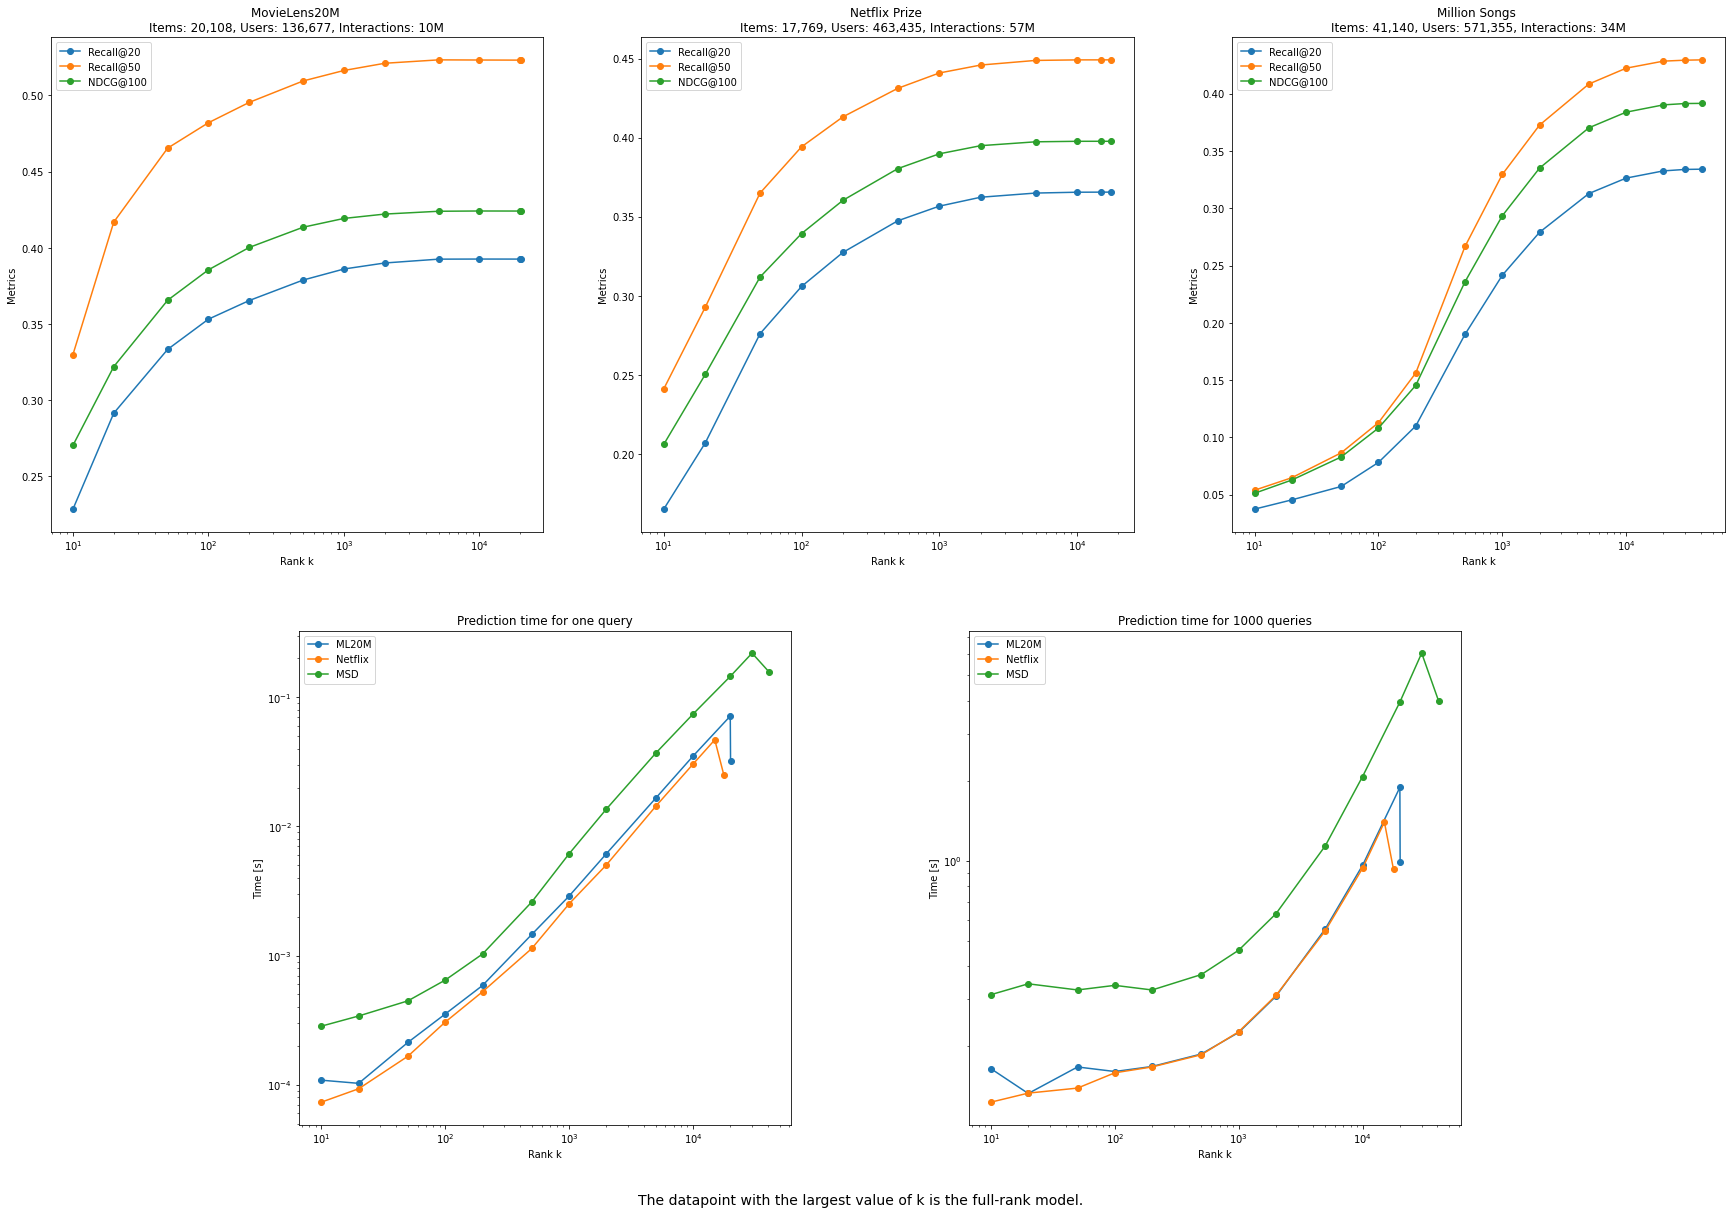

In [15]:
results_svd_ML20 = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_svd.csv')
results_svd_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_svd.csv')
results_svd_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_svd.csv')

results_svd_ML20.sort_values(by='k', inplace=True)
results_svd_netflix.sort_values(by='k', inplace=True)
results_svd_msd.sort_values(by='k', inplace=True)

results_svd_ML20.reset_index(drop=True, inplace=True)
results_svd_netflix.reset_index(drop=True, inplace=True)
results_svd_msd.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax[1, 2].set_visible(False)

ax[1, 0].set_position([0.24,0.125,0.228,0.343])
ax[1, 1].set_position([0.55,0.125,0.228,0.343])

ax[0, 0].plot(results_svd_ML20.k, results_svd_ML20['Recall@20'], marker='o', label='Recall@20')
ax[0, 0].plot(results_svd_ML20.k, results_svd_ML20['Recall@50'], marker='o', label='Recall@50')
ax[0, 0].plot(results_svd_ML20.k, results_svd_ML20['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 0].set_xlabel('Rank k')
ax[0, 0].set_ylabel('Metrics')
ax[0, 0].set_xscale('log')
ax[0, 0].set_title('MovieLens20M \nItems: 20,108, Users: 136,677, Interactions: 10M')
ax[0, 0].legend()

ax[0, 1].plot(results_svd_netflix.k, results_svd_netflix['Recall@20'], marker='o', label='Recall@20')
ax[0, 1].plot(results_svd_netflix.k, results_svd_netflix['Recall@50'], marker='o', label='Recall@50')
ax[0, 1].plot(results_svd_netflix.k, results_svd_netflix['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 1].set_xlabel('Rank k')
ax[0, 1].set_ylabel('Metrics')
ax[0, 1].set_xscale('log')
ax[0, 1].set_title('Netflix Prize \nItems: 17,769, Users: 463,435, Interactions: 57M')
ax[0, 1].legend()

ax[0, 2].plot(results_svd_msd.k, results_svd_msd['Recall@20'], marker='o', label='Recall@20')
ax[0, 2].plot(results_svd_msd.k, results_svd_msd['Recall@50'], marker='o', label='Recall@50')
ax[0, 2].plot(results_svd_msd.k, results_svd_msd['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 2].set_xlabel('Rank k')
ax[0, 2].set_ylabel('Metrics')
ax[0, 2].set_xscale('log')
ax[0, 2].set_title('Million Songs \nItems: 41,140, Users: 571,355, Interactions: 34M')
ax[0, 2].legend()

ax[1, 0].plot(results_svd_ML20.k, results_svd_ML20['query time'], marker='o', label='ML20M')
ax[1, 0].plot(results_svd_netflix.k, results_svd_netflix['query time'], marker='o', label='Netflix')
ax[1, 0].plot(results_svd_msd.k, results_svd_msd['query time'], marker='o', label='MSD')
ax[1, 0].set_xlabel('Rank k')
ax[1, 0].set_ylabel('Time [s]')
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_title('Prediction time for one query')
ax[1, 0].legend()

ax[1, 1].plot(results_svd_ML20.k, results_svd_ML20['batch time'], marker='o', label='ML20M')
ax[1, 1].plot(results_svd_netflix.k, results_svd_netflix['batch time'], marker='o', label='Netflix')
ax[1, 1].plot(results_svd_msd.k, results_svd_msd['batch time'], marker='o', label='MSD')
ax[1, 1].set_xlabel('Rank k')
ax[1, 1].set_ylabel('Time [s]')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_title('Prediction time for 1000 queries')
ax[1, 1].legend()

plt.figtext(0.5, 0.07, "The datapoint with the largest value of k is the full-rank model.", ha="center", fontsize=14,);

## EDLAE Low-Rank

In [12]:
def run_lowrank_benchmark(path_to_BWV, result_path, X_test_tr, fitted_model, result_metrics, test_tr, test_te, k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]):
    batch_times, query_times = [], []
    recalls20, recalls50, ndcgs100 = [], [], []

    batch_time, query_time = timeit_dense(
                     model_mat = fitted_model.B,
                     X_test_tr = X_test_tr, 
                     n_users_test = X_test_tr.shape[0], 
                     max_k = 100)

    batch_times.append(batch_time)
    query_times.append(query_time)
    recalls20.append(result_metrics["Recall(k=20)"])
    recalls50.append(result_metrics["Recall(k=50)"])
    ndcgs100.append(result_metrics["NDCG(k=100)"])
    
    B = np.load(file=f'{path_to_BWV}/B.npy',)
    W = np.load(file=f'{path_to_BWV}/W.npy',)
    V = np.load(file=f'{path_to_BWV}/V.npy',)

    for k in k_vec:
        print(f'Current {k}')
        V_k = V[:, -k:]
        U_k = np.dot(B, V_k)
        batch_time, query_time = timeit_dense_lowrank(model_U=U_k, model_V=V_k, X_test_tr=X_test_tr, n_users_test=X_test_tr.shape[0], max_k = 100)

        fitted_model.B = np.dot(U_k, V_k.T)
        metr_EDLAE = fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',])

        batch_times.append(batch_time)
        query_times.append(query_time)
        recalls20.append(metr_EDLAE["Recall(k=20)"])
        recalls50.append(metr_EDLAE["Recall(k=50)"])
        ndcgs100.append(metr_EDLAE["NDCG(k=100)"])
        
    results = pd.DataFrame(
                 {'k': [fitted_model.nItems] + k_vec,
                  'Recall@20': recalls20,
                  'Recall@50': recalls50,
                  'NDCG@100': ndcgs100,
                  'query time': query_times,
                  'batch time': batch_times,})
    results.to_csv(result_path, index=False)

### ML20M

#### Eigendecomposition

In [12]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108, store_G_inv=True)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 4.826716899871826
Cholesky: 3.426337242126465
Computing Inverse based on Chol: 7.794515609741211
finished inverse computation
After Inverse computation: 0.16390395164489746
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [13]:
M = model_EDLAE.B.T @ model_EDLAE.G_inv @ model_EDLAE.B
W, V = eigh(M, driver='evd')

np.save(file='EDLAE_mat/ml20m/B.npy', arr=model_EDLAE.B)
np.save(file='EDLAE_mat/ml20m/G_inv.npy', arr=model_EDLAE.G_inv)
np.save(file='EDLAE_mat/ml20m/W.npy', arr=W)
np.save(file='EDLAE_mat/ml20m/V.npy', arr=V)

#### Benchmark

In [14]:
run_lowrank_benchmark(path_to_BWV='EDLAE_mat/ml20m', result_path='/home/pmoritz/dev/modsem/benchmarks/ml20m_lowrank.csv', 
                      X_test_tr=X_test_tr_ML20M, 
                      fitted_model=model_EDLAE, 
                      result_metrics=metr_EDLAE, 
                      test_tr=test_tr_ML20M, 
                      test_te=test_te_ML20M, 
                      k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### Netflix

#### Eigendecomposition

In [14]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769, store_G_inv=True)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 34.278003454208374
Cholesky: 2.4420628547668457
Computing Inverse based on Chol: 6.9781553745269775
finished inverse computation
After Inverse computation: 0.13025689125061035
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.36553381, Recall@50: 0.44917571, NDCG@100: 0.39768713


In [15]:
M = model_EDLAE.B.T @ model_EDLAE.G_inv @ model_EDLAE.B
W, V = eigh(M, driver='evd')

np.save(file='EDLAE_mat/netflix/B.npy', arr=model_EDLAE.B)
np.save(file='EDLAE_mat/netflix/G_inv.npy', arr=model_EDLAE.G_inv)
np.save(file='EDLAE_mat/netflix/W.npy', arr=W)
np.save(file='EDLAE_mat/netflix/V.npy', arr=V)

#### Benchmark

In [15]:
run_lowrank_benchmark(path_to_BWV='EDLAE_mat/netflix', result_path='/home/pmoritz/dev/modsem/benchmarks/netflix_lowrank.csv', 
                      X_test_tr=X_test_tr_netflix, 
                      fitted_model=model_EDLAE, 
                      result_metrics=metr_EDLAE, 
                      test_tr=test_tr_netflix, 
                      test_te=test_te_netflix, 
                      k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 15000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### MSD

#### Eigendecomposition

In [13]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140, store_G_inv=True)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 21.4307861328125
Cholesky: 25.83622646331787
Computing Inverse based on Chol: 102.83558678627014
finished inverse computation
After Inverse computation: 0.6017587184906006
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33407616, Recall@50: 0.42947739, NDCG@100: 0.39150817


In [14]:
M = model_EDLAE.B.T @ model_EDLAE.G_inv @ model_EDLAE.B
W, V = eigh(M, driver='ev')

np.save(file='EDLAE_mat/msd/B.npy', arr=model_EDLAE.B)
np.save(file='EDLAE_mat/msd/G_inv.npy', arr=model_EDLAE.G_inv)
np.save(file='EDLAE_mat/msd/W.npy', arr=W)
np.save(file='EDLAE_mat/msd/V.npy', arr=V)

#### Benchmark

In [15]:
run_lowrank_benchmark(path_to_BWV='EDLAE_mat/msd', result_path='/home/pmoritz/dev/modsem/benchmarks/msd_lowrank.csv', 
                      X_test_tr=X_test_tr_msd, 
                      fitted_model=model_EDLAE, 
                      result_metrics=metr_EDLAE, 
                      test_tr=test_tr_msd, 
                      test_te=test_te_msd, 
                      k_vec = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000])

Current 10
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 20
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 50
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 100
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 200
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 500
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 1000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 2000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 5000
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current 10000
create lookup
create true item df
predict

### Plot of the results

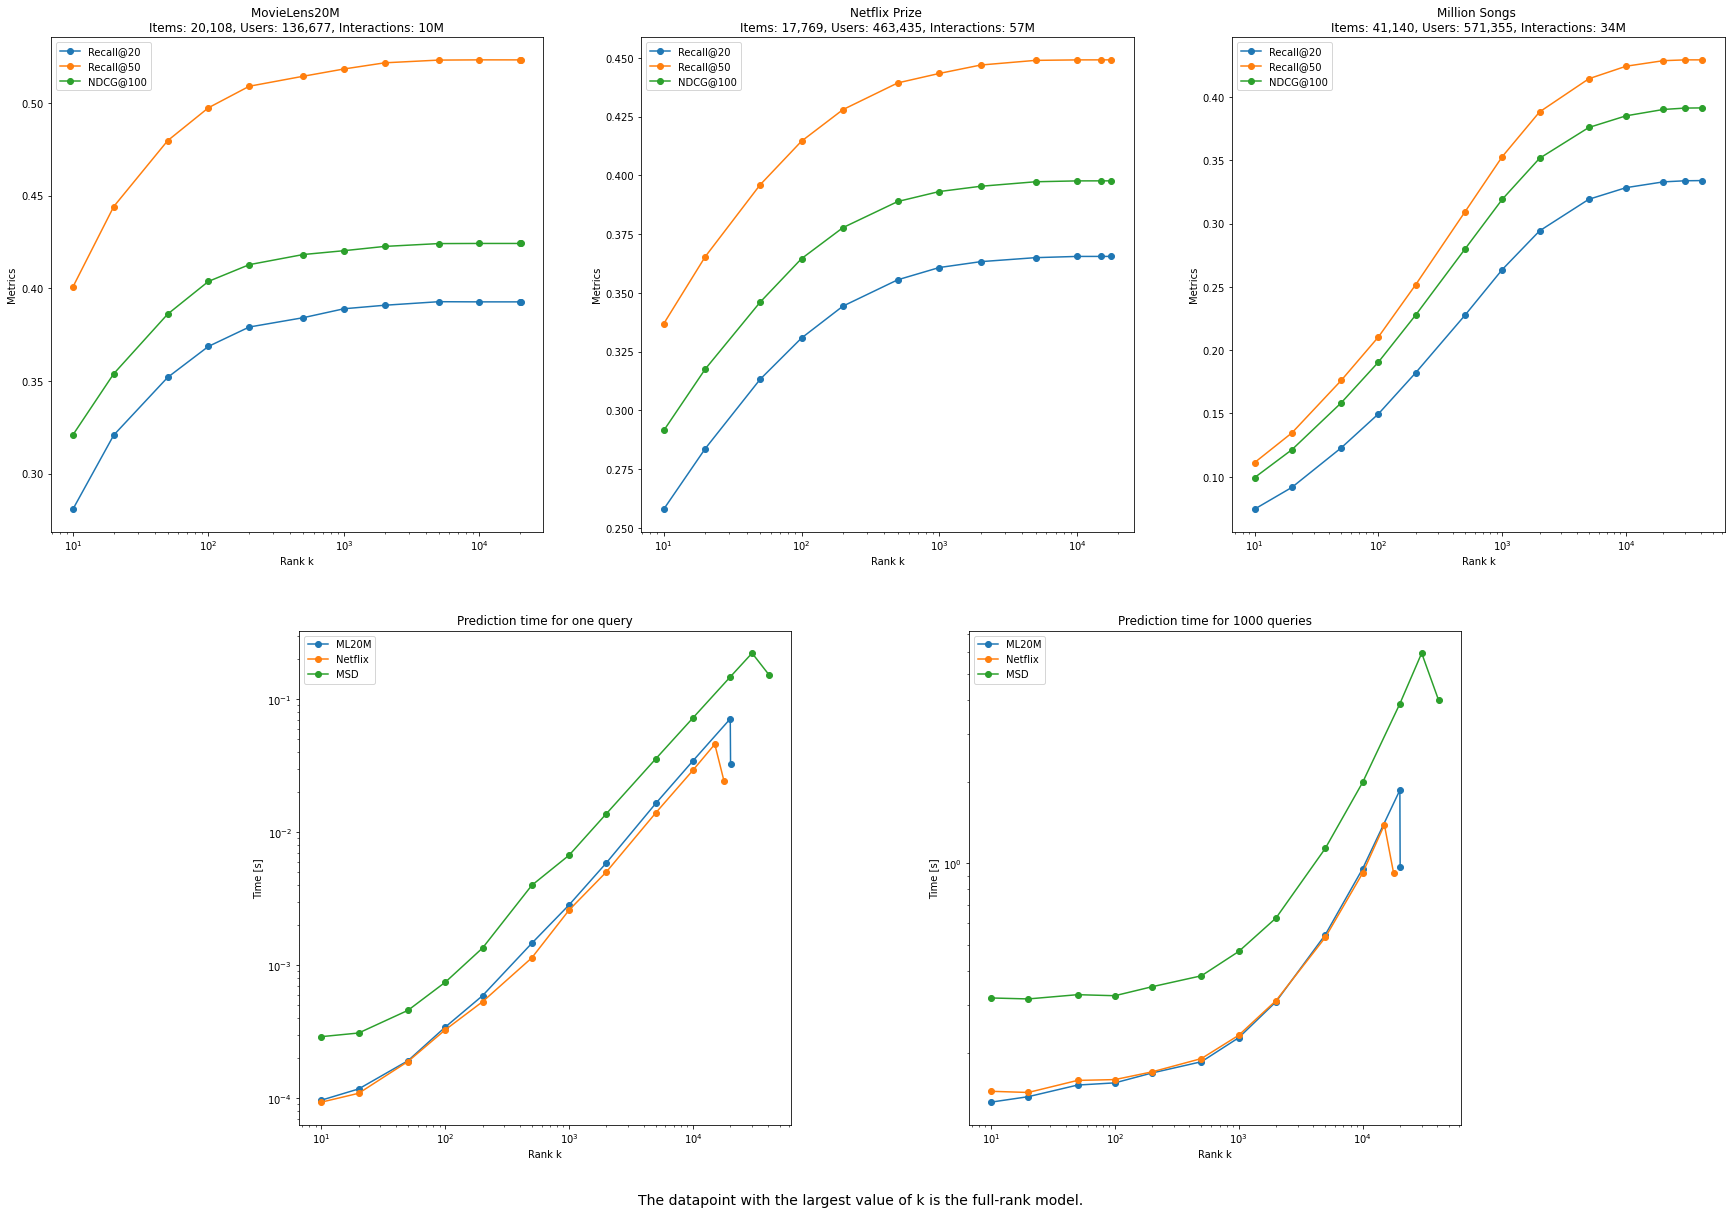

In [16]:
results_lowrank_ML20 = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_lowrank.csv')
results_lowrank_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_lowrank.csv')
results_lowrank_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_lowrank.csv')

results_lowrank_ML20.sort_values(by='k', inplace=True)
results_lowrank_netflix.sort_values(by='k', inplace=True)
results_lowrank_msd.sort_values(by='k', inplace=True)

results_lowrank_ML20.reset_index(drop=True, inplace=True)
results_lowrank_netflix.reset_index(drop=True, inplace=True)
results_lowrank_msd.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax[1, 2].set_visible(False)

ax[1, 0].set_position([0.24,0.125,0.228,0.343])
ax[1, 1].set_position([0.55,0.125,0.228,0.343])

ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['Recall@20'], marker='o', label='Recall@20')
ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['Recall@50'], marker='o', label='Recall@50')
ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 0].set_xlabel('Rank k')
ax[0, 0].set_ylabel('Metrics')
ax[0, 0].set_xscale('log')
ax[0, 0].set_title('MovieLens20M \nItems: 20,108, Users: 136,677, Interactions: 10M')
ax[0, 0].legend()

ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['Recall@20'], marker='o', label='Recall@20')
ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['Recall@50'], marker='o', label='Recall@50')
ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 1].set_xlabel('Rank k')
ax[0, 1].set_ylabel('Metrics')
ax[0, 1].set_xscale('log')
ax[0, 1].set_title('Netflix Prize \nItems: 17,769, Users: 463,435, Interactions: 57M')
ax[0, 1].legend()

ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['Recall@20'], marker='o', label='Recall@20')
ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['Recall@50'], marker='o', label='Recall@50')
ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['NDCG@100'], marker='o', label='NDCG@100')
ax[0, 2].set_xlabel('Rank k')
ax[0, 2].set_ylabel('Metrics')
ax[0, 2].set_xscale('log')
ax[0, 2].set_title('Million Songs \nItems: 41,140, Users: 571,355, Interactions: 34M')
ax[0, 2].legend()

ax[1, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['query time'], marker='o', label='ML20M')
ax[1, 0].plot(results_lowrank_netflix.k, results_lowrank_netflix['query time'], marker='o', label='Netflix')
ax[1, 0].plot(results_lowrank_msd.k, results_lowrank_msd['query time'], marker='o', label='MSD')
ax[1, 0].set_xlabel('Rank k')
ax[1, 0].set_ylabel('Time [s]')
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_title('Prediction time for one query')
ax[1, 0].legend()

ax[1, 1].plot(results_lowrank_ML20.k, results_lowrank_ML20['batch time'], marker='o', label='ML20M')
ax[1, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['batch time'], marker='o', label='Netflix')
ax[1, 1].plot(results_lowrank_msd.k, results_lowrank_msd['batch time'], marker='o', label='MSD')
ax[1, 1].set_xlabel('Rank k')
ax[1, 1].set_ylabel('Time [s]')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_title('Prediction time for 1000 queries')
ax[1, 1].legend()

plt.figtext(0.5, 0.07, "The datapoint with the largest value of k is the full-rank model.", ha="center", fontsize=14,);

## Comparision of both Lowrank Models

In [55]:
results_lowrank_ML20 = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_lowrank.csv')
results_lowrank_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_lowrank.csv')
results_lowrank_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_lowrank.csv')

results_lowrank_ML20.sort_values(by='k', inplace=True)
results_lowrank_netflix.sort_values(by='k', inplace=True)
results_lowrank_msd.sort_values(by='k', inplace=True)

results_lowrank_ML20.reset_index(drop=True, inplace=True)
results_lowrank_netflix.reset_index(drop=True, inplace=True)
results_lowrank_msd.reset_index(drop=True, inplace=True)


results_svd_ML20 = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_svd.csv')
results_svd_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_svd.csv')
results_svd_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_svd.csv')

results_svd_ML20.sort_values(by='k', inplace=True)
results_svd_netflix.sort_values(by='k', inplace=True)
results_svd_msd.sort_values(by='k', inplace=True)

results_svd_ML20.reset_index(drop=True, inplace=True)
results_svd_netflix.reset_index(drop=True, inplace=True)
results_svd_msd.reset_index(drop=True, inplace=True)

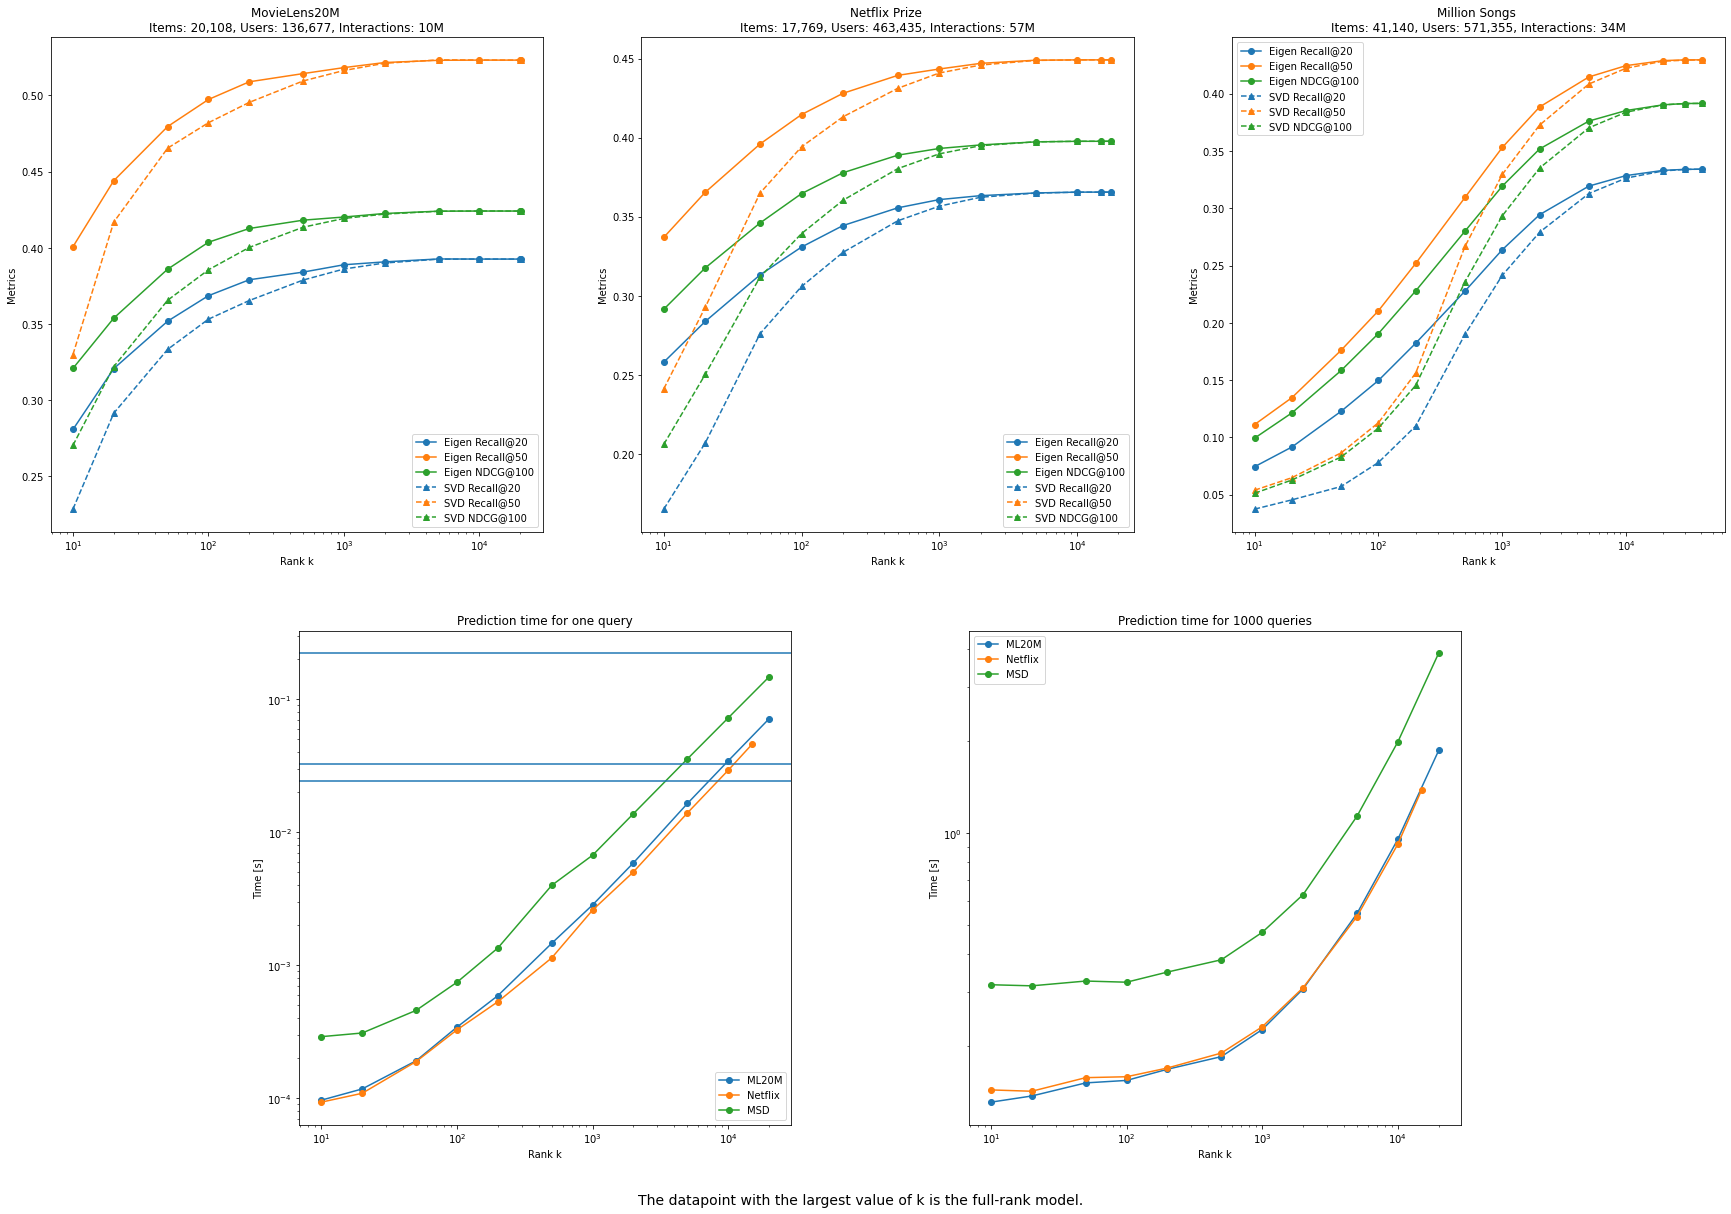

In [69]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax[1, 2].set_visible(False)

ax[1, 0].set_position([0.24,0.125,0.228,0.343])
ax[1, 1].set_position([0.55,0.125,0.228,0.343])

ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['Recall@20'], marker='o', label='Eigen Recall@20')
ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['Recall@50'], marker='o', label='Eigen Recall@50')
ax[0, 0].plot(results_lowrank_ML20.k, results_lowrank_ML20['NDCG@100'], marker='o', label='Eigen NDCG@100')
ax[0, 0].plot(results_svd_ML20.k, results_svd_ML20['Recall@20'], marker='^', ls='dashed', color='tab:blue',   label='SVD Recall@20')
ax[0, 0].plot(results_svd_ML20.k, results_svd_ML20['Recall@50'], marker='^', ls='dashed', color='tab:orange', label='SVD Recall@50')
ax[0, 0].plot(results_svd_ML20.k, results_svd_ML20['NDCG@100'],  marker='^', ls='dashed', color='tab:green',  label='SVD NDCG@100')
ax[0, 0].set_xlabel('Rank k')
ax[0, 0].set_ylabel('Metrics')
ax[0, 0].set_xscale('log')
ax[0, 0].set_title('MovieLens20M \nItems: 20,108, Users: 136,677, Interactions: 10M')
ax[0, 0].legend()

ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['Recall@20'], marker='o', label='Eigen Recall@20')
ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['Recall@50'], marker='o', label='Eigen Recall@50')
ax[0, 1].plot(results_lowrank_netflix.k, results_lowrank_netflix['NDCG@100'], marker='o', label='Eigen NDCG@100')
ax[0, 1].plot(results_svd_netflix.k, results_svd_netflix['Recall@20'], marker='^', ls='dashed', color='tab:blue',   label='SVD Recall@20')
ax[0, 1].plot(results_svd_netflix.k, results_svd_netflix['Recall@50'], marker='^', ls='dashed', color='tab:orange', label='SVD Recall@50')
ax[0, 1].plot(results_svd_netflix.k, results_svd_netflix['NDCG@100'],  marker='^', ls='dashed', color='tab:green',  label='SVD NDCG@100')
ax[0, 1].set_xlabel('Rank k')
ax[0, 1].set_ylabel('Metrics')
ax[0, 1].set_xscale('log')
ax[0, 1].set_title('Netflix Prize \nItems: 17,769, Users: 463,435, Interactions: 57M')
ax[0, 1].legend()

ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['Recall@20'], marker='o', label='Eigen Recall@20')
ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['Recall@50'], marker='o', label='Eigen Recall@50')
ax[0, 2].plot(results_lowrank_msd.k, results_lowrank_msd['NDCG@100'], marker='o', label='Eigen NDCG@100')
ax[0, 2].plot(results_svd_msd.k, results_svd_msd['Recall@20'], marker='^', ls='dashed', color='tab:blue',   label='SVD Recall@20')
ax[0, 2].plot(results_svd_msd.k, results_svd_msd['Recall@50'], marker='^', ls='dashed', color='tab:orange', label='SVD Recall@50')
ax[0, 2].plot(results_svd_msd.k, results_svd_msd['NDCG@100'],  marker='^', ls='dashed', color='tab:green',  label='SVD NDCG@100')
ax[0, 2].set_xlabel('Rank k')
ax[0, 2].set_ylabel('Metrics')
ax[0, 2].set_xscale('log')
ax[0, 2].set_title('Million Songs \nItems: 41,140, Users: 571,355, Interactions: 34M')
ax[0, 2].legend()

ax[1, 0].plot(results_lowrank_ML20.k.loc[:10], results_lowrank_ML20.loc[:10,'query time'], marker='o', label='ML20M')
ax[1, 0].plot(results_lowrank_netflix.k.loc[:10], results_lowrank_netflix.loc[:10,'query time'], marker='o', label='Netflix')
ax[1, 0].plot(results_lowrank_msd.k.loc[:10], results_lowrank_msd.loc[:10,'query time'], marker='o', label='MSD')
ax[1, 0].axhline(y=results_lowrank_ML20.loc[11, 'query time'])
ax[1, 0].axhline(y=results_lowrank_netflix.loc[11, 'query time'])
ax[1, 0].axhline(y=results_lowrank_msd.loc[11, 'query time'])
ax[1, 0].set_xlabel('Rank k')
ax[1, 0].set_ylabel('Time [s]')
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_title('Prediction time for one query')
ax[1, 0].legend()

ax[1, 1].plot(results_lowrank_ML20.k.loc[:10], results_lowrank_ML20.loc[:10, 'batch time'], marker='o', label='ML20M')
ax[1, 1].plot(results_lowrank_netflix.k.loc[:10], results_lowrank_netflix.loc[:10, 'batch time'], marker='o', label='Netflix')
ax[1, 1].plot(results_lowrank_msd.k.loc[:10], results_lowrank_msd.loc[:10, 'batch time'], marker='o', label='MSD')
ax[1, 1].set_xlabel('Rank k')
ax[1, 1].set_ylabel('Time [s]')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_title('Prediction time for 1000 queries')
ax[1, 1].legend()

plt.figtext(0.5, 0.07, "The datapoint with the largest value of k is the full-rank model.", ha="center", fontsize=14,);

In [73]:
results_lowrank_ML20[:-1]

,k,Recall@20,Recall@50,NDCG@100,query time,batch time
0,10,0.280793,0.400729,0.320885,0.000097,0.131170
1,20,0.320738,0.444066,0.353849,0.000118,0.137410
2,50,0.351882,0.479617,0.386021,0.000192,0.151671
3,100,0.368603,0.497372,0.403679,0.000343,0.154521
4,200,0.379051,0.508975,0.412699,0.000592,0.168104
5,500,0.384080,0.514366,0.418164,0.001466,0.184923
6,1000,0.388903,0.518292,0.420240,0.002848,0.226786
7,2000,0.390804,0.521622,0.422550,0.005897,0.307890
8,5000,0.392714,0.523092,0.424076,0.016469,0.544280
9,10000,0.392628,0.523216,0.424152,0.034469,0.952974


## EDLAE Sparse

In [14]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
B_ml20m = deepcopy(model_EDLAE.B).ravel()

Until Inverse computation: 4.469532251358032
Cholesky: 3.119199752807617
Computing Inverse based on Chol: 7.14460301399231
finished inverse computation
After Inverse computation: 0.13729596138000488


In [13]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
B_netflix = deepcopy(model_EDLAE.B).ravel()

Until Inverse computation: 31.67609405517578
Cholesky: 2.2689380645751953
Computing Inverse based on Chol: 5.313996315002441
finished inverse computation
After Inverse computation: 0.10909366607666016


In [12]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
B_msd = deepcopy(model_EDLAE.B).ravel()

Until Inverse computation: 21.61354422569275
Cholesky: 25.918129682540894
Computing Inverse based on Chol: 102.9903609752655
finished inverse computation
After Inverse computation: 0.5948982238769531


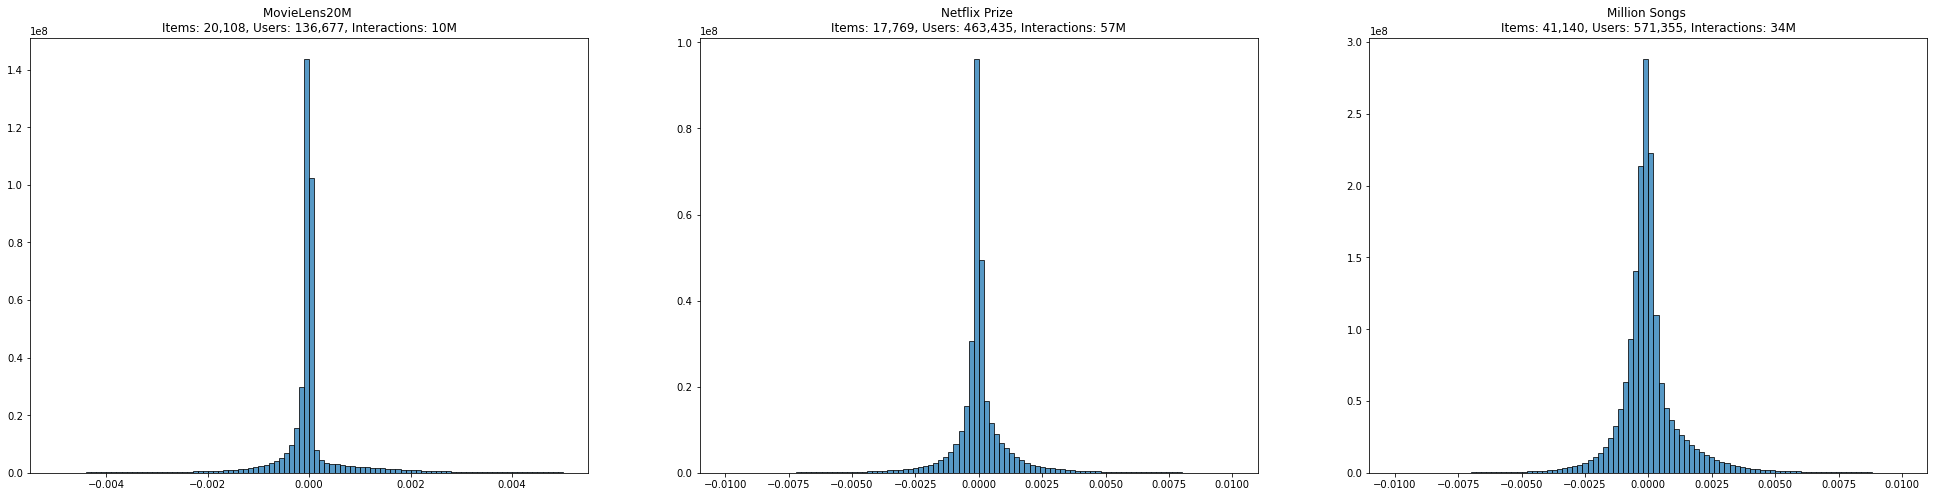

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(34, 8))
ax[0].set_title('MovieLens20M \nItems: 20,108, Users: 136,677, Interactions: 10M')
ax[1].set_title('Netflix Prize \nItems: 17,769, Users: 463,435, Interactions: 57M')
ax[2].set_title('Million Songs \nItems: 41,140, Users: 571,355, Interactions: 34M')
ax[0].hist(B_ml20m, bins=100, range=(-0.005, 0.005), alpha=0.75, edgecolor='black', linewidth=1.);
ax[1].hist(B_netflix, bins=100, range=(-0.01, 0.01), alpha=0.75, edgecolor='black', linewidth=1.);
ax[2].hist(B_msd, bins=100, range=(-0.01, 0.01), alpha=0.75, edgecolor='black', linewidth=1.);

In [50]:
statistics = pd.DataFrame(data=pd.Series(B_ml20m).describe(), columns=['ML20M'])
statistics['Netflix'] = pd.Series(B_netflix).describe()
statistics['MSD'] = pd.Series(B_msd).describe()

In [53]:
statistics

,ML20M,Netflix,MSD
count,4.043317e+08,3.157374e+08,1.692500e+09
mean,4.527577e-05,7.066896e-05,7.980115e-05
std,1.087268e-03,1.418445e-03,1.348786e-03
min,-4.572652e-02,-4.800731e-02,-1.300713e-01
25%,-9.498488e-05,-2.588480e-04,-4.880900e-04
50%,-8.170368e-06,-3.645271e-05,-9.973293e-05
75%,1.506961e-05,2.036840e-04,2.768945e-04
max,3.325847e-01,4.158251e-01,5.853912e-01


#### Example

In [17]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 4.906426668167114
Cholesky: 3.101982355117798
Computing Inverse based on Chol: 7.268150329589844
finished inverse computation
After Inverse computation: 0.13845372200012207
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [18]:
model_EDLAE.B = sparsify(model_EDLAE.B, threshold=0.00704, max_in_col=20108)
model_EDLAE.B = model_EDLAE.B.toarray()
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983463278799753
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38448743, Recall@50: 0.50805613, NDCG@100: 0.41366151


In [19]:
B_csr = sp.csr_matrix(model_EDLAE.B)

#### Test if the stuff used in run_sparse_straightforward_benchmark actually works

In [20]:
from metrics import Recall, NDCG
from sparse_dot_topn import awesome_cossim_topn

In [21]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
model_EDLAE.B = sparsify(model_EDLAE.B, threshold=0.00704, max_in_col=20108)
B_csr = sp.csr_matrix(deepcopy(model_EDLAE.B))

sparse_id = sp.identity(B_csr.shape[0], dtype=np.float32, format='csr')
B_csr_thilde = B_csr - np.inf * sparse_id

Until Inverse computation: 4.4488959312438965
Cholesky: 3.089402675628662
Computing Inverse based on Chol: 7.218997240066528
finished inverse computation
After Inverse computation: 0.13896965980529785
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983463278799753


In [22]:
top_k = awesome_cossim_topn(A=X_test_tr_ML20M, B=B_csr_thilde, ntop=100, use_threads=True, n_jobs=16)

In [23]:
recall20 = Recall(k=20)
recall50 = Recall(k=50)
ndcg100 = NDCG(k=100)

recall20_metr, recall50_metr, ndcg100_metr = [], [], []
for row_idx in range(X_test_tr_ML20M.shape[0]):
    pred_items = top_k[row_idx].indices
    true_items = X_test_te_ML20M[row_idx].indices
    
    recall20_metr.append(recall20(pred_items, true_items))
    recall50_metr.append(recall50(pred_items, true_items))
    ndcg100_metr.append(ndcg100(pred_items, true_items))

In [24]:
np.mean(recall20_metr), np.mean(recall50_metr), np.mean(ndcg100_metr)

(0.38448743230840365, 0.5080561290209418, 0.41366150550051173)

### Sparse Straightforward

In [13]:
def run_sparse_straightforward_benchmark(result_path, X_test_tr, fitted_model, test_tr, test_te, sparsity_threshold, max_in_col):
    model_mat = deepcopy(fitted_model.B)
    
    sparsities, thresholds = [], []
    batch_times, query_times = [], []
    recall20, recall50, ndcg100 = [], [], []

    for sparsity in sparsity_threshold:
        print(f'Current Sparsity: {sparsity}')
        threshold = sparsity_threshold[sparsity]
        A = sparsify(model_mat, threshold=threshold, max_in_col=max_in_col)
        fitted_model.B = np.zeros(model_mat.shape, dtype=np.float32)
        fitted_model.B[A.nonzero()] = model_mat[A.nonzero()]
        calc_sparsity = len(A.nonzero()[0]) / (fitted_model.B.shape[0] * fitted_model.B.shape[1])

        batch_time, query_time = timeit_sparse(model_sparse = sp.csr_matrix(fitted_model.B), 
                                               X_test = X_test_tr, 
                                               n_users_test = X_test_tr.shape[0], max_k = 100)

        metr_EDLAE = fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',])

        sparsities.append(calc_sparsity)
        thresholds.append(threshold)
        batch_times.append(batch_time)
        query_times.append(query_time)
        recall20.append(metr_EDLAE["Recall(k=20)"])
        recall50.append(metr_EDLAE["Recall(k=50)"])
        ndcg100.append(metr_EDLAE["NDCG(k=100)"])

    results = pd.DataFrame({'sparsity': sparsities,
                           'threshold': thresholds,
                           'query_time': query_times, 
                           'batch_time': batch_times,
                           'recall@20': recall20,
                           'recall@50': recall50,
                           'ndcg@100': ndcg100,})
    results.to_csv(result_path, index=False, sep='|')    

#### ML20M

In [12]:
!pwd

/home/pmoritz/dev/modsem


In [13]:
sparsity_threshold_ml20m = {0.1: 0.0122,
                            0.5: 0.00704,
                            1.0: 0.00522,
                            2.0: 0.00366,
                            5.0: 0.00208}

model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

Until Inverse computation: 4.508584022521973
Cholesky: 3.1576168537139893
Computing Inverse based on Chol: 7.139189004898071
finished inverse computation
After Inverse computation: 0.13732671737670898


In [14]:
run_sparse_straightforward_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward.csv', 
                                     X_test_tr=X_test_tr_ML20M, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_ML20M, 
                                     test_te=test_te_ML20M, 
                                     sparsity_threshold=sparsity_threshold_ml20m, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 0.5
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983463278799753
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 1.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.009972528394412365
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 2.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.019977329799231357
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 5.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.04984667488223232

In [15]:
results_straightf_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward.csv', sep='|')

In [21]:
results_straightf_ml20m

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01220,0.000042,0.002146,0.371671,0.493390,0.402077
1,0.004983,0.00704,0.000048,0.003819,0.384487,0.508056,0.413662
2,0.009973,0.00522,0.000055,0.005191,0.388080,0.513011,0.417552
3,0.019977,0.00366,0.000070,0.007292,0.390239,0.518839,0.420696
4,0.049847,0.00208,0.000103,0.012698,0.391565,0.522446,0.423361


#### Netflix

In [22]:
sparsity_threshold_netflix = {0.1: 0.0129,
                           0.5: 0.00791,
                           1.0: 0.00621,
                           2.0: 0.00467,
                           5.0: 0.00292}

model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

Until Inverse computation: 31.698161363601685
Cholesky: 2.2697086334228516
Computing Inverse based on Chol: 5.296881675720215
finished inverse computation
After Inverse computation: 0.1143183708190918


In [23]:
run_sparse_straightforward_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward.csv', 
                                     X_test_tr=X_test_tr_netflix, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_netflix, 
                                     test_te=test_te_netflix, 
                                     sparsity_threshold=sparsity_threshold_netflix, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 0.5
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004982397379320593
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 1.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.009967854263531391
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 2.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.01999268626306153
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 5.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.04977902187508307

In [24]:
results_straightf_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward.csv', sep='|')

In [25]:
results_straightf_netflix

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000992,0.01290,0.000041,0.002423,0.344885,0.424491,0.376210
1,0.004982,0.00791,0.000046,0.003890,0.352183,0.434613,0.385183
2,0.009968,0.00621,0.000052,0.004953,0.355969,0.438597,0.388261
3,0.019993,0.00467,0.000061,0.006720,0.359929,0.442264,0.391517
4,0.049779,0.00292,0.000085,0.010831,0.363352,0.446397,0.395190


#### MSD

In [11]:
sparsity_threshold_msd = {0.1: 0.0120,
                          0.5: 0.00695,
                          1.0: 0.00548,
                          2.0: 0.00421,
                          5.0: 0.00285}

model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

Until Inverse computation: 21.46498465538025
Cholesky: 25.828450202941895
Computing Inverse based on Chol: 104.24517369270325
finished inverse computation
After Inverse computation: 0.6144442558288574


In [14]:
run_sparse_straightforward_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward.csv', 
                                     X_test_tr=X_test_tr_msd, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_msd, 
                                     test_te=test_te_msd, 
                                     sparsity_threshold=sparsity_threshold_msd, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 0.5
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.004999415657173567
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 1.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.009965166313776381
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 2.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.019910698354079374
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Current Sparsity: 5.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0498602032165916

In [15]:
results_straightf_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward.csv', sep='|')

In [16]:
results_straightf_msd

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01200,0.000045,0.002113,0.329580,0.421199,0.385550
1,0.004999,0.00695,0.000058,0.004913,0.332307,0.425618,0.388885
2,0.009965,0.00548,0.000077,0.007933,0.332764,0.426840,0.389641
3,0.019911,0.00421,0.000119,0.012973,0.333207,0.427856,0.390281
4,0.049860,0.00285,0.000236,0.025262,0.333736,0.428533,0.390753


### Covariance Based

In [15]:
def run_sparse_cov_benchmark(result_path, X_train, X_test_tr, fitted_model, test_tr, test_te, sparsity_threshold, max_in_col):
    model_mat = deepcopy(fitted_model.B)
    XtX = np.dot(X_train.T, X_train)
    
    sparsities, thresholds, alphas = [], [], []
    batch_times, query_times = [], []
    recall20, recall50, ndcg100 = [], [], []

    for sparsity, thresh_alpha in sparsity_threshold.items():
        threshold, alpha = thresh_alpha
        print(f'Current Sparsity: {sparsity}')
        A = sparsity_pattern_cov(XtX=deepcopy(XtX.toarray()), n_users=X_train.shape[0], 
                                 max_in_col=max_in_col, alpha=alpha, threshold=threshold)
        fitted_model.B = np.zeros(model_mat.shape, dtype=np.float32)
        fitted_model.B[A.nonzero()] = model_mat[A.nonzero()]
        calc_sparsity = len(A.nonzero()[0]) / (fitted_model.B.shape[0] * fitted_model.B.shape[1])

        batch_time, query_time = timeit_sparse(model_sparse = sp.csr_matrix(fitted_model.B), 
                                               X_test = X_test_tr, 
                                               n_users_test = X_test_tr.shape[0], max_k = 100)
        #print(len(fitted_model.B.nonzero()[0]))
        #print(fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]))
        res_metrics = fitted_model.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics=['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',])
        print(f'Metrics:  Recall@20: {res_metrics["Recall(k=20)"]:.8f}, Recall@50: {res_metrics["Recall(k=50)"]:.8f}, NDCG@100: {res_metrics["NDCG(k=100)"]:.8f}')

        sparsities.append(calc_sparsity)
        thresholds.append(threshold)
        alphas.append(alpha)
        batch_times.append(batch_time)
        query_times.append(query_time)
        recall20.append(float(res_metrics["Recall(k=20)"]))
        recall50.append(float(res_metrics["Recall(k=50)"]))
        ndcg100.append(float(res_metrics["NDCG(k=100)"]))

    results = pd.DataFrame({'sparsity': sparsities,
                           'threshold': thresholds,
                           'alphas': alphas,
                           'query_time': query_times, 
                           'batch_time': batch_times,
                           'recall@20': recall20,
                           'recall@50': recall50,
                           'ndcg@100': ndcg100,})
    results.to_csv(result_path, index=False, sep='|')    

#### ML20M

In [12]:
hyperparam_search_ml20m = pd.read_csv(f'hyperparam_search/sparse_cov_ml20m.csv', sep='|')
hyperparam_search_ml20m['sum'] = hyperparam_search_ml20m['recall@20'] + hyperparam_search_ml20m['recall@50'] + hyperparam_search_ml20m['ndcg@100']

In [13]:
hyperparam_search_ml20m[hyperparam_search_ml20m.desired_sparsity == 5.].sort_values(by='sum', ascending=True)

,desired_sparsity,actual_sparsity,threshold,alpha,recall@20,recall@50,ndcg@100,sum
19,5.0,0.049889,0.0399,1.00,0.394128,0.520827,0.428902,1.343857
18,5.0,0.049768,0.1340,0.75,0.397297,0.523887,0.430737,1.351921
17,5.0,0.049873,0.4480,0.50,0.397157,0.524133,0.431338,1.352629
16,5.0,0.049840,1.6900,0.25,0.397238,0.524413,0.431642,1.353293


In [14]:
sparsity_threshold_ml20m = {0.1: [6.580, 0.5],
                            0.5: [2.64, 0.5],
                            1.0: [9.23, 0.25],
                            2.0: [4.73, 0.25],
                            5.0: [1.69, 0.25]}

model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

Until Inverse computation: 4.493858098983765
Cholesky: 3.1915595531463623
Computing Inverse based on Chol: 7.154912948608398
finished inverse computation
After Inverse computation: 0.13749980926513672


In [15]:
run_sparse_cov_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov.csv',  
                                     X_train=X_train_ML20M, 
                                     X_test_tr=X_test_tr_ML20M, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_ML20M, 
                                     test_te=test_te_ML20M, 
                                     sparsity_threshold=sparsity_threshold_ml20m, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.37513973, Recall@50: 0.49318726, NDCG@100: 0.40111826
Current Sparsity: 0.5
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004978610826779077
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.38730758, Recall@50: 0.51593067, NDCG@100: 0.41853010
Current Sparsity: 1.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.009997906075444044
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.39019983, Recall@50: 0.52001396, NDCG@100: 0.42119253
Current Sparsity: 2.0
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0199

In [16]:
results_sparsecov_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov.csv', sep='|')

In [17]:
results_sparsecov_ml20m

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000998,6.58,0.50,0.000057,0.005284,0.375140,0.493187,0.401118
1,0.004979,2.64,0.50,0.000095,0.012160,0.387308,0.515931,0.418530
2,0.009998,9.23,0.25,0.000131,0.019115,0.390200,0.520014,0.421193
3,0.019965,4.73,0.25,0.000182,0.027602,0.391896,0.522009,0.422832
4,0.049840,1.69,0.25,0.000293,0.044909,0.392272,0.522881,0.423813


#### Netflix

In [18]:
hyperparam_search_netflix = pd.read_csv(f'hyperparam_search/sparse_cov_netflix.csv', sep='|')
hyperparam_search_netflix['sum'] = hyperparam_search_netflix['recall@20'] + hyperparam_search_netflix['recall@50'] + hyperparam_search_netflix['ndcg@100']

In [19]:
hyperparam_search_netflix[hyperparam_search_netflix.desired_sparsity == 5.].sort_values(by='sum', ascending=True)

,desired_sparsity,actual_sparsity,threshold,alpha,recall@20,recall@50,ndcg@100,sum
19,5.0,0.049879,0.043,1.00,0.363820,0.446956,0.396069,1.206844
16,5.0,0.049985,12.420,0.25,0.364464,0.447053,0.396440,1.207958
18,5.0,0.050071,0.260,0.75,0.364342,0.447346,0.396594,1.208281
17,5.0,0.049916,1.764,0.50,0.364429,0.447388,0.396615,1.208432


In [20]:
sparsity_threshold_netflix = {0.1: [2.047, 0.75],
                              0.5: [1.096, 0.75],
                              1.0: [0.772, 0.75],
                              2.0: [0.509, 0.75],
                              5.0: [1.764, 0.5]}

model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

Until Inverse computation: 31.57154154777527
Cholesky: 2.2781431674957275
Computing Inverse based on Chol: 5.2981603145599365
finished inverse computation
After Inverse computation: 0.10884332656860352


In [21]:
run_sparse_cov_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_cov.csv',  
                                     X_train=X_train_netflix, 
                                     X_test_tr=X_test_tr_netflix, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_netflix, 
                                     test_te=test_te_netflix, 
                                     sparsity_threshold=sparsity_threshold_netflix, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.34568683, Recall@50: 0.42337861, NDCG@100: 0.37511217
Current Sparsity: 0.5
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004996659232861581
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.35978085, Recall@50: 0.44187479, NDCG@100: 0.39129215
Current Sparsity: 1.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.009983259472419547
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.36267501, Recall@50: 0.44593750, NDCG@100: 0.39481642
Current Sparsity: 2.0
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0199

In [23]:
results_sparsecov_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_cov.csv', sep='|')

In [24]:
results_sparsecov_netflix

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,2.047,0.75,0.000057,0.005350,0.345687,0.423379,0.375112
1,0.004997,1.096,0.75,0.000096,0.013188,0.359781,0.441875,0.391292
2,0.009983,0.772,0.75,0.000127,0.019658,0.362675,0.445938,0.394816
3,0.019978,0.509,0.75,0.000174,0.028768,0.364439,0.448163,0.396702
4,0.049916,1.764,0.50,0.000305,0.054065,0.365215,0.449104,0.397588


#### MSD

In [11]:
hyperparam_search_msd = pd.read_csv(f'hyperparam_search/sparse_cov_msd.csv', sep='|')
hyperparam_search_msd['sum'] = hyperparam_search_msd['recall@20'] + hyperparam_search_msd['recall@50'] + hyperparam_search_msd['ndcg@100']

In [12]:
hyperparam_search_msd[hyperparam_search_msd.desired_sparsity == 5].sort_values(by='sum', ascending=True)

,desired_sparsity,actual_sparsity,threshold,alpha,recall@20,recall@50,ndcg@100,sum
16,5.0,0.049910,0.77700,0.25,0.332566,0.429468,0.390237,1.152271
17,5.0,0.049963,0.15170,0.50,0.332503,0.429553,0.390245,1.152301
18,5.0,0.050082,0.03090,0.75,0.332691,0.429577,0.390415,1.152684
19,5.0,0.049975,0.00644,1.00,0.332885,0.429619,0.390539,1.153043


In [13]:
sparsity_threshold_msd = {0.1: [0.37, 0.75],
                          0.5: [0.609, 0.50],
                          1.0: [0.399, 0.50],
                          2.0: [0.0511, 0.75],
                          5.0: [0.00644, 1.0]}

model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

Until Inverse computation: 21.633545637130737
Cholesky: 25.70576000213623
Computing Inverse based on Chol: 102.59968566894531
finished inverse computation
After Inverse computation: 0.5935990810394287


In [16]:
run_sparse_cov_benchmark(result_path='/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov.csv',  
                                     X_train=X_train_msd, 
                                     X_test_tr=X_test_tr_msd, 
                                     fitted_model=model_EDLAE, 
                                     test_tr=test_tr_msd, 
                                     test_te=test_te_msd, 
                                     sparsity_threshold=sparsity_threshold_msd, 
                                     max_in_col=model_EDLAE.B.shape[0])

Current Sparsity: 0.1
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.32876085, Recall@50: 0.41958407, NDCG@100: 0.38431205
Current Sparsity: 0.5
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.004996217428943558
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.33315223, Recall@50: 0.42782471, NDCG@100: 0.39051469
Current Sparsity: 1.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.009993628358907736
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
Metrics:  Recall@20: 0.33353189, Recall@50: 0.42922019, NDCG@100: 0.39124441
Current Sparsity: 2.0
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.01999

In [17]:
results_sparsecov_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov.csv', sep='|')

In [19]:
results_sparsecov_msd

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,0.37000,0.75,0.000051,0.003085,0.328761,0.419584,0.384312
1,0.004996,0.60900,0.50,0.000123,0.014369,0.333152,0.427825,0.390515
2,0.009994,0.39900,0.50,0.000205,0.024410,0.333532,0.429220,0.391244
3,0.019999,0.05110,0.75,0.000283,0.031769,0.333932,0.429746,0.391716
4,0.049975,0.00644,1.00,0.000418,0.048610,0.334155,0.429881,0.391885


### Training times sparse straightforward

In [12]:
def append_benchmark_csv_traintimes(csv_to_append, sep, model_mat, sparsity_threshold, max_in_col):
    df_to_append = pd.read_csv(csv_to_append, sep=sep)
    for sparsity in sparsity_threshold:
        print(f'Current Sparsity: {sparsity}')
        threshold = sparsity_threshold[sparsity]      
                
        def fit_wrapper():
            A = sparsify(model_mat, threshold=threshold, max_in_col=max_in_col)
            B = np.zeros(model_mat.shape, dtype=np.float32)
            B[A.nonzero()] = model_mat[A.nonzero()]

        timer = timeit.Timer(fit_wrapper)
        n_timer, _ = timer.autorange()
        training_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer
        df_to_append.loc[df_to_append.threshold == threshold, 'training_time'] = training_time
        
    df_to_append.to_csv(csv_to_append, sep=sep,index=False)

#### ML20M

In [24]:
sparsity_threshold_ml20m = {0.1: 0.0122,
                            0.5: 0.00704,
                            1.0: 0.00522,
                            2.0: 0.00366,
                            5.0: 0.00208}

model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

append_benchmark_csv_traintimes(csv_to_append='benchmarks/ml20m_sparse_straightforward.csv', 
                                sep='|', 
                                model_mat=model_EDLAE.B, 
                                sparsity_threshold=sparsity_threshold_ml20m, 
                                max_in_col=20108)

Until Inverse computation: 5.39325213432312
Cholesky: 3.100194215774536
Computing Inverse based on Chol: 7.083528757095337
finished inverse computation
After Inverse computation: 0.1416308879852295
Current Sparsity: 0.1
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592
Number of items with more than 20108 entries in colu

#### Netflix

In [25]:
sparsity_threshold_netflix = {0.1: 0.0129,
                           0.5: 0.00791,
                           1.0: 0.00621,
                           2.0: 0.00467,
                           5.0: 0.00292}

model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

append_benchmark_csv_traintimes(csv_to_append='benchmarks/netflix_sparse_straightforward.csv', 
                                sep='|', 
                                model_mat=model_EDLAE.B, 
                                sparsity_threshold=sparsity_threshold_netflix, 
                                max_in_col=17769)

Until Inverse computation: 31.98082947731018
Cholesky: 2.2936384677886963
Computing Inverse based on Chol: 5.317416191101074
finished inverse computation
After Inverse computation: 0.11211276054382324
Current Sparsity: 0.1
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715
Number of items with more than 17769 entri

#### MSD

In [ ]:
sparsity_threshold_msd = {0.1: 0.0120,
                          0.5: 0.00695,
                          1.0: 0.00548,
                          2.0: 0.00421,
                          5.0: 0.00285}

model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

In [13]:
append_benchmark_csv_traintimes(csv_to_append='benchmarks/msd_sparse_straightforward.csv', 
                                sep='|', 
                                model_mat=model_EDLAE.B, 
                                sparsity_threshold=sparsity_threshold_msd, 
                                max_in_col=41140)

Current Sparsity: 0.1
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152
Current Sparsity: 0.5
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.004999415657173567
Number of it

### Training times sparse cov

In [11]:
def append_benchmark_csv_traintimes(csv_to_append, sep, model_mat, X_train, sparsity_threshold, max_in_col):
    df_to_append = pd.read_csv(csv_to_append, sep=sep)
    XtX = np.dot(X_train.T, X_train)
    for sparsity, thresh_alpha in sparsity_threshold.items():
        threshold, alpha = thresh_alpha
        print(f'Current Sparsity: {sparsity}')
        
        def setup_wrapper():
            global XtX_copy
            XtX_copy = deepcopy(XtX.toarray())
               
        def fit_wrapper():
            A = sparsity_pattern_cov(XtX=XtX_copy, n_users=X_train.shape[0], 
                                     max_in_col=max_in_col, alpha=alpha, threshold=threshold)  
            B = np.zeros(model_mat.shape, dtype=np.float32)
            B[A.nonzero()] = model_mat[A.nonzero()]

        timer = timeit.Timer(fit_wrapper, setup=setup_wrapper)
        training_time = min(timer.repeat(repeat=7, number=1)) 
        df_to_append.loc[df_to_append.threshold == threshold, 'training_time'] = training_time
        
    df_to_append.to_csv(csv_to_append, sep=sep,index=False)

#### ML20M

In [44]:
sparsity_threshold_ml20m = {0.1: [6.580, 0.5],
                            0.5: [2.64, 0.5],
                            1.0: [9.23, 0.25],
                            2.0: [4.73, 0.25],
                            5.0: [1.69, 0.25]}

model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

append_benchmark_csv_traintimes(csv_to_append='benchmarks/ml20m_sparse_cov.csv', 
                                sep='|', 
                                model_mat=model_EDLAE.B, 
                                X_train=X_train_ML20M,
                                sparsity_threshold=sparsity_threshold_ml20m, 
                                max_in_col=20108)

Until Inverse computation: 4.4668591022491455
Cholesky: 3.096515417098999
Computing Inverse based on Chol: 7.226041078567505
finished inverse computation
After Inverse computation: 0.136641263961792
Current Sparsity: 0.1
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456
Current Sparsity: 0.5
Number of items with m

#### Netflix

In [45]:
sparsity_threshold_netflix = {0.1: [2.047, 0.75],
                              0.5: [1.096, 0.75],
                              1.0: [0.772, 0.75],
                              2.0: [0.509, 0.75],
                              5.0: [1.764, 0.5]}

model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)

append_benchmark_csv_traintimes(csv_to_append='benchmarks/netflix_sparse_cov.csv', 
                                sep='|', 
                                model_mat=model_EDLAE.B, 
                                X_train=X_train_netflix,
                                sparsity_threshold=sparsity_threshold_netflix, 
                                max_in_col=17769)

Until Inverse computation: 31.911645650863647
Cholesky: 2.31115460395813
Computing Inverse based on Chol: 5.383756399154663
finished inverse computation
After Inverse computation: 0.10706400871276855
Current Sparsity: 0.1
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906
Current Sparsity: 0.5
Number of items with 

#### MSD

In [12]:
sparsity_threshold_msd = {0.1: [0.37, 0.75],
                          0.5: [0.609, 0.50],
                          1.0: [0.399, 0.50],
                          2.0: [0.0511, 0.75],
                          5.0: [0.00644, 1.0]}

model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)

append_benchmark_csv_traintimes(csv_to_append='benchmarks/msd_sparse_cov.csv', 
                                sep='|', 
                                model_mat=model_EDLAE.B, 
                                X_train=X_train_msd,
                                sparsity_threshold=sparsity_threshold_msd, 
                                max_in_col=41140)

Until Inverse computation: 21.39878511428833
Cholesky: 25.78708505630493
Computing Inverse based on Chol: 102.8262791633606
finished inverse computation
After Inverse computation: 0.5975353717803955
Current Sparsity: 0.1
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354
Current Sparsity: 0.5
Number of items with more tha

## ADMM Slim

### ML20M

#### Sparsity 0.5%

In [11]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_ml20m_05_100epoch_part4.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.395977,0.522786,0.429802,100,1000,10.674,0.500036,0.032085,1.131068,0.021307,2.732413,1.348565
14,0.395973,0.522876,0.429895,100,800,10.597,0.499714,0.041746,1.152021,0.021309,2.705414,1.348744
11,0.396187,0.522881,0.429913,100,650,10.511,0.499400,0.052986,1.168467,0.021311,2.677414,1.348982
8,0.396364,0.522854,0.429988,100,500,10.378,0.499058,0.071500,1.265299,0.021315,2.637467,1.349207
16,0.396260,0.523131,0.430143,10,1000,10.674,0.487082,0.031761,1.318336,0.021450,2.711821,1.349534
5,0.396554,0.522903,0.430095,100,300,9.995,0.500068,0.129172,1.575584,0.021325,2.537735,1.349551
12,0.396205,0.523204,0.430195,0,800,10.597,0.485175,0.041203,1.436471,0.021481,2.682358,1.349604
13,0.396188,0.523229,0.430237,10,800,10.597,0.486773,0.041267,1.207110,0.021453,2.685077,1.349655
15,0.396262,0.523224,0.430178,0,1000,10.674,0.485472,0.031718,1.955548,0.021478,2.709080,1.349664
9,0.396251,0.523172,0.430248,0,650,10.511,0.484890,0.052233,1.283055,0.021485,2.654690,1.349671


In [12]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=9.4, lambda2=10, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_ML20M, 'uid', 'sid', 20108, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.002%
Primal Residual Norm: 28.551044464111328, eps Primal: 0.02301251679229736
Dual Residual Norm: 690.9571647644043, eps Dual: 0.5911350019531251
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.010%
Primal Residual Norm: 16.595741271972656, eps Primal: 0.021947922142028807
Dual Residual Norm: 974.726390838623, eps Dual: 0.8999373945312501
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2
Current Sparsity:0.025%
Primal Residual Norm: 11.881046295166016, eps Primal: 0.02164718170928955
Dual Residual Norm: 750.2974987030029, eps Dual: 1.1081449140625002
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 3
Current Sparsity:0.043%
Primal Residual Norm: 9.20884895324707, eps Primal: 0.021537493713378902
Dual Residual Norm: 563.6118412017822, eps Dual: 1.2616783125000002
+

In [13]:
metr_dict

{'Recall(k=20)': 0.39226986579081347,
 'Recall(k=50)': 0.5217241022201276,
 'NDCG(k=100)': 0.42264110692414125}

In [14]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

(0.012038368849971448, 9.253804874019988e-05)

In [15]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_05', arr=model_ADMM_EDLAE.C)

#### Sparsity 0.1%

In [16]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_ml20m_01_100epoch_part2.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.386155,0.509544,0.420023,100,1000,40.29,0.102686,0.120966,3.755181,0.020996,5.306395,1.315722
16,0.386590,0.509666,0.420389,10,1000,40.29,0.100875,0.120352,3.807933,0.021043,5.281767,1.316646
14,0.386577,0.509711,0.420407,100,800,38.94,0.103289,0.151230,3.808599,0.021002,5.103034,1.316695
15,0.386563,0.509680,0.420473,0,1000,40.29,0.100658,0.120280,3.799656,0.021049,5.278837,1.316715
11,0.386895,0.509868,0.420610,100,650,37.97,0.102573,0.186397,3.792635,0.021006,4.932624,1.317372
13,0.386801,0.510032,0.420719,10,800,38.94,0.101447,0.150354,3.875206,0.021050,5.079174,1.317552
12,0.386782,0.510147,0.420793,0,800,38.94,0.101230,0.150251,3.886202,0.021057,5.076328,1.317722
10,0.386834,0.510048,0.420991,10,650,37.97,0.100755,0.185204,3.812402,0.021055,4.909637,1.317872
9,0.386822,0.510140,0.421021,0,650,37.97,0.100545,0.185062,3.810229,0.021062,4.906887,1.317983
8,0.387159,0.510083,0.420941,100,500,36.52,0.101843,0.241054,3.909089,0.021012,4.703737,1.318182


In [17]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=29.54, lambda2=10, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_ML20M, 'uid', 'sid', 20108, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.000%
Primal Residual Norm: 28.970413208007812, eps Primal: 0.02301251679229736
Dual Residual Norm: 183.28065872192383, eps Dual: 0.5995194257812501
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.000%
Primal Residual Norm: 17.62369155883789, eps Primal: 0.021917449958801266
Dual Residual Norm: 609.9852561950684, eps Dual: 0.9298198164062501
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2
Current Sparsity:0.001%
Primal Residual Norm: 13.403881072998047, eps Primal: 0.021551015575408932
Dual Residual Norm: 487.16206550598145, eps Dual: 1.17023075390625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 3
Current Sparsity:0.002%
Primal Residual Norm: 11.03476333618164, eps Primal: 0.021373026664733882
Dual Residual Norm: 415.7623767852783, eps Dual: 1.36223231640625
+

In [21]:
metr_dict

{'Recall(k=20)': 0.38429536546528814,
 'Recall(k=50)': 0.5117968961862935,
 'NDCG(k=100)': 0.41470931145713796}

In [19]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

(0.005012482919992181, 5.3889446194007176e-05)

In [20]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_01', arr=model_ADMM_EDLAE.C)

### Netflix

#### Sparsity 0.5%

In [22]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_netflix_05_100epoch_part2.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.362453,0.444298,0.394354,100,1000,44.40,0.503841,0.235235,9.605478,0.019476,9.884852,1.201104
16,0.362645,0.444462,0.394441,10,1000,44.40,0.499421,0.233755,9.684440,0.019560,9.850985,1.201548
15,0.362660,0.444525,0.394466,0,1000,44.40,0.498911,0.233579,9.702779,0.019572,9.846971,1.201651
14,0.362664,0.444594,0.394508,100,800,42.30,0.504630,0.294764,10.484141,0.019486,9.423507,1.201766
13,0.362774,0.444669,0.394668,10,800,42.30,0.500184,0.292895,10.430719,0.019573,9.392757,1.202112
11,0.362720,0.444775,0.394666,100,650,40.03,0.508465,0.360973,11.122497,0.019499,8.965727,1.202160
12,0.362756,0.444733,0.394681,0,800,42.30,0.499673,0.292673,10.420841,0.019586,9.389109,1.202170
10,0.362910,0.444888,0.394812,10,650,40.03,0.503972,0.358727,11.049777,0.019589,8.935871,1.202610
8,0.362755,0.445036,0.394826,100,500,37.63,0.503677,0.469794,12.032629,0.019512,8.419698,1.202617
9,0.362921,0.444943,0.394838,0,650,40.03,0.503470,0.358463,11.045733,0.019602,8.932304,1.202702


In [23]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=27.80, lambda2=0, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_netflix, 'uid', 'sid', 17769, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.001%
Primal Residual Norm: 41.354164123535156, eps Primal: 0.02197297834777832
Dual Residual Norm: 778.0642986297607, eps Dual: 0.8447979062500001
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.003%
Primal Residual Norm: 25.733295440673828, eps Primal: 0.02060788339996338
Dual Residual Norm: 1666.1262512207031, eps Dual: 1.324269390625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2
Current Sparsity:0.006%
Primal Residual Norm: 19.85420036315918, eps Primal: 0.020207112258911135
Dual Residual Norm: 994.3149566650391, eps Dual: 1.678497515625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 3
Current Sparsity:0.009%
Primal Residual Norm: 16.566713333129883, eps Primal: 0.020025547355651856
Dual Residual Norm: 705.8422565460205, eps Dual: 1.966681890625
++++++++++

In [24]:
metr_dict

{'Recall(k=20)': 0.36454960255560515,
 'Recall(k=50)': 0.44807026705527253,
 'NDCG(k=100)': 0.3967391056951801}

In [25]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

(0.009744742049952038, 7.588381870002195e-05)

In [26]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_05', arr=model_ADMM_EDLAE.C)

#### Sparsity 0.1%

In [27]:
res = pd.read_csv('/home/pmoritz/dev/modsem/hyperparam_search/hyperparam_search_SLIM_netflix_01_100epoch_part2.csv', sep='|')
res['sum'] = res['Recall@20'] + res['Recall@50'] + res['NDCG@100']
res.sort_values(by='sum')

,Recall@20,Recall@50,NDCG@100,lambda2,rho,lambda1,sparsity,primal norm,dual norm,eps primal,eps dual,sum
17,0.353160,0.432368,0.384191,100,1000,165.00,0.100072,0.698553,26.563698,0.019079,18.561589,1.169719
16,0.353384,0.432505,0.384312,10,1000,165.00,0.099542,0.696524,26.554145,0.019108,18.530033,1.170201
15,0.353382,0.432533,0.384316,0,1000,165.00,0.099484,0.696295,26.558079,0.019112,18.526411,1.170231
14,0.353542,0.432810,0.384621,100,800,150.00,0.100941,0.820014,26.467896,0.019104,16.901735,1.170973
13,0.353741,0.433022,0.384696,10,800,150.00,0.100391,0.817505,26.379398,0.019135,16.872980,1.171458
12,0.353732,0.433049,0.384715,0,800,150.00,0.100331,0.817219,26.389310,0.019139,16.869683,1.171497
11,0.353906,0.433162,0.384835,100,650,137.74,0.100475,0.954171,26.544772,0.019125,15.497910,1.171903
10,0.354057,0.433385,0.384925,10,650,137.74,0.099935,0.951114,26.826935,0.019159,15.471947,1.172366
9,0.354039,0.433392,0.384938,0,650,137.74,0.099872,0.950768,26.846227,0.019163,15.468955,1.172369
8,0.354260,0.433732,0.385086,100,500,122.12,0.100392,1.145761,27.035948,0.019155,13.805921,1.173079


In [28]:
model_ADMM_EDLAE = ADMM_EDLAE(lambda1=75.94, lambda2=0, p=0.33, rho=200, eps_rel=0.0001, eps_abs=0.000001, tau=2, t=10)
final_sparsity, R_primal_norm, R_dual_norm, eps_primal, eps_dual = model_ADMM_EDLAE.fit(train_netflix, 'uid', 'sid', 17769, check_convergence=True, adjust_rho=False, n_iter=100, return_info=True)
metr_dict = model_ADMM_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)

Starting iteration 0
Current Sparsity:0.000%
Primal Residual Norm: 42.0366325378418, eps Primal: 0.02197297834777832
Dual Residual Norm: 22.382277250289917, eps Dual: 0.85844644140625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 1
Current Sparsity:0.000%
Primal Residual Norm: 27.55567741394043, eps Primal: 0.020583121437072756
Dual Residual Norm: 775.7424354553223, eps Dual: 1.3798559140625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 2
Current Sparsity:0.001%
Primal Residual Norm: 21.66269874572754, eps Primal: 0.020098130172729493
Dual Residual Norm: 1075.577449798584, eps Dual: 1.7714100156250001
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Starting iteration 3
Current Sparsity:0.001%
Primal Residual Norm: 18.36591911315918, eps Primal: 0.019861027473449706
Dual Residual Norm: 753.9731502532959, eps Dual: 2.0947699765625
+++++++++

In [29]:
metr_dict

{'Recall(k=20)': 0.3555992226211047,
 'Recall(k=50)': 0.43775692117864984,
 'NDCG(k=100)': 0.3871248981902113}

In [30]:
timeit_sparse(sp.csr_matrix(model_ADMM_EDLAE.C), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

(0.0044618682400323455, 4.913593655404111e-05)

In [31]:
np.save(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_01', arr=model_ADMM_EDLAE.C)

In [32]:
!pwd

/home/pmoritz/dev/modsem


## Comparision of the Sparsity Patterns

### ML20M

In [11]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 4.527590036392212
Cholesky: 3.1126294136047363
Computing Inverse based on Chol: 7.275075912475586
finished inverse computation
After Inverse computation: 0.16275644302368164
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.39262427, Recall@50: 0.52320221, NDCG@100: 0.42414733


In [12]:
B_dense = deepcopy(model_EDLAE.B)

#### Sparsity 0.5%

In [13]:
results_straightf_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward.csv', sep='|')
results_sparsecov_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov.csv', sep='|')

In [14]:
results_straightf_ml20m

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01220,0.000042,0.002146,0.371671,0.493390,0.402077
1,0.004983,0.00704,0.000048,0.003819,0.384487,0.508056,0.413662
2,0.009973,0.00522,0.000055,0.005191,0.388080,0.513011,0.417552
3,0.019977,0.00366,0.000070,0.007292,0.390239,0.518839,0.420696
4,0.049847,0.00208,0.000103,0.012698,0.391565,0.522446,0.423361


In [15]:
results_sparsecov_ml20m

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000998,6.58,0.50,0.000057,0.005284,0.375140,0.493187,0.401118
1,0.004979,2.64,0.50,0.000095,0.012160,0.387308,0.515931,0.418530
2,0.009998,9.23,0.25,0.000131,0.019115,0.390200,0.520014,0.421193
3,0.019965,4.73,0.25,0.000182,0.027602,0.391896,0.522009,0.422832
4,0.049840,1.69,0.25,0.000293,0.044909,0.392272,0.522881,0.423813


In [16]:
A_straightforward = sparsify(B_dense, threshold=0.00704, max_in_col=20108)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004983463278799753


In [17]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38448743, Recall@50: 0.50805613, NDCG@100: 0.41366151


In [18]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [19]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_ML20M.T, X_train_ML20M).toarray(), n_users=X_train_ML20M.shape[0], 
                                 max_in_col=20108, alpha=0.50, threshold=2.64)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.004978610826779077


In [20]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38730758, Recall@50: 0.51593067, NDCG@100: 0.41853010


In [21]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [22]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_05.npy')

In [23]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.39226987, Recall@50: 0.52172410, NDCG@100: 0.42264111


In [24]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

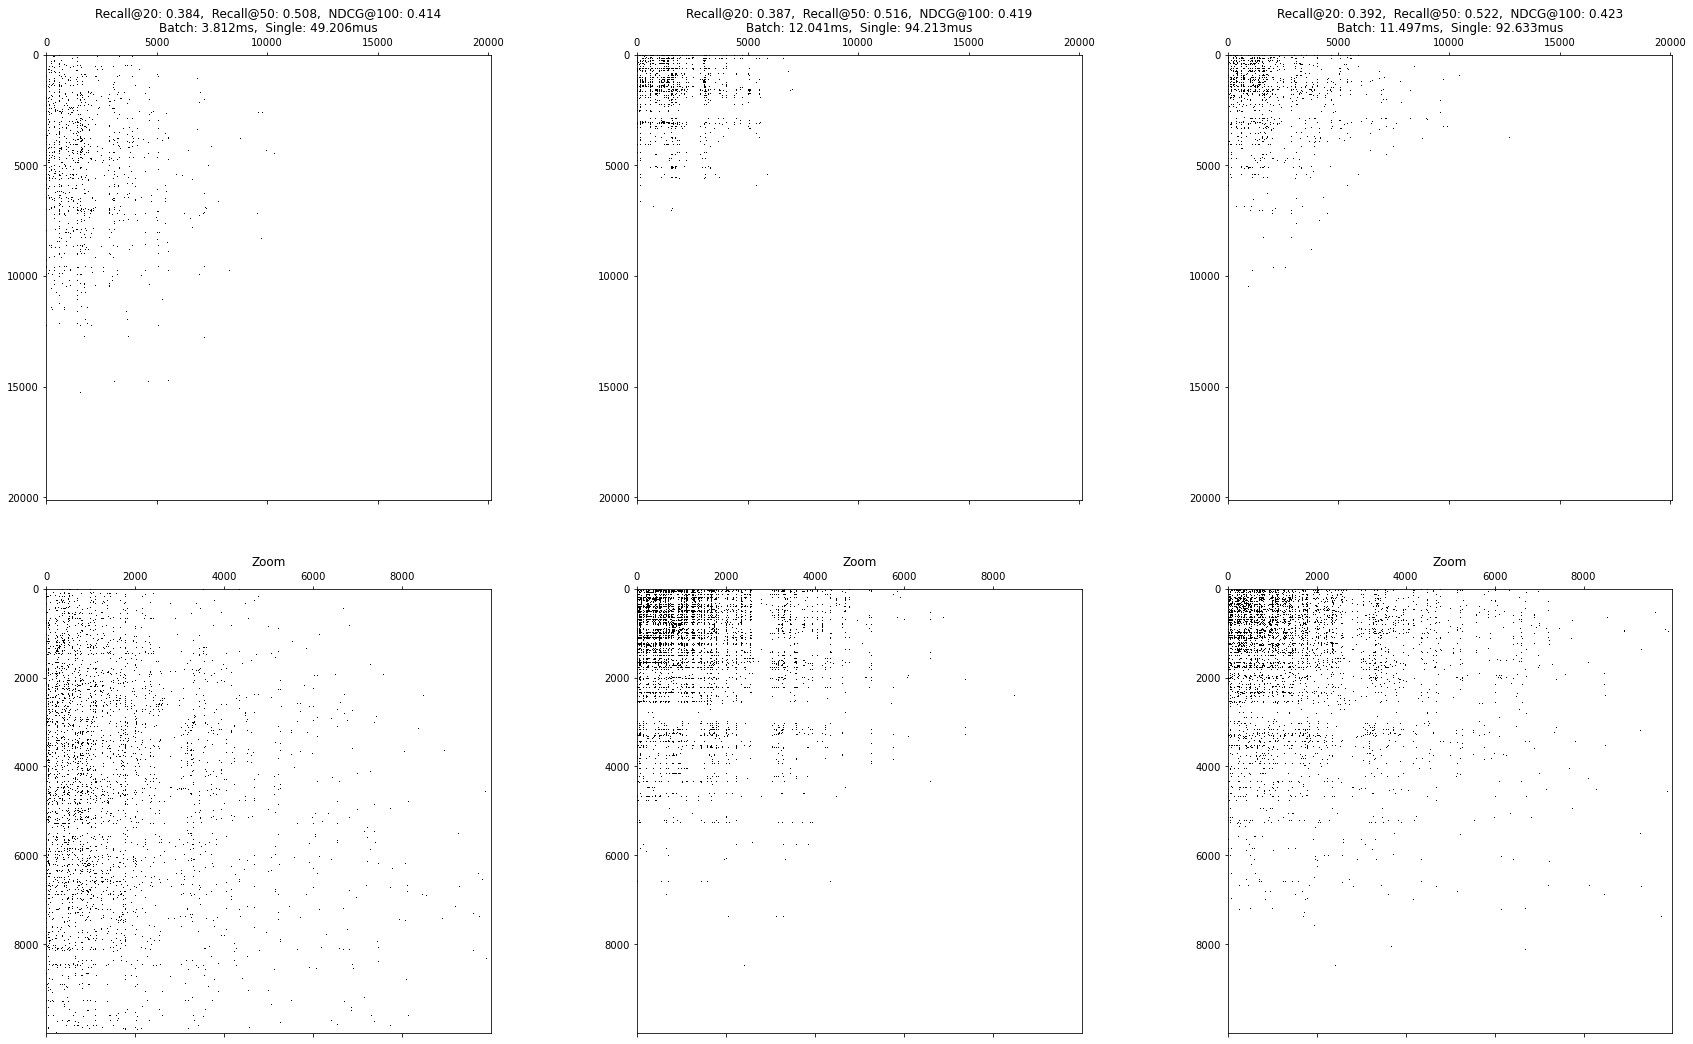

In [25]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

#### Sparsity 0.1%

In [26]:
results_straightf_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_straightforward.csv', sep='|')
results_sparsecov_ml20m = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/ml20m_sparse_cov.csv', sep='|')

In [27]:
results_straightf_ml20m

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01220,0.000042,0.002146,0.371671,0.493390,0.402077
1,0.004983,0.00704,0.000048,0.003819,0.384487,0.508056,0.413662
2,0.009973,0.00522,0.000055,0.005191,0.388080,0.513011,0.417552
3,0.019977,0.00366,0.000070,0.007292,0.390239,0.518839,0.420696
4,0.049847,0.00208,0.000103,0.012698,0.391565,0.522446,0.423361


In [28]:
results_sparsecov_ml20m

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000998,6.58,0.50,0.000057,0.005284,0.375140,0.493187,0.401118
1,0.004979,2.64,0.50,0.000095,0.012160,0.387308,0.515931,0.418530
2,0.009998,9.23,0.25,0.000131,0.019115,0.390200,0.520014,0.421193
3,0.019965,4.73,0.25,0.000182,0.027602,0.391896,0.522009,0.422832
4,0.049840,1.69,0.25,0.000293,0.044909,0.392272,0.522881,0.423813


In [29]:
A_straightforward = sparsify(B_dense, threshold=0.01220, max_in_col=20108)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.000995954647766592


In [30]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.37167060, Recall@50: 0.49339041, NDCG@100: 0.40207703


In [31]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [32]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_ML20M.T, X_train_ML20M).toarray(), n_users=X_train_ML20M.shape[0], 
                                 max_in_col=20108, alpha=0.50, threshold=6.58)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 20108 entries in column: 0
Resulting sparsity of A: 0.0009981409717147456


In [33]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.37513973, Recall@50: 0.49318726, NDCG@100: 0.40111826


In [34]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

In [35]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_01.npy')

In [36]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_ML20M, test_te_ML20M, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.38429537, Recall@50: 0.51179690, NDCG@100: 0.41470931


In [37]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_ML20M, n_users_test=X_test_tr_ML20M.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

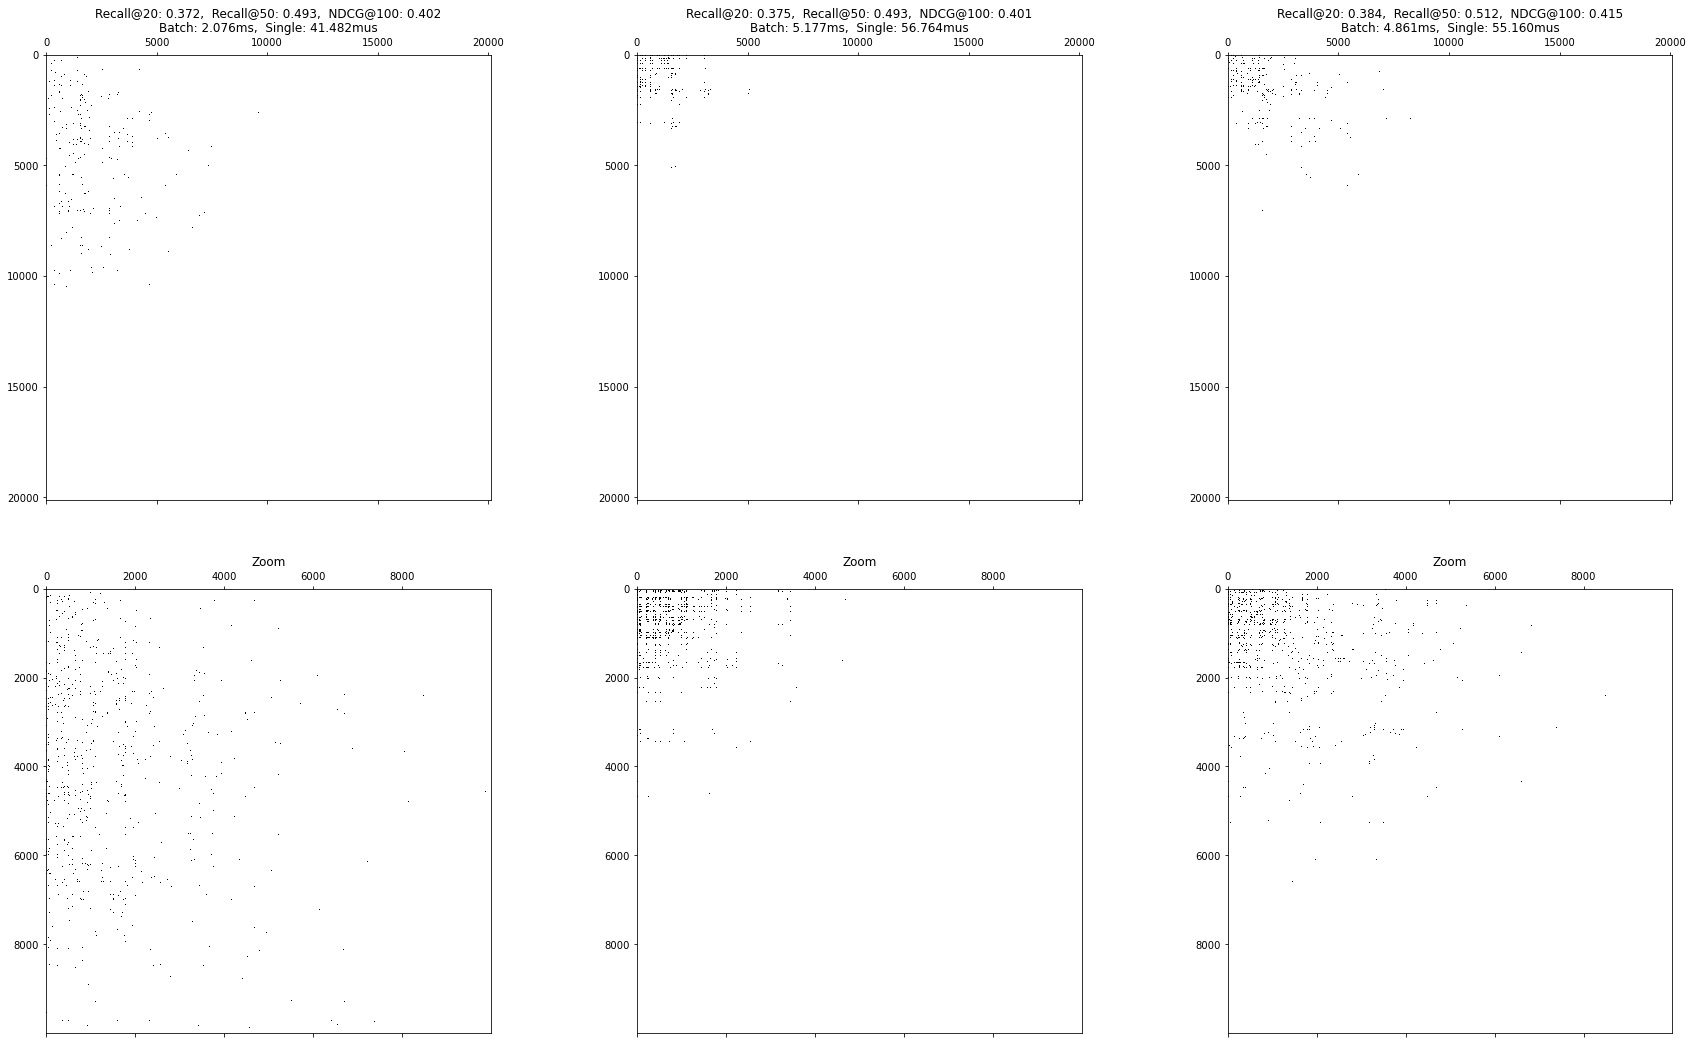

In [38]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

### Netflix

In [39]:
model_EDLAE = EDLAE(p=0.33, lmbda=500)
model_EDLAE.fit(train_netflix, uid_str='uid', sid_str='sid', nItems=17769)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 31.493669033050537
Cholesky: 2.2854862213134766
Computing Inverse based on Chol: 5.316155672073364
finished inverse computation
After Inverse computation: 0.10912466049194336
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.36553381, Recall@50: 0.44917571, NDCG@100: 0.39768713


In [40]:
B_dense = deepcopy(model_EDLAE.B)

#### Sparsity 0.5%

In [41]:
results_straightf_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward.csv', sep='|')
results_sparsecov_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_cov.csv', sep='|')

In [42]:
results_straightf_netflix

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000992,0.01290,0.000041,0.002423,0.344885,0.424491,0.376210
1,0.004982,0.00791,0.000046,0.003890,0.352183,0.434613,0.385183
2,0.009968,0.00621,0.000052,0.004953,0.355969,0.438597,0.388261
3,0.019993,0.00467,0.000061,0.006720,0.359929,0.442264,0.391517
4,0.049779,0.00292,0.000085,0.010831,0.363352,0.446397,0.395190


In [43]:
results_sparsecov_netflix

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,2.047,0.75,0.000057,0.005350,0.345687,0.423379,0.375112
1,0.004997,1.096,0.75,0.000096,0.013188,0.359781,0.441875,0.391292
2,0.009983,0.772,0.75,0.000127,0.019658,0.362675,0.445938,0.394816
3,0.019978,0.509,0.75,0.000174,0.028768,0.364439,0.448163,0.396702
4,0.049916,1.764,0.50,0.000305,0.054065,0.365215,0.449104,0.397588


In [44]:
A_straightforward = sparsify(B_dense, threshold=0.00791, max_in_col=17769)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004982397379320593


In [45]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.35218261, Recall@50: 0.43461337, NDCG@100: 0.38518299


In [46]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [47]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_netflix.T, X_train_netflix).toarray(), n_users=X_train_netflix.shape[0], 
                                 max_in_col=17769, alpha=0.75, threshold=1.096)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.004996659232861581


In [48]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.35978085, Recall@50: 0.44187479, NDCG@100: 0.39129215


In [49]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [50]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_05.npy')

In [51]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.36454960, Recall@50: 0.44807027, NDCG@100: 0.39673911


In [52]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

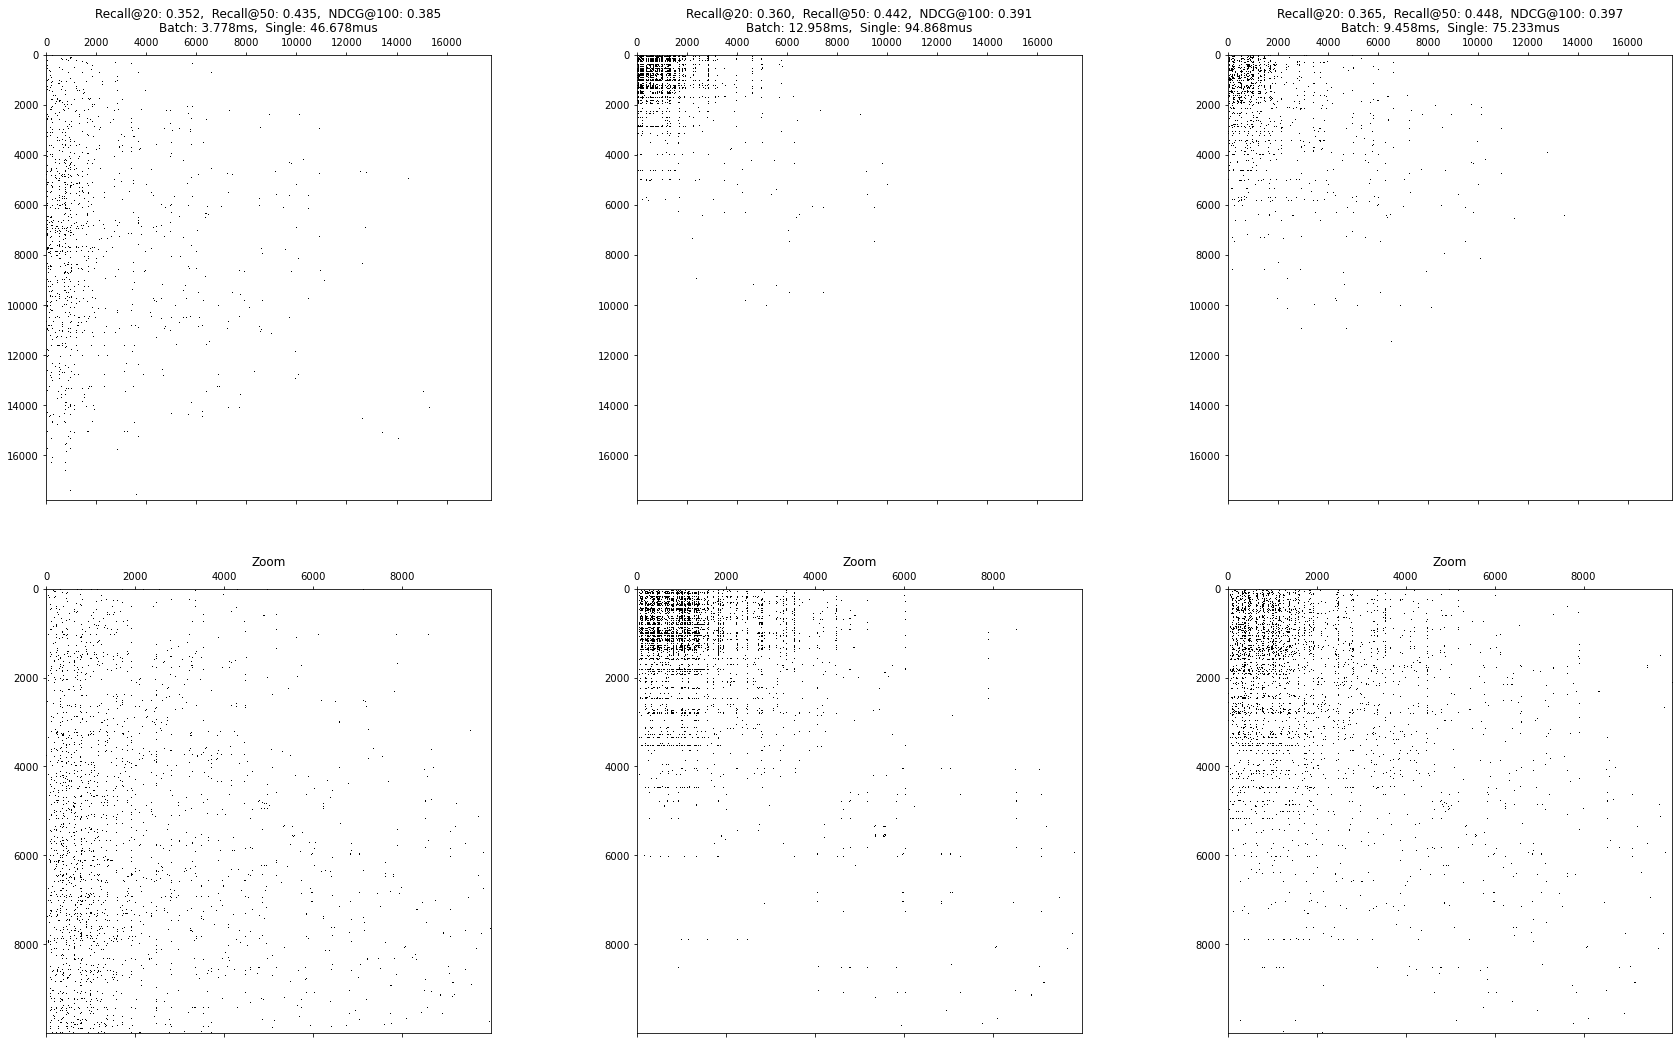

In [53]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

#### Sparsity 0.1%

In [54]:
results_straightf_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_straightforward.csv', sep='|')
results_sparsecov_netflix = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/netflix_sparse_cov.csv', sep='|')

In [55]:
results_straightf_netflix

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000992,0.01290,0.000041,0.002423,0.344885,0.424491,0.376210
1,0.004982,0.00791,0.000046,0.003890,0.352183,0.434613,0.385183
2,0.009968,0.00621,0.000052,0.004953,0.355969,0.438597,0.388261
3,0.019993,0.00467,0.000061,0.006720,0.359929,0.442264,0.391517
4,0.049779,0.00292,0.000085,0.010831,0.363352,0.446397,0.395190


In [56]:
results_sparsecov_netflix

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,2.047,0.75,0.000057,0.005350,0.345687,0.423379,0.375112
1,0.004997,1.096,0.75,0.000096,0.013188,0.359781,0.441875,0.391292
2,0.009983,0.772,0.75,0.000127,0.019658,0.362675,0.445938,0.394816
3,0.019978,0.509,0.75,0.000174,0.028768,0.364439,0.448163,0.396702
4,0.049916,1.764,0.50,0.000305,0.054065,0.365215,0.449104,0.397588


In [57]:
A_straightforward = sparsify(B_dense, threshold=0.01290, max_in_col=17769)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009916469783884715


In [58]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.34488452, Recall@50: 0.42449097, NDCG@100: 0.37621010


In [59]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [60]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_netflix.T, X_train_netflix).toarray(), n_users=X_train_netflix.shape[0], 
                                 max_in_col=17769, alpha=0.75, threshold=2.047)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 17769 entries in column: 0
Resulting sparsity of A: 0.0009991342139582906


In [61]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.34568683, Recall@50: 0.42337861, NDCG@100: 0.37511217


In [62]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

In [63]:
B_admm = np.load(file='/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_netflix_01.npy')

In [64]:
model_EDLAE.B = B_admm
metr_EDLAE_admm = model_EDLAE.evaluate_metrics(test_tr_netflix, test_te_netflix, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.35559922, Recall@50: 0.43775692, NDCG@100: 0.38712490


In [65]:
times_admm = timeit_sparse(sp.csr_matrix(B_admm), X_test=X_test_tr_netflix, n_users_test=X_test_tr_netflix.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

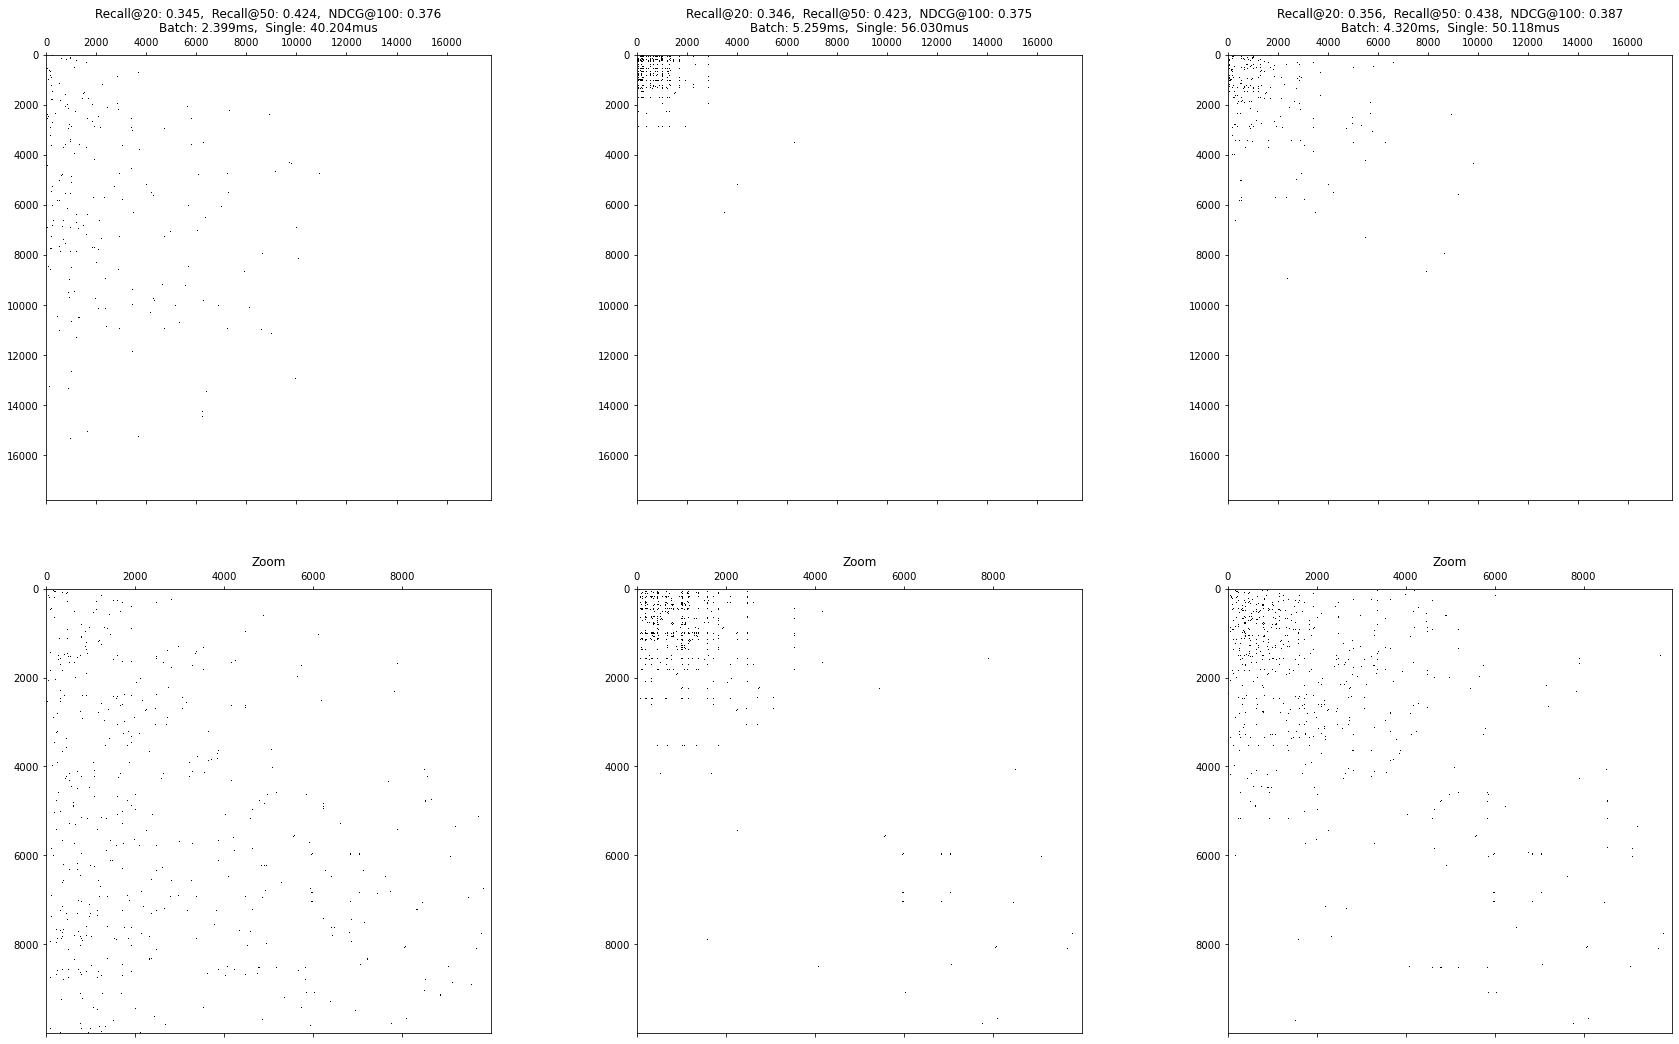

In [66]:
fig, ax = plt.subplots(2,3, figsize=(30,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[0,2].spy(B_admm)
ax[0,2].set_title(f'Recall@20: {metr_EDLAE_admm["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_admm["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_admm["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_admm[0] * 1e3:.3f}ms,  Single: {times_admm[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')
ax[1,2].spy(B_admm[:10000, :10000])
ax[1,2].set_title('Zoom')

### MSD

In [67]:
model_EDLAE = EDLAE(p=0.25, lmbda=70)
model_EDLAE.fit(train_msd, uid_str='uid', sid_str='sid', nItems=41140)
metr_EDLAE = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My DLAE:  Recall@20: {metr_EDLAE["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE["NDCG(k=100)"]:.8f}')

Until Inverse computation: 20.76026940345764
Cholesky: 25.965376615524292
Computing Inverse based on Chol: 117.2650876045227
finished inverse computation
After Inverse computation: 0.6164977550506592
create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My DLAE:  Recall@20: 0.33407616, Recall@50: 0.42947739, NDCG@100: 0.39150817


In [68]:
B_dense = deepcopy(model_EDLAE.B)

#### Sparsity 0.5%

In [69]:
results_straightf_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward.csv', sep='|')
results_sparsecov_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov.csv', sep='|')

In [70]:
results_straightf_msd

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01200,0.000045,0.002113,0.329580,0.421199,0.385550
1,0.004999,0.00695,0.000058,0.004913,0.332307,0.425618,0.388885
2,0.009965,0.00548,0.000077,0.007933,0.332764,0.426840,0.389641
3,0.019911,0.00421,0.000119,0.012973,0.333207,0.427856,0.390281
4,0.049860,0.00285,0.000236,0.025262,0.333736,0.428533,0.390753


In [71]:
results_sparsecov_msd

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,0.37000,0.75,0.000051,0.003085,0.328761,0.419584,0.384312
1,0.004996,0.60900,0.50,0.000123,0.014369,0.333152,0.427825,0.390515
2,0.009994,0.39900,0.50,0.000205,0.024410,0.333532,0.429220,0.391244
3,0.019999,0.05110,0.75,0.000283,0.031769,0.333932,0.429746,0.391716
4,0.049975,0.00644,1.00,0.000418,0.048610,0.334155,0.429881,0.391885


In [72]:
A_straightforward = sparsify(B_dense, threshold=0.00695, max_in_col=41140)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.004999415657173567


In [73]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33230736, Recall@50: 0.42561803, NDCG@100: 0.38888537


In [74]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

In [75]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_msd.T, X_train_msd).toarray(), n_users=X_train_msd.shape[0], 
                                 max_in_col=41140, alpha=0.5, threshold=0.60900)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.004996217428943558


In [76]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.33315223, Recall@50: 0.42782471, NDCG@100: 0.39051469


In [77]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

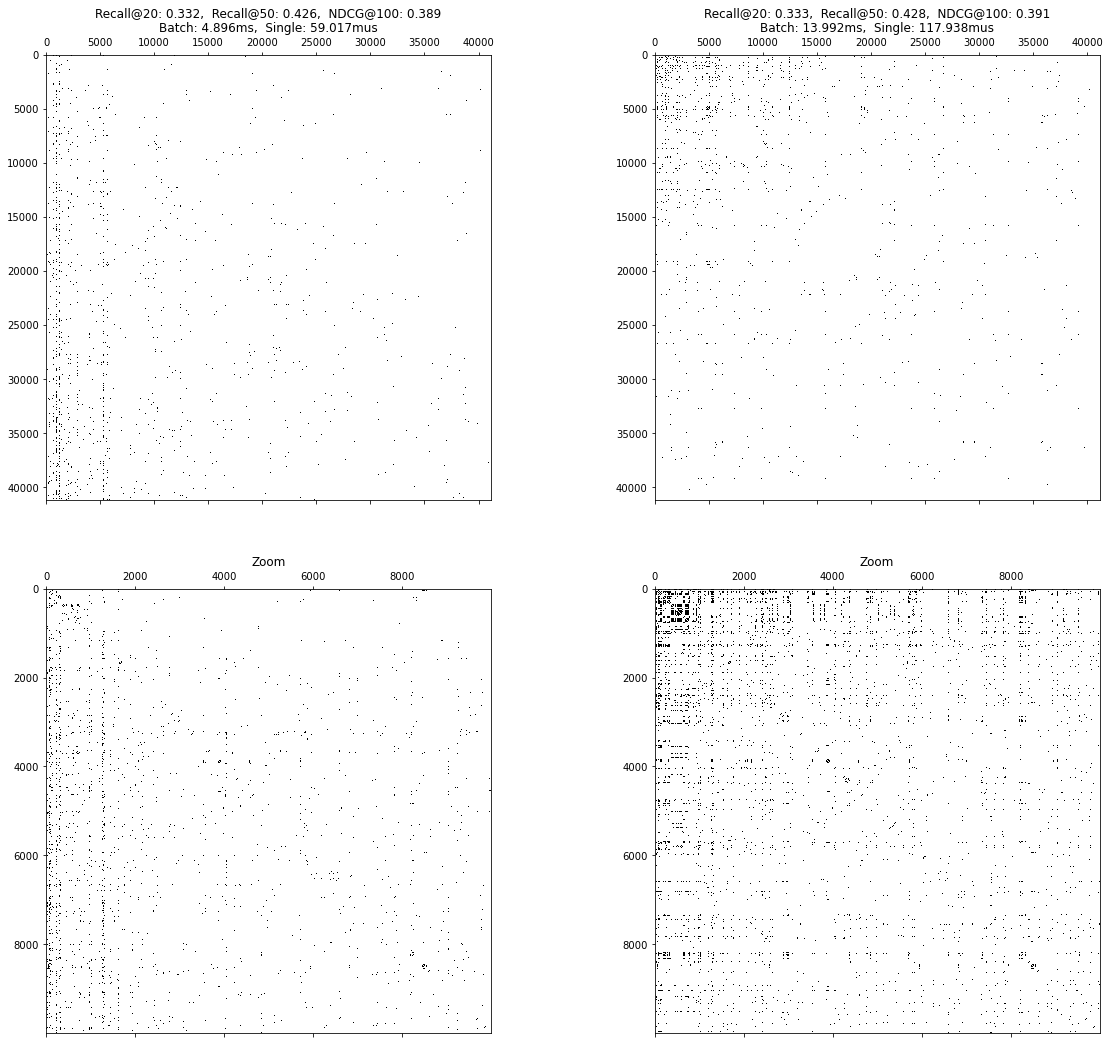

In [78]:
fig, ax = plt.subplots(2,2, figsize=(20,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')

#### Sparsity 0.1%

In [79]:
results_straightf_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_straightforward.csv', sep='|')
results_sparsecov_msd = pd.read_csv('/home/pmoritz/dev/modsem/benchmarks/msd_sparse_cov.csv', sep='|')

In [80]:
results_straightf_msd

,sparsity,threshold,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000996,0.01200,0.000045,0.002113,0.329580,0.421199,0.385550
1,0.004999,0.00695,0.000058,0.004913,0.332307,0.425618,0.388885
2,0.009965,0.00548,0.000077,0.007933,0.332764,0.426840,0.389641
3,0.019911,0.00421,0.000119,0.012973,0.333207,0.427856,0.390281
4,0.049860,0.00285,0.000236,0.025262,0.333736,0.428533,0.390753


In [81]:
results_sparsecov_msd

,sparsity,threshold,alphas,query_time,batch_time,recall@20,recall@50,ndcg@100
0,0.000999,0.37000,0.75,0.000051,0.003085,0.328761,0.419584,0.384312
1,0.004996,0.60900,0.50,0.000123,0.014369,0.333152,0.427825,0.390515
2,0.009994,0.39900,0.50,0.000205,0.024410,0.333532,0.429220,0.391244
3,0.019999,0.05110,0.75,0.000283,0.031769,0.333932,0.429746,0.391716
4,0.049975,0.00644,1.00,0.000418,0.048610,0.334155,0.429881,0.391885


In [82]:
A_straightforward = sparsify(B_dense, threshold=0.01200, max_in_col=41140)
B_straightforward = np.zeros(B_dense.shape, dtype=np.float32)
B_straightforward[A_straightforward.nonzero()] = B_dense[A_straightforward.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.0009962667051738152


In [83]:
model_EDLAE.B = B_straightforward
metr_EDLAE_straight = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.32958039, Recall@50: 0.42119861, NDCG@100: 0.38554988


In [84]:
times_straightforward = timeit_sparse(sp.csr_matrix(B_straightforward), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

In [85]:
A_sparsecov = sparsity_pattern_cov(XtX=np.dot(X_train_msd.T, X_train_msd).toarray(), n_users=X_train_msd.shape[0], 
                                 max_in_col=41140, alpha=0.75, threshold=0.37000)
B_cov = np.zeros(B_dense.shape, dtype=np.float32)
B_cov[A_sparsecov.nonzero()] = B_dense[A_sparsecov.nonzero()]

Number of items with more than 41140 entries in column: 0
Resulting sparsity of A: 0.000999435391299354


In [86]:
model_EDLAE.B = B_cov
metr_EDLAE_cov = model_EDLAE.evaluate_metrics(test_tr_msd, test_te_msd, 'uid', 'sid', metrics_lst)
print(f'My EDLAE:  Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.8f}, Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.8f}, NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.8f}')

create lookup
create true item df
predicting
predicting done, reindexing
calculating metrics
My EDLAE:  Recall@20: 0.32876085, Recall@50: 0.41958407, NDCG@100: 0.38431205


In [87]:
times_cov = timeit_sparse(sp.csr_matrix(B_cov), X_test=X_test_tr_msd, n_users_test=X_test_tr_msd.shape[0], max_k = 100, n_jobs=16)

Text(0.5, 1.0, 'Zoom')

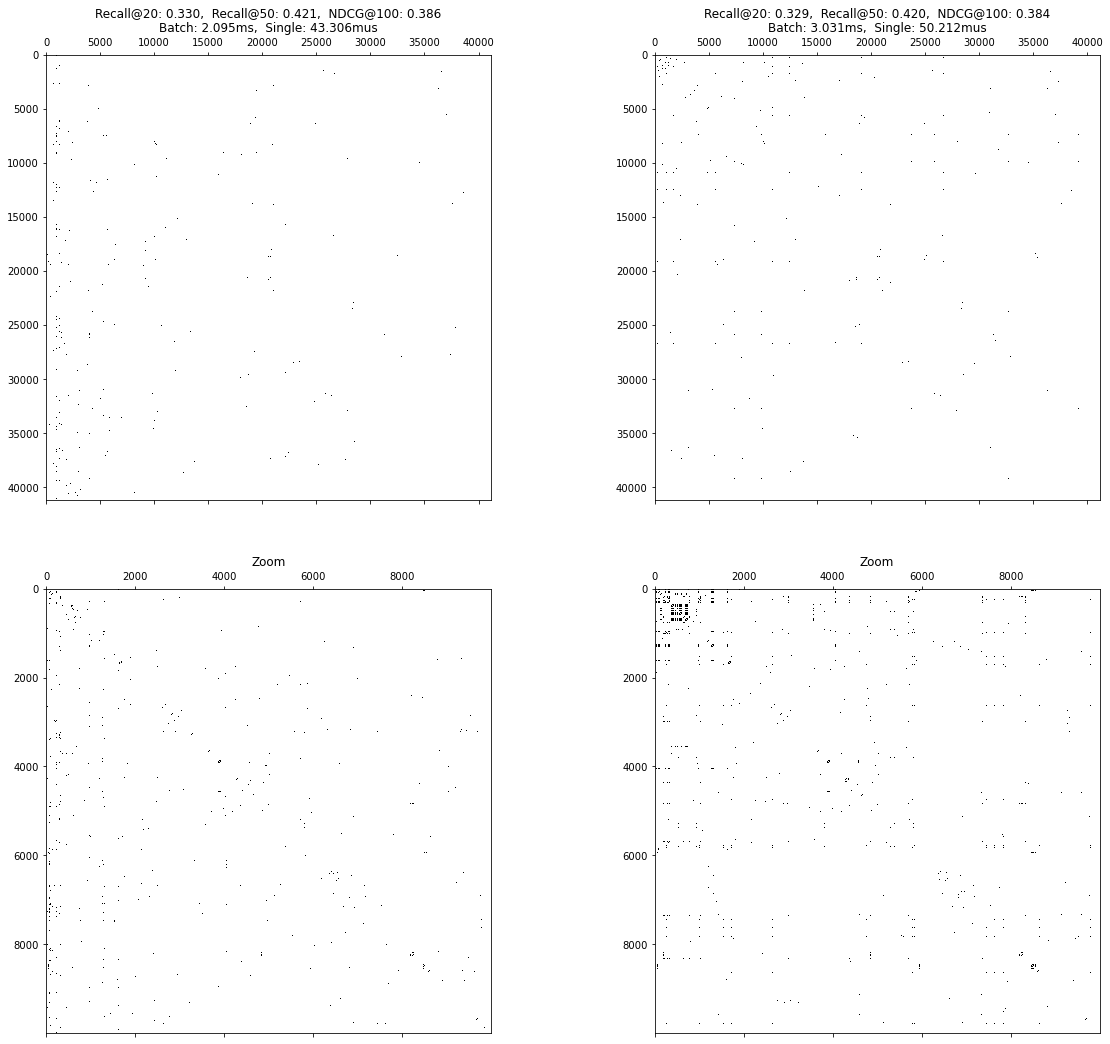

In [88]:
fig, ax = plt.subplots(2,2, figsize=(20,18))
ax[0,0].spy(B_straightforward)
ax[0,0].set_title(f'Recall@20: {metr_EDLAE_straight["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_straight["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_straight["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_straightforward[0] * 1e3:.3f}ms,  Single: {times_straightforward[1] * 1e6:.3f}mus')
ax[0,1].spy(B_cov)
ax[0,1].set_title(f'Recall@20: {metr_EDLAE_cov["Recall(k=20)"]:.3f},  Recall@50: {metr_EDLAE_cov["Recall(k=50)"]:.3f},  NDCG@100: {metr_EDLAE_cov["NDCG(k=100)"]:.3f}\n' + 
                  f'Batch: {times_cov[0] * 1e3:.3f}ms,  Single: {times_cov[1] * 1e6:.3f}mus')
ax[1,0].spy(B_straightforward[:10000, :10000])
ax[1,0].set_title('Zoom')
ax[1,1].spy(B_cov[:10000, :10000])
ax[1,1].set_title('Zoom')

## MRF

In [11]:
def benchnmark_MRF(param_dicts, train, test_tr, test_te, n_items, filename):
    sparsities, alphas, thresholds, rs, lmbdas, max_in_cols = [], [], [], [], [], []
    training_times, batch_times, query_times = [], [], []
    recall20, recall50, ndcg100 = [], [], []
    for param_dict in param_dicts:
        sparsity, alpha, threshold, = param_dict['sparsity'], param_dict['alpha'], param_dict['threshold']
        r, lmbda, max_in_col =  param_dict['r'], param_dict['lambda'], param_dict['max_in_col']
        model_MRF = MRFApprox(lmbda=lmbda)

        def fit_wrapper():
            model_MRF.fit(train, uid_str='uid', sid_str='sid', nItems=n_items, alpha=alpha,threshold=threshold, max_in_col=max_in_col, r=r)

        timer = timeit.Timer(fit_wrapper)
        n_timer, _ = timer.autorange()
        training_time = min(timer.repeat(repeat=7, number=n_timer)) / n_timer

        metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',]
        metr_EDLAE = model_MRF.evaluate_metrics(test_tr, test_te, 'uid', 'sid', metrics_lst)
        
        calc_sparsity = len(model_MRF.B.nonzero()[0]) / (model_MRF.B.shape[0] * model_MRF.B.shape[1])

        batch_time, query_time = timeit_sparse(model_sparse = model_MRF.B, 
                                               X_test = model_MRF.X_test, 
                                               n_users_test = model_MRF.X_test.shape[0], max_k = 100)

        sparsities.append(calc_sparsity)
        alphas.append(alpha)
        thresholds.append(threshold)
        rs.append(r)
        lmbdas.append(lmbda)
        max_in_cols.append(max_in_col)
        training_times.append(training_time )
        batch_times.append(batch_time)
        query_times.append(query_time)
        recall20.append(metr_EDLAE["Recall(k=20)"])
        recall50.append(metr_EDLAE["Recall(k=50)"])
        ndcg100.append(metr_EDLAE["NDCG(k=100)"])

    results = pd.DataFrame({'sparsity': sparsities,
                            'alpha': alphas,
                            'threshold': thresholds,
                            'r': rs,
                            'lambda': lmbdas,
                            'max_in_col': max_in_cols,
                            'training_time': training_times,
                            'query_time': query_times, 
                            'batch_time': batch_times,
                            'recall@20': recall20,
                            'recall@50': recall50,
                            'ndcg@100': ndcg100,})
    results.to_csv(f'benchmarks/{filename}', index=False, sep='|')  

### ML20M

In [12]:
results_search_mrf_ml20m = pd.read_csv('hyperparam_search/MRF_ml20m_new.csv', sep='|')

In [13]:
results_search_mrf_ml20m['sum'] = results_search_mrf_ml20m['recall@20'] + results_search_mrf_ml20m['recall@50'] + results_search_mrf_ml20m['ndcg@100']

In [19]:
results_search_mrf_ml20m[(results_search_mrf_ml20m.desired_sparsity == 0.5) & (results_search_mrf_ml20m.r == 0.5)].sort_values(by='sum').tail(10)

,desired_sparsity,calculated_sparsity,threshold,alpha,lambda,r,recall@20,recall@50,ndcg@100,sum
268,0.5,0.004999,2.252,0.5,19,0.5,0.391060,0.515419,0.424165,1.330644
259,0.5,0.004999,2.252,0.5,10,0.5,0.391746,0.515187,0.423758,1.330691
260,0.5,0.004999,2.252,0.5,11,0.5,0.391654,0.515225,0.423870,1.330750
267,0.5,0.004999,2.252,0.5,18,0.5,0.391099,0.515556,0.424122,1.330778
261,0.5,0.004999,2.252,0.5,12,0.5,0.391429,0.515321,0.424029,1.330779
266,0.5,0.004999,2.252,0.5,17,0.5,0.391123,0.515549,0.424140,1.330812
264,0.5,0.004999,2.252,0.5,15,0.5,0.391192,0.515463,0.424204,1.330860
262,0.5,0.004999,2.252,0.5,13,0.5,0.391394,0.515373,0.424101,1.330867
265,0.5,0.004999,2.252,0.5,16,0.5,0.391236,0.515460,0.424188,1.330883
263,0.5,0.004999,2.252,0.5,14,0.5,0.391266,0.515570,0.424159,1.330995


In [38]:
params_ml20m = [{'sparsity': 0.1, 'alpha': 0.75, 'threshold': 0.882, 'r': 0.0, 'lambda':  4.0, 'max_in_col': 1000},
                {'sparsity': 0.1, 'alpha': 0.75, 'threshold': 0.876, 'r': 0.1, 'lambda':  3.0, 'max_in_col': 1000},
                {'sparsity': 0.1, 'alpha': 0.75, 'threshold': 0.888, 'r': 0.5, 'lambda':  2.0, 'max_in_col': 1000},
                {'sparsity': 0.5, 'alpha': 0.75, 'threshold': 0.452, 'r': 0.0, 'lambda':  4.0, 'max_in_col': 1000},
                {'sparsity': 0.5, 'alpha': 0.50, 'threshold': 2.253, 'r': 0.1, 'lambda': 18.0, 'max_in_col': 1000},
                {'sparsity': 0.5, 'alpha': 0.50, 'threshold': 2.252, 'r': 0.5, 'lambda': 14.0, 'max_in_col': 1000}]

benchnmark_MRF(param_dicts=params_ml20m, train=train_ML20M, test_tr=test_tr_ML20M, test_te=test_te_ML20M, n_items=20108, filename='MRF_ml20m.csv')

XtX: 4.187666893005371 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.562342643737793 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.198621988296509 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.3241662979125977 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10554862022399902 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.024243831634521484 sec
total: 11.82674789428711 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.121854066848755 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.4591691493988037 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.2017054557800293 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.3282108306884766 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10466647148132324 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.022914648056030273 sec
total: 11.631536483764648 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.055789470672607 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.4526679515838623 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.195918560028076 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.333692789077759 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10630178451538086 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.023217201232910156 sec
total: 11.559125900268555 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.130212068557739 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.4856677055358887 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.207627534866333 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.355252265930176 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10649347305297852 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.022975444793701172 sec
total: 11.701728582382202 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.137221336364746 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.476010799407959 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.204685688018799 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.3443546295166016 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10664010047912598 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.023076295852661133 sec
total: 11.691251039505005 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.193241357803345 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.492516040802002 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.1962850093841553 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.3365046977996826 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10606741905212402 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.023128271102905273 sec
total: 11.748058080673218 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.070034027099609 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.4843785762786865 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.222827196121216 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.340085744857788 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10523867607116699 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.023123502731323242 sec
total: 11.641964673995972 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.085584878921509 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011421514591051173
Get A: 2.4714338779449463 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.199631452560425 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.333153486251831 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.10497903823852539 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.023656129837036133 sec
total: 11.611525058746338 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 4.696601152420044 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.4826860427856445 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.03568959236145 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.2222626209259033 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3602328300476074 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02780437469482422 sec
total: 11.378233432769775 sec
XtX: 4.050530910491943 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.5055508613586426 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.1198599338531494 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.1754035949707031 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.35846567153930664 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02815556526184082 sec
total: 10.627886772155762 sec
XtX: 4.759546518325806 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.4942870140075684 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0900819301605225 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.2253990173339844 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.356126070022583 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02810835838317871 sec
total: 11.50539493560791 sec
XtX: 4.051654815673828 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.5012423992156982 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0460805892944336 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.1890614032745361 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.36129212379455566 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.027631282806396484 sec
total: 10.567817211151123 sec
XtX: 4.797499418258667 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.442997932434082 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.03597092628479 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.1808569431304932 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.36102914810180664 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.027178049087524414 sec
total: 11.40028977394104 sec
XtX: 4.049098968505859 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.487056016921997 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.031491279602051 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.1893079280853271 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.36739182472229004 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.028966188430786133 sec
total: 10.550046682357788 sec
XtX: 4.730459213256836 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.4395763874053955 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.036677360534668 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.192368984222412 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3607063293457031 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.027216196060180664 sec
total: 11.339532852172852 sec
XtX: 4.069740295410156 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011618382675070433
Get A: 2.4615635871887207 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0275628566741943 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.1747798919677734 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3575870990753174 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02765798568725586 sec
total: 10.512801170349121 sec
XtX: 4.062843084335327 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.4235119819641113 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8254330158233643 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8733804225921631 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.36545634269714355 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02814793586730957 sec
total: 9.969463109970093 sec
XtX: 4.696123361587524 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.4404284954071045 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.838639736175537 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8322861194610596 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3666253089904785 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.028164386749267578 sec
total: 10.751917600631714 sec
XtX: 4.030709981918335 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.4765512943267822 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8532536029815674 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8429808616638184 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3653702735900879 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.028287410736083984 sec
total: 9.986405611038208 sec
XtX: 4.676945209503174 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.4304118156433105 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8271424770355225 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8818788528442383 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.37064480781555176 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.028324604034423828 sec
total: 10.766327619552612 sec
XtX: 4.056962013244629 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.4315083026885986 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8674938678741455 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8704452514648438 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3651409149169922 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.028165817260742188 sec
total: 10.011931896209717 sec
XtX: 4.694850444793701 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.4386606216430664 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8203184604644775 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8418564796447754 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3666112422943115 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02788257598876953 sec
total: 10.741608381271362 sec
XtX: 4.052086591720581 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.426961660385132 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8364825248718262 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8405106067657471 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.36852312088012695 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.027991294860839844 sec
total: 9.940801620483398 sec
XtX: 4.7138895988464355 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0011239040630762968
Get A: 2.42645525932312 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8245933055877686 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8868029117584229 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3657491207122803 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.028253555297851562 sec
total: 10.80340051651001 sec
XtX: 4.033879995346069 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.7337026596069336 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.3173763751983643 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 12.97569727897644 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.41432809829711914 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11919260025024414 sec
total: 22.982029914855957 sec
XtX: 4.070606708526611 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.7144246101379395 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.3111069202423096 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 12.923116683959961 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.40499043464660645 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11986017227172852 sec
total: 22.924525022506714 sec
XtX: 4.1429407596588135 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.7147045135498047 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.305361032485962 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 13.154463529586792 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.406200647354126 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.12405252456665039 sec
total: 23.22829794883728 sec
XtX: 4.046251535415649 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.728997230529785 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.3149120807647705 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 13.169475317001343 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.4028341770172119 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11919331550598145 sec
total: 23.16103219985962 sec
XtX: 4.048563241958618 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.716111660003662 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.3088834285736084 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 13.067583560943604 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.4038729667663574 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.1204977035522461 sec
total: 23.04473567008972 sec
XtX: 4.68004584312439 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.7342939376831055 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.307394027709961 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 13.132700681686401 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.40688061714172363 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.1208188533782959 sec
total: 23.928759574890137 sec
XtX: 4.054903507232666 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.7153966426849365 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.313474655151367 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 13.034462451934814 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.40784239768981934 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.12049388885498047 sec
total: 23.025439023971558 sec
XtX: 4.681352376937866 sec
Number of items with more than 1000 entries in column: 547
Resulting sparsity of A: 0.005453164311168071
Get A: 2.7224340438842773 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.3343148231506348 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 13.097078323364258 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.40961766242980957 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.1190495491027832 sec
total: 23.90957260131836 sec
XtX: 4.683029413223267 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.025308132171631 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7688641548156738 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.779326915740967 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.06777811050415 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.13863515853881836 sec
total: 20.017590045928955 sec
XtX: 4.1349098682403564 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.0032503604888916 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.746413230895996 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.771991968154907 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.075385808944702 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.13808751106262207 sec
total: 19.24510622024536 sec
XtX: 4.048208475112915 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.019763708114624 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.776188611984253 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.755454778671265 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.0938942432403564 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14028453826904297 sec
total: 19.207762241363525 sec
XtX: 4.129543304443359 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.001636266708374 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7926924228668213 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.732098340988159 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.077863931655884 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.13711166381835938 sec
total: 19.25096106529236 sec
XtX: 4.07001256942749 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.0029757022857666 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7762246131896973 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.751567840576172 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.059550046920776 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14015960693359375 sec
total: 19.176474809646606 sec
XtX: 4.124922752380371 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.0533359050750732 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.80991530418396 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.937237739562988 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.092760324478149 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.13718271255493164 sec
total: 19.531034469604492 sec
XtX: 4.13480544090271 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.039788007736206 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7514910697937012 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.7882091999053955 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.085489988327026 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.13747167587280273 sec
total: 19.323119163513184 sec
XtX: 4.084972143173218 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.0157885551452637 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7565391063690186 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 4.794161558151245 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.083003759384155 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.1381843090057373 sec
total: 19.251461267471313 sec
XtX: 4.091327667236328 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.0214834213256836 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.5647046566009521 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.247175931930542 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.614008665084839 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14557886123657227 sec
total: 15.070527076721191 sec
XtX: 4.038444519042969 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.076686143875122 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.5678846836090088 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.260009765625 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.6118834018707275 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14366626739501953 sec
total: 15.078126907348633 sec
XtX: 4.0905234813690186 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.0723304748535156 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.5639228820800781 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.2608060836791992 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.615834951400757 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14278674125671387 sec
total: 15.127691507339478 sec
XtX: 4.057532072067261 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.055661201477051 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.572402000427246 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.2503440380096436 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.612752437591553 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14568567276000977 sec
total: 15.07660436630249 sec
XtX: 4.064122200012207 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.0404763221740723 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.5699949264526367 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.268089771270752 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.602116823196411 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14319801330566406 sec
total: 15.066369771957397 sec
XtX: 4.0805981159210205 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.126006841659546 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.5704400539398193 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.2531838417053223 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.621279954910278 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14362287521362305 sec
total: 15.1778244972229 sec
XtX: 4.06144380569458 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.0542354583740234 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.555295467376709 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.2640929222106934 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.609700918197632 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14425420761108398 sec
total: 15.07464075088501 sec
XtX: 4.04159688949585 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005104804257922278
Get A: 3.051506996154785 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.5598862171173096 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.2604188919067383 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 4.621841192245483 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.14480805397033691 sec
total: 15.063435792922974 sec


### Netflix

In [20]:
results_search_mrf_netflix = pd.read_csv('hyperparam_search/MRF_netflix_new.csv', sep='|')

In [21]:
results_search_mrf_netflix['sum'] = results_search_mrf_netflix['recall@20'] + results_search_mrf_netflix['recall@50'] + results_search_mrf_netflix['ndcg@100']

In [28]:
results_search_mrf_netflix[(results_search_mrf_netflix.desired_sparsity == 0.5) & (results_search_mrf_netflix.r == 0.5)].sort_values(by='sum').tail(10)

,desired_sparsity,calculated_sparsity,threshold,alpha,lambda,r,recall@20,recall@50,ndcg@100,sum
272,0.5,0.004995,9.880,0.50,23,0.5,0.350251,0.432884,0.383767,1.166902
274,0.5,0.004995,9.880,0.50,25,0.5,0.350209,0.432891,0.383835,1.166934
273,0.5,0.004995,9.880,0.50,24,0.5,0.350245,0.432997,0.383799,1.167041
275,0.5,0.004996,1.036,0.75,1,0.5,0.349934,0.432801,0.384306,1.167041
281,0.5,0.004996,1.036,0.75,7,0.5,0.349467,0.433891,0.384342,1.167701
280,0.5,0.004996,1.036,0.75,6,0.5,0.349902,0.434244,0.384813,1.168959
276,0.5,0.004996,1.036,0.75,2,0.5,0.350543,0.433737,0.385079,1.169359
279,0.5,0.004996,1.036,0.75,5,0.5,0.350508,0.434418,0.385157,1.170083
278,0.5,0.004996,1.036,0.75,4,0.5,0.350631,0.434576,0.385280,1.170487
277,0.5,0.004996,1.036,0.75,3,0.5,0.350771,0.434449,0.385280,1.170501


In [39]:
params_netflix = [{'sparsity': 0.1, 'alpha': 0.75, 'threshold': 2.047, 'r': 0.0, 'lambda': 6.0, 'max_in_col': 1000},
                  {'sparsity': 0.1, 'alpha': 0.75, 'threshold': 2.033, 'r': 0.1, 'lambda': 4.0, 'max_in_col': 1000},
                  {'sparsity': 0.1, 'alpha': 0.75, 'threshold': 2.034, 'r': 0.5, 'lambda': 2.0, 'max_in_col': 1000},
                  {'sparsity': 0.5, 'alpha': 0.75, 'threshold': 1.045, 'r': 0.0, 'lambda': 5.0, 'max_in_col': 1000},
                  {'sparsity': 0.5, 'alpha': 0.75, 'threshold': 1.035, 'r': 0.1, 'lambda': 5.0, 'max_in_col': 1000},
                  {'sparsity': 0.5, 'alpha': 0.75, 'threshold': 1.036, 'r': 0.5, 'lambda': 3.0, 'max_in_col': 1000}]

benchnmark_MRF(param_dicts=params_netflix, train=train_netflix, test_tr=test_tr_netflix, test_te=test_te_netflix, n_items=17769, filename='MRF_netflix.csv')

XtX: 29.330756902694702 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 2.0106899738311768 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.9287517070770264 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.8215172290802002 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.08171987533569336 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.01723647117614746 sec
total: 37.45389366149902 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.834867477416992 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 2.1253116130828857 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.9478578567504883 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.8077571392059326 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.08322501182556152 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.01756453514099121 sec
total: 38.09289193153381 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.912617921829224 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 2.0295255184173584 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.9292402267456055 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.7958712577819824 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.08080363273620605 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.017116069793701172 sec
total: 38.07525897026062 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.373122930526733 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 2.044745445251465 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.9233283996582031 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.776867389678955 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.08050179481506348 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.01735997200012207 sec
total: 37.48108983039856 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.35576105117798 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 2.0330231189727783 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.9295392036437988 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.7738053798675537 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.0801544189453125 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.017448902130126953 sec
total: 37.45380997657776 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.16566514968872 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 1.9985191822052002 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.061969041824341 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.7698359489440918 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.08025383949279785 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.017383575439453125 sec
total: 37.34869146347046 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.301694631576538 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 2.0388131141662598 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.97812819480896 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.7802088260650635 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.08093595504760742 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.017563819885253906 sec
total: 37.458919286727905 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.183457851409912 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010514371785098945
Get A: 1.993039608001709 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.9166359901428223 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 1.77174711227417 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.0918724536895752 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.017496824264526367 sec
total: 37.233091592788696 sec


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


XtX: 29.2913236618042 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 2.0474131107330322 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7712664604187012 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8995482921600342 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2543933391571045 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.020685434341430664 sec
total: 36.54379224777222 sec
XtX: 29.173663854599 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 1.9948468208312988 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7689716815948486 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8926081657409668 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.25335049629211426 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.020721912384033203 sec
total: 36.358495473861694 sec
XtX: 29.237471103668213 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 2.0538623332977295 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7958171367645264 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8907787799835205 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.25484275817871094 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.020701169967651367 sec
total: 36.510029554367065 sec
XtX: 29.21099281311035 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 2.004478693008423 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7687232494354248 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8869216442108154 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2536795139312744 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.020787954330444336 sec
total: 36.399046182632446 sec
XtX: 29.257251739501953 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 2.0382282733917236 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.78863525390625 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8983867168426514 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2537407875061035 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.020655393600463867 sec
total: 36.514508962631226 sec
XtX: 29.130916118621826 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 1.9924466609954834 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7870697975158691 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8907773494720459 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2539052963256836 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02077007293701172 sec
total: 36.3284592628479 sec
XtX: 29.23113989830017 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 2.0637881755828857 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.779512882232666 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8933336734771729 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.25443291664123535 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02077317237854004 sec
total: 36.50413727760315 sec
XtX: 29.15354561805725 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010730374097223166
Get A: 2.012845277786255 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.7677533626556396 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.8941671848297119 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2530066967010498 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.020712614059448242 sec
total: 36.35535168647766 sec
XtX: 29.19148874282837 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 2.0725202560424805 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.630232334136963 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.6815919876098633 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2727994918823242 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.021904706954956055 sec
total: 36.12630581855774 sec
XtX: 29.15161681175232 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 2.0024800300598145 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6422574520111084 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.6789982318878174 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2732048034667969 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.021939754486083984 sec
total: 36.023946046829224 sec
XtX: 29.273797273635864 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 2.086243152618408 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.655433177947998 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.6731593608856201 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.27482008934020996 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02178168296813965 sec
total: 36.2602264881134 sec
XtX: 29.142175436019897 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 2.0039737224578857 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6321299076080322 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.6764891147613525 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.27350306510925293 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02213454246520996 sec
total: 36.00375533103943 sec
XtX: 29.205697536468506 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 2.0958094596862793 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6574938297271729 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.7037632465362549 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.27274060249328613 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.021455764770507812 sec
total: 36.20985198020935 sec
XtX: 29.170864582061768 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 2.0187010765075684 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6413354873657227 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.6806321144104004 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.2742304801940918 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.021747112274169922 sec
total: 36.06255888938904 sec
XtX: 29.25126314163208 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 2.0714776515960693 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6657130718231201 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.7070977687835693 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.27300071716308594 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.02149486541748047 sec
total: 36.24709630012512 sec
XtX: 29.204615592956543 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010715805026317428
Get A: 1.9887769222259521 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6310451030731201 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.7071714401245117 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.27414536476135254 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.021659374237060547 sec
total: 36.08314347267151 sec
XtX: 29.12243342399597 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.301967144012451 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0586187839508057 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 11.096120834350586 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.31067609786987305 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.08908796310424805 sec
total: 47.22959780693054 sec
XtX: 29.075426816940308 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.256889820098877 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.062971830368042 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 11.041907787322998 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.31080102920532227 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.08980393409729004 sec
total: 47.08777737617493 sec
XtX: 29.166922569274902 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.3023223876953125 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0600249767303467 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 11.293559551239014 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3156421184539795 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.08957362174987793 sec
total: 47.47724890708923 sec
XtX: 29.103176832199097 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.2764365673065186 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0492191314697266 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 10.938563346862793 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.30728673934936523 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.08851385116577148 sec
total: 47.02208757400513 sec
XtX: 29.138159036636353 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.3258941173553467 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0492942333221436 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 10.993170499801636 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3122539520263672 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.0892791748046875 sec
total: 47.156646490097046 sec
XtX: 29.2257239818573 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.2621681690216064 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.052565336227417 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 10.999690532684326 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3077261447906494 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.09098076820373535 sec
total: 47.201000452041626 sec
XtX: 29.244859218597412 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.3170294761657715 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0581247806549072 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 11.060216665267944 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.3057534694671631 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.09127378463745117 sec
total: 47.330862045288086 sec
XtX: 29.19817304611206 sec
Number of items with more than 1000 entries in column: 559
Resulting sparsity of A: 0.005054397094298891
Get A: 2.2646031379699707 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 2.0743725299835205 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 11.037355661392212 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 0.32152271270751953 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.08938884735107422 sec
total: 47.23581075668335 sec
XtX: 29.269786596298218 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.32734751701355 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6389877796173096 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.3671464920043945 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.3276054859161377 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10623979568481445 sec
total: 40.29455304145813 sec
XtX: 29.111092805862427 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.267432451248169 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6908206939697266 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.382786512374878 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.3531723022460938 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10917139053344727 sec
total: 40.16536259651184 sec
XtX: 29.439979791641235 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.3448257446289062 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6303670406341553 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.4137940406799316 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.3274013996124268 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.1069939136505127 sec
total: 40.51830291748047 sec
XtX: 29.118407249450684 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.278923988342285 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6410810947418213 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.384397268295288 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.33229660987854 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10644650459289551 sec
total: 40.114524841308594 sec
XtX: 29.24797248840332 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.333247184753418 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.6348180770874023 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.401313066482544 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.328927516937256 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10588240623474121 sec
total: 40.30901598930359 sec
XtX: 29.53939962387085 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.3219316005706787 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.650240182876587 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.4448516368865967 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.3482515811920166 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10991454124450684 sec
total: 40.67814326286316 sec
XtX: 29.902239084243774 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.375216245651245 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.672593355178833 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.454613208770752 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.3468592166900635 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10921335220336914 sec
total: 41.12909746170044 sec
XtX: 29.33992576599121 sec
Number of items with more than 1000 entries in column: 574
Resulting sparsity of A: 0.005136078907050851
Get A: 2.28640079498291 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.697195291519165 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 2.4145734310150146 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.3325841426849365 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10619020462036133 sec
total: 40.44952654838562 sec
XtX: 29.343755960464478 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.3424835205078125 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.405571460723877 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.9370729923248291 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.0634891986846924 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11038589477539062 sec
total: 38.45770001411438 sec
XtX: 29.230151891708374 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.280790090560913 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.4172606468200684 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.9784507751464844 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.0809528827667236 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11253952980041504 sec
total: 38.35204362869263 sec
XtX: 29.314323663711548 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.339301109313965 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.4104914665222168 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.9676706790924072 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.071868896484375 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11245346069335938 sec
total: 38.470213890075684 sec
XtX: 29.226292610168457 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.271111488342285 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.4272618293762207 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.9387552738189697 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.0628554821014404 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.1111752986907959 sec
total: 38.29344916343689 sec
XtX: 29.364296913146973 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.3485264778137207 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.4070394039154053 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.9752275943756104 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.0833473205566406 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11099100112915039 sec
total: 38.5522243976593 sec
XtX: 29.231566190719604 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.2776825428009033 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.4030976295471191 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.973247766494751 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.0709493160247803 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11124444007873535 sec
total: 38.38280439376831 sec
XtX: 29.316789150238037 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.3445897102355957 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.413332462310791 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.9447550773620605 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.066162109375 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11313366889953613 sec
total: 38.460195541381836 sec
XtX: 29.26887035369873 sec
Number of items with more than 1000 entries in column: 572
Resulting sparsity of A: 0.00512796456799422
Get A: 2.305328369140625 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.4094469547271729 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 0.9404044151306152 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 2.063164472579956 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.11064553260803223 sec
total: 38.35100197792053 sec


### MSD

In [29]:
results_search_mrf_msd = pd.read_csv('hyperparam_search/MRF_msd_new.csv', sep='|')

In [30]:
results_search_mrf_msd['sum'] = results_search_mrf_msd['recall@20'] + results_search_mrf_msd['recall@50'] + results_search_mrf_msd['ndcg@100']

In [37]:
results_search_mrf_msd[(results_search_mrf_msd.desired_sparsity == 0.5) & (results_search_mrf_msd.r == 0.5)].sort_values(by='sum').tail(10)

,desired_sparsity,calculated_sparsity,threshold,alpha,lambda,r,recall@20,recall@50,ndcg@100,sum
257,0.5,0.004996,0.539,0.50,8,0.5,0.327857,0.423927,0.382624,1.134408
276,0.5,0.004999,0.103,0.75,2,0.5,0.327742,0.423919,0.383235,1.134896
256,0.5,0.004996,0.539,0.50,7,0.5,0.328162,0.424065,0.382877,1.135103
255,0.5,0.004996,0.539,0.50,6,0.5,0.328584,0.424191,0.383101,1.135876
250,0.5,0.004996,0.539,0.50,1,0.5,0.329208,0.423457,0.383313,1.135978
254,0.5,0.004996,0.539,0.50,5,0.5,0.328825,0.424199,0.383255,1.136280
275,0.5,0.004999,0.103,0.75,1,0.5,0.328824,0.423960,0.383636,1.136419
253,0.5,0.004996,0.539,0.50,4,0.5,0.328928,0.424107,0.383401,1.136437
251,0.5,0.004996,0.539,0.50,2,0.5,0.329320,0.423780,0.383461,1.136562
252,0.5,0.004996,0.539,0.50,3,0.5,0.329216,0.423961,0.383484,1.136660


In [40]:
params_msd = [{'sparsity': 0.1, 'alpha': 0.75, 'threshold': 0.370,  'r': 0.0, 'lambda': 2.0, 'max_in_col': 1000},
              {'sparsity': 0.1, 'alpha': 0.5,  'threshold': 2.006,  'r': 0.1, 'lambda': 6.0, 'max_in_col': 1000},
              {'sparsity': 0.1, 'alpha': 0.75, 'threshold': 0.363,  'r': 0.5, 'lambda': 2.0, 'max_in_col': 1000},
              {'sparsity': 0.5, 'alpha': 0.75, 'threshold': 0.1093, 'r': 0.0, 'lambda': 2.0, 'max_in_col': 1000},
              {'sparsity': 0.5, 'alpha': 0.75, 'threshold': 0.1012, 'r': 0.1, 'lambda': 2.0, 'max_in_col': 1000},
              {'sparsity': 0.5, 'alpha': 0.5,  'threshold': 0.539,  'r': 0.5, 'lambda': 3.0, 'max_in_col': 1000}]

benchnmark_MRF(param_dicts=params_msd, train=train_msd, test_tr=test_tr_msd, test_te=test_te_msd, n_items=41140, filename='MRF_msd.csv')

XtX: 19.74762511253357 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010237426348579345
Get A: 13.433308839797974 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 4.8370842933654785 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 6.304562091827393 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...
forming B: 0.46057748794555664 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.10713601112365723 sec
total: 46.15563106536865 sec
XtX: 19.923826217651367 sec
Number of items with more than 1000 entries in column: 0
Resulting sparsity of A: 0.0010237426348579345
Get A: 10.948738098144531 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 4.862665176391602 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 6.039050817489624 s

In [6]:
model_EDLAE = EDLAE(p=0.33, lmbda=300)
model_EDLAE.fit(train_ML20M, uid_str='uid', sid_str='sid', nItems=20108)

finished inverse computation


In [7]:
model_MRF = MRFApprox(lmbda=18)
model_MRF.fit(
    train_data = train_ML20M,
    uid_str = 'uid',
    sid_str = 'sid',
    nItems = 20108,
    alpha = 0.50,
    threshold = 2.253,
    max_in_col = 1000,
    r = 0.1,
    dtype = np.float32,
    store_dense=False,
)

XtX: 4.184335231781006 sec
Number of items with more than 1000 entries in column: 980
Resulting sparsity of A: 0.005102387924780485
Get A: 3.2190065383911133 sec
iterating through steps 1,2, and 4 in section 3.2 of the paper ...
building block_list: 1.8507068157196045 sec
now step 3 in section 3.2 of the paper: iterating ...
Computing block inverses: 5.031786203384399 sec
final step: obtaining the sparse matrix B by averaging the solutions regarding the various sets D ...


/home/pmoritz/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


forming B: 5.104278087615967 sec
forcing the sparsity pattern of A onto B ...
forcing sparsity B: 0.13988399505615234 sec
total: 19.930983304977417 sec


In [9]:
model_MRF.evaluate_metrics(
    test_data_tr = test_tr_ML20M,
    test_data_te = test_te_ML20M,
    uid_str = 'uid',
    sid_str = 'sid',
    metrics = metrics_lst,
    n_jobs=16,
)

{'Recall(k=20)': 0.38898592449217545,
 'Recall(k=50)': 0.5175957051360353,
 'NDCG(k=100)': 0.41804161593630607}

In [40]:
B_ADMM = np.load('/home/pmoritz/dev/modsem/sparse_mat/' + 'ADMM_ml20m_05.npy')

In [77]:
nnz_idxes = model_MRF.B.nonzero()

In [59]:
nnz_ADMM = np.nonzero(B_ADMM)

In [89]:
errors = (model_MRF.B.toarray() - model_EDLAE.B) 

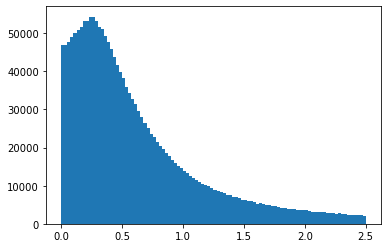

In [95]:
plt.hist(np.abs(errors[nnz_idxes] / model_EDLAE.B[nnz_idxes]), bins=100, range=(0, 2.5));

In [ ]:
# could compare sparse cov with dense sol

## Variational Autoencoder - RecVae
Matches the results from the paper. Might be improved by further hyperparam optimization. Seems like they optimized the model for ML20M and then just changed the gamma param.

In [11]:
import torch
import sys

from RecVAE.model import VAE

In [12]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)

class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)

def evaluate_VAE(model, data_in, data_out, device, metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], samples_perc_per_epoch=1, batch_size=500):
    model.to(device)
    model.eval()
    metric_callers = {}
    scores = {}
    max_topk = 0
    for metric in metrics_lst:
        try:
            metric_callers[metric] = eval(metric)
            max_topk = max(max_topk, int(metric.split("k=")[-1].strip(")")))
            scores[metric] = []
        except:
            raise NotImplementedError('metrics={} not implemented.'.format(metric))
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        
        ratings_in = batch.get_ratings_to_dev()
        ratings_out = batch.get_ratings(is_out=True)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
                
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        
        topk = argpartition(-ratings_pred, max_topk - 1, axis=1)[:, :max_topk]

        # we need to sort manually
        n_batch = ratings_out.shape[0]
        sorted_idx = (-ratings_pred)[np.arange(n_batch)[:, None], topk].argsort()
        topk = topk[np.arange(n_batch)[:, None], sorted_idx]
        
        for row in range(ratings_out.shape[0]):
            pred_items = topk[row, :]
            ratings_out_row  = ratings_out[row, :]
            _, true_items, _ = sp.find(ratings_out_row)
            
            for metric in metrics_lst:
                scores[metric].append(metric_callers[metric](pred_items, true_items))

    for metric in scores.keys():
        scores[metric] = np.mean(scores[metric])
        
    return scores

### ML20M

In [13]:
model_kwargs = {
    'hidden_dim': 600,
    'latent_dim': 200,
    'input_dim': 20108
}

In [14]:
model_best = VAE(**model_kwargs)
model_best.load_state_dict(torch.load('RecVAE/ml20m_best'))

<All keys matched successfully>

In [15]:
gpu = torch.device("cuda:0")

In [16]:
evaluate_VAE(model=model_best, 
             data_in=X_test_tr_ML20M, 
             data_out=X_test_te_ML20M, 
             device=gpu, #='cpu',
             metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], 
             samples_perc_per_epoch=1, 
             batch_size=500)

{'Recall(k=20)': 0.41422593409041947,
 'Recall(k=50)': 0.554342493936054,
 'NDCG(k=100)': 0.44284833890062303}

#### GPU Times

In [17]:
timeit_dense_VAE(model_best, 
                 device=gpu, 
                 X_test_tr=X_test_tr_ML20M, 
                 n_users_test=X_test_tr_ML20M.shape[0], 
                 max_k = 100)

(0.008243372759970953, 0.0004788536522405775)

#### CPU Times

In [18]:
timeit_dense_VAE(model_best, 
                 device='cpu', 
                 X_test_tr=X_test_tr_ML20M, 
                 n_users_test=X_test_tr_ML20M.shape[0], 
                 max_k = 100)

(0.06828295879968209, 0.0013768840233005905)

### Netflix

In [19]:
model_kwargs = {
    'hidden_dim': 600,
    'latent_dim': 200,
    'input_dim': 17769
}

In [20]:
model_best = VAE(**model_kwargs)
model_best.load_state_dict(torch.load('RecVAE/netflix_best'))

<All keys matched successfully>

In [21]:
gpu = torch.device("cuda:0")

In [22]:
evaluate_VAE(model=model_best, 
             data_in=X_test_tr_netflix, 
             data_out=X_test_te_netflix, 
             device=gpu, #='cpu',
             metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], 
             samples_perc_per_epoch=1, 
             batch_size=500)

{'Recall(k=20)': 0.36266024174140277,
 'Recall(k=50)': 0.4533128744640806,
 'NDCG(k=100)': 0.39479793227199245}

#### GPU Times

In [23]:
timeit_dense_VAE(model_best, 
                 device=gpu, 
                 X_test_tr=X_test_tr_netflix, 
                 n_users_test=X_test_tr_netflix.shape[0], 
                 max_k = 100)

(0.006856929399946239, 0.0004443084031597391)

#### CPU Times

In [24]:
timeit_dense_VAE(model_best, 
                 device='cpu', 
                 X_test_tr=X_test_tr_netflix, 
                 n_users_test=X_test_tr_netflix.shape[0], 
                 max_k = 100)

(0.062044371600495654, 0.0012358275480502925)

### MSD

In [25]:
model_kwargs = {
    'hidden_dim': 600,
    'latent_dim': 200,
    'input_dim': 41140
}

In [26]:
model_best = VAE(**model_kwargs)
model_best.load_state_dict(torch.load('RecVAE/msd_best'))

<All keys matched successfully>

In [27]:
gpu = torch.device("cuda:0")

In [28]:
evaluate_VAE(model=model_best, 
             data_in=X_test_tr_msd, 
             data_out=X_test_te_msd, 
             device=gpu, #='cpu',
             metrics_lst = ['Recall(k=20)', 'Recall(k=50)', 'NDCG(k=100)',], 
             samples_perc_per_epoch=1, 
             batch_size=500)

{'Recall(k=20)': 0.27711796495266,
 'Recall(k=50)': 0.37538190093131724,
 'NDCG(k=100)': 0.32709714843412047}

Matches results from the paper. Might be improved by further hyperparam optimization. Seems like they optimized the model for ML20M and then just changed the gamma param.

#### GPU Times

In [29]:
timeit_dense_VAE(model_best, 
                 device=gpu, 
                 X_test_tr=X_test_tr_msd, 
                 n_users_test=X_test_tr_msd.shape[0], 
                 max_k = 100)

(0.025331003700011935, 0.0004752334103595785)

#### CPU Times

In [30]:
timeit_dense_VAE(model_best, 
                 device='cpu', 
                 X_test_tr=X_test_tr_msd, 
                 n_users_test=X_test_tr_msd.shape[0], 
                 max_k = 100)

(0.13482804199884413, 0.0037842784098982524)